## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


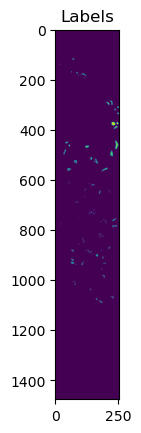

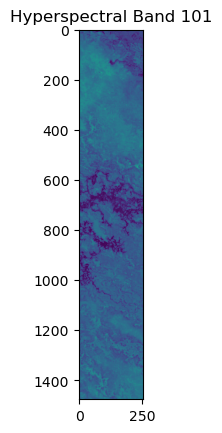

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(560, 5, 5, 145)
(70, 5, 5, 145)
(2618, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 280
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2224, PSNR: -6.5087


Epoch [1/50] Training Loss: 0.2132, PSNR: -8.6614
	[Val]   Batch [1/11] Loss: 0.2058, PSNR: -6.1709
	[Val]   Batch [10/11] Loss: 0.2059, PSNR: -8.4099
Epoch [1/50] Validation Loss: 0.2058, PSNR: -8.1018

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1978, PSNR: -8.9219


Epoch [2/50] Training Loss: 0.1910, PSNR: -8.2809
	[Val]   Batch [1/11] Loss: 0.1801, PSNR: -5.5914
	[Val]   Batch [10/11] Loss: 0.1802, PSNR: -7.8306
Epoch [2/50] Validation Loss: 0.1799, PSNR: -7.5189

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1769, PSNR: -7.9072


Epoch [3/50] Training Loss: 0.1698, PSNR: -7.8572
	[Val]   Batch [1/11] Loss: 0.1542, PSNR: -4.9166
	[Val]   Batch [10/11] Loss: 0.1544, PSNR: -7.1588
Epoch [3/50] Validation Loss: 0.1540, PSNR: -6.8439

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1565, PSNR: -8.4046


Epoch [4/50] Training Loss: 0.1493, PSNR: -7.3590
	[Val]   Batch [1/11] Loss: 0.1326, PSNR: -4.2625
	[Val]   Batch [10/11] Loss: 0.1328, PSNR: -6.5058
Epoch [4/50] Validation Loss: 0.1326, PSNR: -6.1921

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1370, PSNR: -7.3442


Epoch [5/50] Training Loss: 0.1301, PSNR: -6.6693
	[Val]   Batch [1/11] Loss: 0.1163, PSNR: -3.6946
	[Val]   Batch [10/11] Loss: 0.1165, PSNR: -5.9354
Epoch [5/50] Validation Loss: 0.1163, PSNR: -5.6250

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1190, PSNR: -6.7322


Epoch [6/50] Training Loss: 0.1125, PSNR: -6.2591
	[Val]   Batch [1/11] Loss: 0.0991, PSNR: -2.9985
	[Val]   Batch [10/11] Loss: 0.0992, PSNR: -5.2401
Epoch [6/50] Validation Loss: 0.0991, PSNR: -4.9278

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1019, PSNR: -3.1193


Epoch [7/50] Training Loss: 0.0968, PSNR: -5.4727
	[Val]   Batch [1/11] Loss: 0.0866, PSNR: -2.4132
	[Val]   Batch [10/11] Loss: 0.0867, PSNR: -4.6523
Epoch [7/50] Validation Loss: 0.0866, PSNR: -4.3431

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0877, PSNR: -4.7018


Epoch [8/50] Training Loss: 0.0834, PSNR: -4.6570
	[Val]   Batch [1/11] Loss: 0.0738, PSNR: -1.7205
	[Val]   Batch [10/11] Loss: 0.0739, PSNR: -3.9611
Epoch [8/50] Validation Loss: 0.0738, PSNR: -3.6504

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0748, PSNR: -1.7783


Epoch [9/50] Training Loss: 0.0719, PSNR: -4.0969
	[Val]   Batch [1/11] Loss: 0.0654, PSNR: -1.1947
	[Val]   Batch [10/11] Loss: 0.0655, PSNR: -3.4348
Epoch [9/50] Validation Loss: 0.0654, PSNR: -3.1256

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0655, PSNR: -4.9209


Epoch [10/50] Training Loss: 0.0622, PSNR: -3.6266
	[Val]   Batch [1/11] Loss: 0.0562, PSNR: -0.5320
	[Val]   Batch [10/11] Loss: 0.0562, PSNR: -2.7730
Epoch [10/50] Validation Loss: 0.0562, PSNR: -2.4627

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0570, PSNR: -1.9130


Epoch [11/50] Training Loss: 0.0542, PSNR: -2.7107
	[Val]   Batch [1/11] Loss: 0.0503, PSNR: -0.0510
	[Val]   Batch [10/11] Loss: 0.0503, PSNR: -2.2904
Epoch [11/50] Validation Loss: 0.0503, PSNR: -1.9816

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0492, PSNR: -1.2732


Epoch [12/50] Training Loss: 0.0476, PSNR: -2.2828
	[Val]   Batch [1/11] Loss: 0.0441, PSNR: 0.5149
	[Val]   Batch [10/11] Loss: 0.0442, PSNR: -1.7245
Epoch [12/50] Validation Loss: 0.0441, PSNR: -1.4154

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0433, PSNR: -1.3374


Epoch [13/50] Training Loss: 0.0420, PSNR: -1.9071
	[Val]   Batch [1/11] Loss: 0.0392, PSNR: 1.0260
	[Val]   Batch [10/11] Loss: 0.0393, PSNR: -1.2130
Epoch [13/50] Validation Loss: 0.0392, PSNR: -0.9038

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0389, PSNR: -1.9544


Epoch [14/50] Training Loss: 0.0373, PSNR: -1.2417
	[Val]   Batch [1/11] Loss: 0.0355, PSNR: 1.4646
	[Val]   Batch [10/11] Loss: 0.0355, PSNR: -0.7743
Epoch [14/50] Validation Loss: 0.0355, PSNR: -0.4655

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0343, PSNR: -1.4029


Epoch [15/50] Training Loss: 0.0334, PSNR: -0.6923
	[Val]   Batch [1/11] Loss: 0.0316, PSNR: 1.9657
	[Val]   Batch [10/11] Loss: 0.0316, PSNR: -0.2737
Epoch [15/50] Validation Loss: 0.0316, PSNR: 0.0347

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0311, PSNR: -0.8137


Epoch [16/50] Training Loss: 0.0301, PSNR: -0.3931
	[Val]   Batch [1/11] Loss: 0.0285, PSNR: 2.4088
	[Val]   Batch [10/11] Loss: 0.0286, PSNR: 0.1686
Epoch [16/50] Validation Loss: 0.0285, PSNR: 0.4779

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0283, PSNR: 0.8572


Epoch [17/50] Training Loss: 0.0272, PSNR: 0.1846
	[Val]   Batch [1/11] Loss: 0.0262, PSNR: 2.7747
	[Val]   Batch [10/11] Loss: 0.0263, PSNR: 0.5346
Epoch [17/50] Validation Loss: 0.0262, PSNR: 0.8436

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0253, PSNR: 2.9271


Epoch [18/50] Training Loss: 0.0247, PSNR: 0.5642
	[Val]   Batch [1/11] Loss: 0.0237, PSNR: 3.2088
	[Val]   Batch [10/11] Loss: 0.0238, PSNR: 0.9682
Epoch [18/50] Validation Loss: 0.0237, PSNR: 1.2777

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0234, PSNR: 3.2749


Epoch [19/50] Training Loss: 0.0226, PSNR: 0.9719
	[Val]   Batch [1/11] Loss: 0.0217, PSNR: 3.5943
	[Val]   Batch [10/11] Loss: 0.0217, PSNR: 1.3535
Epoch [19/50] Validation Loss: 0.0217, PSNR: 1.6631

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0214, PSNR: -0.2754


Epoch [20/50] Training Loss: 0.0207, PSNR: 1.3989
	[Val]   Batch [1/11] Loss: 0.0201, PSNR: 3.9411
	[Val]   Batch [10/11] Loss: 0.0201, PSNR: 1.7004
Epoch [20/50] Validation Loss: 0.0201, PSNR: 2.0102

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0198, PSNR: 1.4137


Epoch [21/50] Training Loss: 0.0190, PSNR: 1.6391
	[Val]   Batch [1/11] Loss: 0.0185, PSNR: 4.2981
	[Val]   Batch [10/11] Loss: 0.0185, PSNR: 2.0581
Epoch [21/50] Validation Loss: 0.0185, PSNR: 2.3677

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0180, PSNR: 2.4767


Epoch [22/50] Training Loss: 0.0175, PSNR: 2.0946
	[Val]   Batch [1/11] Loss: 0.0172, PSNR: 4.6160
	[Val]   Batch [10/11] Loss: 0.0172, PSNR: 2.3763
Epoch [22/50] Validation Loss: 0.0172, PSNR: 2.6858

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0166, PSNR: 3.1705


Epoch [23/50] Training Loss: 0.0162, PSNR: 2.2787
	[Val]   Batch [1/11] Loss: 0.0158, PSNR: 4.9705
	[Val]   Batch [10/11] Loss: 0.0158, PSNR: 2.7315
Epoch [23/50] Validation Loss: 0.0158, PSNR: 3.0409

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0157, PSNR: 0.6432


Epoch [24/50] Training Loss: 0.0151, PSNR: 2.6965
	[Val]   Batch [1/11] Loss: 0.0147, PSNR: 5.2980
	[Val]   Batch [10/11] Loss: 0.0147, PSNR: 3.0589
Epoch [24/50] Validation Loss: 0.0147, PSNR: 3.3686

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0142, PSNR: 4.1138


Epoch [25/50] Training Loss: 0.0141, PSNR: 2.9228
	[Val]   Batch [1/11] Loss: 0.0138, PSNR: 5.5576
	[Val]   Batch [10/11] Loss: 0.0138, PSNR: 3.3203
Epoch [25/50] Validation Loss: 0.0138, PSNR: 3.6289

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0134, PSNR: 3.7534


Epoch [26/50] Training Loss: 0.0131, PSNR: 3.3371
	[Val]   Batch [1/11] Loss: 0.0129, PSNR: 5.8433
	[Val]   Batch [10/11] Loss: 0.0129, PSNR: 3.6058
Epoch [26/50] Validation Loss: 0.0129, PSNR: 3.9151

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0130, PSNR: 4.1974


Epoch [27/50] Training Loss: 0.0123, PSNR: 3.4965
	[Val]   Batch [1/11] Loss: 0.0121, PSNR: 6.1403
	[Val]   Batch [10/11] Loss: 0.0121, PSNR: 3.9033
Epoch [27/50] Validation Loss: 0.0121, PSNR: 4.2123

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0119, PSNR: 3.9592


Epoch [28/50] Training Loss: 0.0115, PSNR: 3.8523
	[Val]   Batch [1/11] Loss: 0.0113, PSNR: 6.4411
	[Val]   Batch [10/11] Loss: 0.0113, PSNR: 4.2037
Epoch [28/50] Validation Loss: 0.0113, PSNR: 4.5134

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0113, PSNR: 1.9910


Epoch [29/50] Training Loss: 0.0108, PSNR: 4.0923
	[Val]   Batch [1/11] Loss: 0.0107, PSNR: 6.6651
	[Val]   Batch [10/11] Loss: 0.0107, PSNR: 4.4282
Epoch [29/50] Validation Loss: 0.0107, PSNR: 4.7375

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0103, PSNR: 4.6142


Epoch [30/50] Training Loss: 0.0102, PSNR: 4.2052
	[Val]   Batch [1/11] Loss: 0.0100, PSNR: 6.9430
	[Val]   Batch [10/11] Loss: 0.0100, PSNR: 4.7061
Epoch [30/50] Validation Loss: 0.0100, PSNR: 5.0149

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0095, PSNR: 4.2249


Epoch [31/50] Training Loss: 0.0096, PSNR: 4.6493
	[Val]   Batch [1/11] Loss: 0.0095, PSNR: 7.1949
	[Val]   Batch [10/11] Loss: 0.0095, PSNR: 4.9580
Epoch [31/50] Validation Loss: 0.0095, PSNR: 5.2667

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0091, PSNR: 6.0372


Epoch [32/50] Training Loss: 0.0091, PSNR: 4.9550
	[Val]   Batch [1/11] Loss: 0.0090, PSNR: 7.4300
	[Val]   Batch [10/11] Loss: 0.0090, PSNR: 5.1930
Epoch [32/50] Validation Loss: 0.0090, PSNR: 5.5023

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0088, PSNR: 3.0341


Epoch [33/50] Training Loss: 0.0086, PSNR: 5.2128
	[Val]   Batch [1/11] Loss: 0.0084, PSNR: 7.6966
	[Val]   Batch [10/11] Loss: 0.0084, PSNR: 5.4590
Epoch [33/50] Validation Loss: 0.0084, PSNR: 5.7690

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0081, PSNR: 5.0889


Epoch [34/50] Training Loss: 0.0082, PSNR: 5.1931
	[Val]   Batch [1/11] Loss: 0.0080, PSNR: 7.9073
	[Val]   Batch [10/11] Loss: 0.0080, PSNR: 5.6701
Epoch [34/50] Validation Loss: 0.0080, PSNR: 5.9798

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0077, PSNR: 5.1533


Epoch [35/50] Training Loss: 0.0077, PSNR: 5.6295
	[Val]   Batch [1/11] Loss: 0.0076, PSNR: 8.1384
	[Val]   Batch [10/11] Loss: 0.0076, PSNR: 5.9013
Epoch [35/50] Validation Loss: 0.0076, PSNR: 6.2107

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0074, PSNR: 8.2714


Epoch [36/50] Training Loss: 0.0073, PSNR: 5.9566
	[Val]   Batch [1/11] Loss: 0.0073, PSNR: 8.3535
	[Val]   Batch [10/11] Loss: 0.0073, PSNR: 6.1169
Epoch [36/50] Validation Loss: 0.0073, PSNR: 6.4261

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0073, PSNR: 8.3522


Epoch [37/50] Training Loss: 0.0070, PSNR: 6.0813
	[Val]   Batch [1/11] Loss: 0.0069, PSNR: 8.5603
	[Val]   Batch [10/11] Loss: 0.0069, PSNR: 6.3233
Epoch [37/50] Validation Loss: 0.0069, PSNR: 6.6332

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0068, PSNR: 5.7662


Epoch [38/50] Training Loss: 0.0066, PSNR: 6.3683
	[Val]   Batch [1/11] Loss: 0.0066, PSNR: 8.7779
	[Val]   Batch [10/11] Loss: 0.0066, PSNR: 6.5401
Epoch [38/50] Validation Loss: 0.0066, PSNR: 6.8511

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0064, PSNR: 8.8840


Epoch [39/50] Training Loss: 0.0063, PSNR: 6.4896
	[Val]   Batch [1/11] Loss: 0.0063, PSNR: 8.9645
	[Val]   Batch [10/11] Loss: 0.0063, PSNR: 6.7275
Epoch [39/50] Validation Loss: 0.0063, PSNR: 7.0382

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0060, PSNR: 6.7261


Epoch [40/50] Training Loss: 0.0060, PSNR: 6.6228
	[Val]   Batch [1/11] Loss: 0.0060, PSNR: 9.1672
	[Val]   Batch [10/11] Loss: 0.0060, PSNR: 6.9303
Epoch [40/50] Validation Loss: 0.0060, PSNR: 7.2415

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0061, PSNR: 5.6651


Epoch [41/50] Training Loss: 0.0058, PSNR: 6.9526
	[Val]   Batch [1/11] Loss: 0.0057, PSNR: 9.4108
	[Val]   Batch [10/11] Loss: 0.0057, PSNR: 7.1726
Epoch [41/50] Validation Loss: 0.0057, PSNR: 7.4853

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0060, PSNR: 9.1708


Epoch [42/50] Training Loss: 0.0055, PSNR: 6.9576
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5503
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.3136
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6252

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0054, PSNR: 8.3438


Epoch [43/50] Training Loss: 0.0053, PSNR: 7.1933
	[Val]   Batch [1/11] Loss: 0.0053, PSNR: 9.7258
	[Val]   Batch [10/11] Loss: 0.0053, PSNR: 7.4901
Epoch [43/50] Validation Loss: 0.0053, PSNR: 7.8002

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0054, PSNR: 6.6570


Epoch [44/50] Training Loss: 0.0051, PSNR: 7.5155
	[Val]   Batch [1/11] Loss: 0.0051, PSNR: 9.9080
	[Val]   Batch [10/11] Loss: 0.0051, PSNR: 7.6721
Epoch [44/50] Validation Loss: 0.0051, PSNR: 7.9827

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0050, PSNR: 8.4196


Epoch [45/50] Training Loss: 0.0049, PSNR: 7.5490
	[Val]   Batch [1/11] Loss: 0.0049, PSNR: 10.1050
	[Val]   Batch [10/11] Loss: 0.0049, PSNR: 7.8682
Epoch [45/50] Validation Loss: 0.0048, PSNR: 8.1799

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0048, PSNR: 7.3375


Epoch [46/50] Training Loss: 0.0047, PSNR: 7.9368
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.2885
	[Val]   Batch [10/11] Loss: 0.0047, PSNR: 8.0514
Epoch [46/50] Validation Loss: 0.0046, PSNR: 8.3638

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0046, PSNR: 6.9143


Epoch [47/50] Training Loss: 0.0045, PSNR: 7.9138
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.4663
	[Val]   Batch [10/11] Loss: 0.0045, PSNR: 8.2298
Epoch [47/50] Validation Loss: 0.0045, PSNR: 8.5420

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 8.5218


Epoch [48/50] Training Loss: 0.0043, PSNR: 8.1460
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.6659
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.4285
Epoch [48/50] Validation Loss: 0.0043, PSNR: 8.7413

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0041, PSNR: 8.8713


Epoch [49/50] Training Loss: 0.0041, PSNR: 8.2611
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.8129
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.5762
Epoch [49/50] Validation Loss: 0.0041, PSNR: 8.8890

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 9.4060


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.4623
	[Val]   Batch [1/11] Loss: 0.0040, PSNR: 10.9582
	[Val]   Batch [10/11] Loss: 0.0040, PSNR: 8.7223
Epoch [50/50] Validation Loss: 0.0040, PSNR: 9.0347


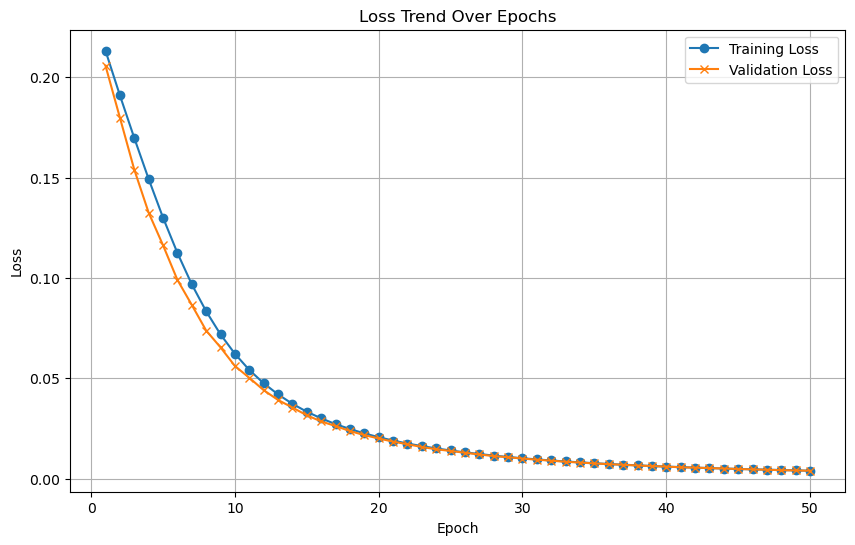

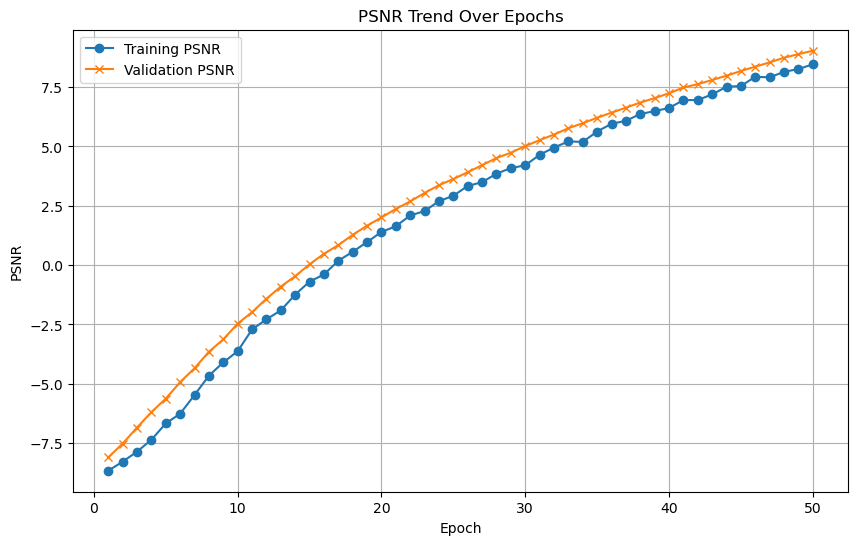

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/11 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6430
    Validation Batch [1/1], Loss: 2.6439
Validation Loss: 2.6439, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6439. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5879
    Validation Batch [1/1], Loss: 2.6438
Validation Loss: 2.6438, Validation Accuracy: 7.14%
Validation loss improved from 2.6439 to 2.6438. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5585
    Validation Batch [1/1], Loss: 2.6437
Validation Loss: 2.6437, Validation Accuracy: 7.14%
Validation loss improved from 2.6438 to 2.6437. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5296
    Validation Batch [1/1], Loss: 2.6436
Validation Loss: 2.6436, Validation Accuracy: 7.14%
Validation loss improved from 2.6437 to 2.6436. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] complete

Epoch [10/1000] completed, Average Training Loss: 2.3696
    Validation Batch [1/1], Loss: 2.6433
Validation Loss: 2.6433, Validation Accuracy: 7.14%
Validation loss improved from 2.6433 to 2.6433. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.3601
    Validation Batch [1/1], Loss: 2.6431
Validation Loss: 2.6431, Validation Accuracy: 7.14%
Validation loss improved from 2.6433 to 2.6431. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.3177
    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss improved from 2.6431 to 2.6428. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.3143
    Validation Batch [1/1], Loss: 2.6422
Validation Loss: 2.6422, Validation Accuracy: 7.14%
Validation loss improved from 2.6428 to 2.6422. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/10

Epoch [15/1000] completed, Average Training Loss: 2.2557
    Validation Batch [1/1], Loss: 2.6411
Validation Loss: 2.6411, Validation Accuracy: 7.14%
Validation loss improved from 2.6419 to 2.6411. Saving model...

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 2.2306
    Validation Batch [1/1], Loss: 2.6398
Validation Loss: 2.6398, Validation Accuracy: 7.14%
Validation loss improved from 2.6411 to 2.6398. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.2184
    Validation Batch [1/1], Loss: 2.6384
Validation Loss: 2.6384, Validation Accuracy: 7.14%
Validation loss improved from 2.6398 to 2.6384. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.1892
    Validation Batch [1/1], Loss: 2.6366
Validation Loss: 2.6366, Validation Accuracy: 7.14%
Validation loss improved from 2.6384 to 2.6366. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/10

Epoch [25/1000] completed, Average Training Loss: 2.0088
    Validation Batch [1/1], Loss: 2.6124
Validation Loss: 2.6124, Validation Accuracy: 21.43%
Validation loss improved from 2.6193 to 2.6124. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 1.9959
    Validation Batch [1/1], Loss: 2.6046
Validation Loss: 2.6046, Validation Accuracy: 15.71%
Validation loss improved from 2.6124 to 2.6046. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 1.9938
    Validation Batch [1/1], Loss: 2.5923
Validation Loss: 2.5923, Validation Accuracy: 15.71%
Validation loss improved from 2.6046 to 2.5923. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 1.9676
    Validation Batch [1/1], Loss: 2.5754
Validation Loss: 2.5754, Validation Accuracy: 14.29%
Validation loss improved from 2.5923 to 2.5754. Saving model...

LOG: Epoch [29/1000] - Training
Epoch [2

Epoch [30/1000] completed, Average Training Loss: 1.9279
    Validation Batch [1/1], Loss: 2.5341
Validation Loss: 2.5341, Validation Accuracy: 14.29%
Validation loss improved from 2.5583 to 2.5341. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 1.9041
    Validation Batch [1/1], Loss: 2.5096
Validation Loss: 2.5096, Validation Accuracy: 15.71%
Validation loss improved from 2.5341 to 2.5096. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 1.8932
    Validation Batch [1/1], Loss: 2.4782
Validation Loss: 2.4782, Validation Accuracy: 18.57%
Validation loss improved from 2.5096 to 2.4782. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 1.8643
    Validation Batch [1/1], Loss: 2.4372
Validation Loss: 2.4372, Validation Accuracy: 21.43%
Validation loss improved from 2.4782 to 2.4372. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [3

Epoch [38/1000] completed, Average Training Loss: 1.7698
    Validation Batch [1/1], Loss: 2.1857
Validation Loss: 2.1857, Validation Accuracy: 38.57%
Validation loss improved from 2.2303 to 2.1857. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.7333
    Validation Batch [1/1], Loss: 2.1127
Validation Loss: 2.1127, Validation Accuracy: 51.43%
Validation loss improved from 2.1857 to 2.1127. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.7382
    Validation Batch [1/1], Loss: 2.0511
Validation Loss: 2.0511, Validation Accuracy: 47.14%
Validation loss improved from 2.1127 to 2.0511. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.6974
    Validation Batch [1/1], Loss: 1.9820
Validation Loss: 1.9820, Validation Accuracy: 55.71%
Validation loss improved from 2.0511 to 1.9820. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [4

Epoch [43/1000] completed, Average Training Loss: 1.6560
    Validation Batch [1/1], Loss: 1.8600
Validation Loss: 1.8600, Validation Accuracy: 60.00%
Validation loss improved from 1.9107 to 1.8600. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 1.6346
    Validation Batch [1/1], Loss: 1.7914
Validation Loss: 1.7914, Validation Accuracy: 68.57%
Validation loss improved from 1.8600 to 1.7914. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 1.6241
    Validation Batch [1/1], Loss: 1.7790
Validation Loss: 1.7790, Validation Accuracy: 67.14%
Validation loss improved from 1.7914 to 1.7790. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 1.6122
    Validation Batch [1/1], Loss: 1.7092
Validation Loss: 1.7092, Validation Accuracy: 75.71%
Validation loss improved from 1.7790 to 1.7092. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [4

Epoch [52/1000] completed, Average Training Loss: 1.4953
    Validation Batch [1/1], Loss: 1.4965
Validation Loss: 1.4965, Validation Accuracy: 78.57%
Validation loss improved from 1.5550 to 1.4965. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 1.4756
    Validation Batch [1/1], Loss: 1.4786
Validation Loss: 1.4786, Validation Accuracy: 78.57%
Validation loss improved from 1.4965 to 1.4786. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.4606
    Validation Batch [1/1], Loss: 1.4698
Validation Loss: 1.4698, Validation Accuracy: 78.57%
Validation loss improved from 1.4786 to 1.4698. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 1.4285
    Validation Batch [1/1], Loss: 1.4355
Validation Loss: 1.4355, Validation Accuracy: 80.00%
Validation loss improved from 1.4698 to 1.4355. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [5

Epoch [58/1000] completed, Average Training Loss: 1.3826
    Validation Batch [1/1], Loss: 1.3708
Validation Loss: 1.3708, Validation Accuracy: 80.00%
Validation loss improved from 1.3731 to 1.3708. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 1.3788
    Validation Batch [1/1], Loss: 1.3729
Validation Loss: 1.3729, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 1.3566
    Validation Batch [1/1], Loss: 1.3005
Validation Loss: 1.3005, Validation Accuracy: 81.43%
Validation loss improved from 1.3708 to 1.3005. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 1.3271
    Validation Batch [1/1], Loss: 1.3037
Validation Loss: 1.3037, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Tra

    Validation Batch [1/1], Loss: 1.2473
Validation Loss: 1.2473, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 1.2454
    Validation Batch [1/1], Loss: 1.2166
Validation Loss: 1.2166, Validation Accuracy: 84.29%
Validation loss improved from 1.2446 to 1.2166. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 1.2449
    Validation Batch [1/1], Loss: 1.2110
Validation Loss: 1.2110, Validation Accuracy: 84.29%
Validation loss improved from 1.2166 to 1.2110. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.2396
    Validation Batch [1/1], Loss: 1.1915
Validation Loss: 1.1915, Validation Accuracy: 87.14%
Validation loss improved from 1.2110 to 1.1915. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.2263
    Validation Batch [1

Epoch [73/1000] completed, Average Training Loss: 1.1387
    Validation Batch [1/1], Loss: 1.1107
Validation Loss: 1.1107, Validation Accuracy: 87.14%
Validation loss improved from 1.1235 to 1.1107. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 1.1354
    Validation Batch [1/1], Loss: 1.0894
Validation Loss: 1.0894, Validation Accuracy: 88.57%
Validation loss improved from 1.1107 to 1.0894. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.1097
    Validation Batch [1/1], Loss: 1.0781
Validation Loss: 1.0781, Validation Accuracy: 90.00%
Validation loss improved from 1.0894 to 1.0781. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.1005
    Validation Batch [1/1], Loss: 1.0599
Validation Loss: 1.0599, Validation Accuracy: 90.00%
Validation loss improved from 1.0781 to 1.0599. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [7

Epoch [79/1000] completed, Average Training Loss: 1.0504
    Validation Batch [1/1], Loss: 0.9848
Validation Loss: 0.9848, Validation Accuracy: 91.43%
Validation loss improved from 1.0221 to 0.9848. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.0207
    Validation Batch [1/1], Loss: 0.9732
Validation Loss: 0.9732, Validation Accuracy: 91.43%
Validation loss improved from 0.9848 to 0.9732. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.0300
    Validation Batch [1/1], Loss: 1.0132
Validation Loss: 1.0132, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.0026
    Validation Batch [1/1], Loss: 0.9904
Validation Loss: 0.9904, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Tra

Epoch [87/1000] completed, Average Training Loss: 0.9349
    Validation Batch [1/1], Loss: 0.9009
Validation Loss: 0.9009, Validation Accuracy: 91.43%
Validation loss improved from 0.9133 to 0.9009. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 0.9157
    Validation Batch [1/1], Loss: 0.8801
Validation Loss: 0.8801, Validation Accuracy: 92.86%
Validation loss improved from 0.9009 to 0.8801. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 0.8910
    Validation Batch [1/1], Loss: 0.8577
Validation Loss: 0.8577, Validation Accuracy: 94.29%
Validation loss improved from 0.8801 to 0.8577. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 0.8912
    Validation Batch [1/1], Loss: 0.8385
Validation Loss: 0.8385, Validation Accuracy: 92.86%
Validation loss improved from 0.8577 to 0.8385. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [9

Epoch [94/1000] completed, Average Training Loss: 0.8506
    Validation Batch [1/1], Loss: 0.7907
Validation Loss: 0.7907, Validation Accuracy: 92.86%
Validation loss improved from 0.8061 to 0.7907. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 0.8214
    Validation Batch [1/1], Loss: 0.7912
Validation Loss: 0.7912, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 0.8052
    Validation Batch [1/1], Loss: 0.7703
Validation Loss: 0.7703, Validation Accuracy: 94.29%
Validation loss improved from 0.7907 to 0.7703. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 0.7856
    Validation Batch [1/1], Loss: 0.7772
Validation Loss: 0.7772, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Tra

    Validation Batch [1/1], Loss: 0.6896
Validation Loss: 0.6896, Validation Accuracy: 94.29%
Validation loss improved from 0.7203 to 0.6896. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 0.7051
    Validation Batch [1/1], Loss: 0.6883
Validation Loss: 0.6883, Validation Accuracy: 95.71%
Validation loss improved from 0.6896 to 0.6883. Saving model...

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 0.6965
    Validation Batch [1/1], Loss: 0.6575
Validation Loss: 0.6575, Validation Accuracy: 92.86%
Validation loss improved from 0.6883 to 0.6575. Saving model...

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Average Training Loss: 0.7053
    Validation Batch [1/1], Loss: 0.6521
Validation Loss: 0.6521, Validation Accuracy: 94.29%
Validation loss improved from 0.6575 to 0.6521. Saving model...

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 0.6619


Epoch [109/1000] completed, Average Training Loss: 0.6338
    Validation Batch [1/1], Loss: 0.5959
Validation Loss: 0.5959, Validation Accuracy: 92.86%
Validation loss improved from 0.6149 to 0.5959. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 0.6091
    Validation Batch [1/1], Loss: 0.5765
Validation Loss: 0.5765, Validation Accuracy: 92.86%
Validation loss improved from 0.5959 to 0.5765. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 0.5965
    Validation Batch [1/1], Loss: 0.6263
Validation Loss: 0.6263, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 0.6003
    Validation Batch [1/1], Loss: 0.5953
Validation Loss: 0.5953, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Av

    Validation Batch [1/1], Loss: 0.5505
Validation Loss: 0.5505, Validation Accuracy: 95.71%
Validation loss improved from 0.5617 to 0.5505. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 0.5586
    Validation Batch [1/1], Loss: 0.5211
Validation Loss: 0.5211, Validation Accuracy: 95.71%
Validation loss improved from 0.5505 to 0.5211. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 0.5399
    Validation Batch [1/1], Loss: 0.5505
Validation Loss: 0.5505, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 0.5313
    Validation Batch [1/1], Loss: 0.5660
Validation Loss: 0.5660, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 0.5074
    Validation Batch [1/1], Lo

Epoch [123/1000] completed, Average Training Loss: 0.4713
    Validation Batch [1/1], Loss: 0.4621
Validation Loss: 0.4621, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.4485
    Validation Batch [1/1], Loss: 0.4464
Validation Loss: 0.4464, Validation Accuracy: 92.86%
Validation loss improved from 0.4596 to 0.4464. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 0.4576
    Validation Batch [1/1], Loss: 0.4188
Validation Loss: 0.4188, Validation Accuracy: 94.29%
Validation loss improved from 0.4464 to 0.4188. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.4366
    Validation Batch [1/1], Loss: 0.4041
Validation Loss: 0.4041, Validation Accuracy: 97.14%
Validation loss improved from 0.4188 to 0.4041. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000

Epoch [130/1000] completed, Average Training Loss: 0.4025
    Validation Batch [1/1], Loss: 0.4018
Validation Loss: 0.4018, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 0.3995
    Validation Batch [1/1], Loss: 0.3709
Validation Loss: 0.3709, Validation Accuracy: 97.14%
Validation loss improved from 0.3991 to 0.3709. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 0.4216
    Validation Batch [1/1], Loss: 0.3774
Validation Loss: 0.3774, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 0.3929
    Validation Batch [1/1], Loss: 0.3762
Validation Loss: 0.3762, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training 


LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.3426
    Validation Batch [1/1], Loss: 0.3237
Validation Loss: 0.3237, Validation Accuracy: 97.14%
Validation loss improved from 0.3364 to 0.3237. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 0.3373
    Validation Batch [1/1], Loss: 0.3396
Validation Loss: 0.3396, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 0.3442
    Validation Batch [1/1], Loss: 0.3319
Validation Loss: 0.3319, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.3306
    Validation Batch [1/1], Loss: 0.3092
Validation Loss: 0.3092, Validation Accuracy: 97.14%
Validation loss improved from 0.3237 to 0.3092. Saving model...

LOG: Epoch [142/1000] - Train

Epoch [145/1000] completed, Average Training Loss: 0.3218
    Validation Batch [1/1], Loss: 0.3030
Validation Loss: 0.3030, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 0.2955
    Validation Batch [1/1], Loss: 0.3108
Validation Loss: 0.3108, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 0.2957
    Validation Batch [1/1], Loss: 0.2972
Validation Loss: 0.2972, Validation Accuracy: 95.71%
Validation loss improved from 0.3027 to 0.2972. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.2975
    Validation Batch [1/1], Loss: 0.2952
Validation Loss: 0.2952, Validation Accuracy: 95.71%
Validation loss improved from 0.2972 to 0.2952. Saving model...

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Av

    Validation Batch [1/1], Loss: 0.2587
Validation Loss: 0.2587, Validation Accuracy: 97.14%
Validation loss improved from 0.2686 to 0.2587. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.2672
    Validation Batch [1/1], Loss: 0.2708
Validation Loss: 0.2708, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.2672
    Validation Batch [1/1], Loss: 0.2559
Validation Loss: 0.2559, Validation Accuracy: 97.14%
Validation loss improved from 0.2587 to 0.2559. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.2623
    Validation Batch [1/1], Loss: 0.2487
Validation Loss: 0.2487, Validation Accuracy: 95.71%
Validation loss improved from 0.2559 to 0.2487. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 0.2767
    Validation 

Epoch [160/1000] completed, Average Training Loss: 0.2455
    Validation Batch [1/1], Loss: 0.2288
Validation Loss: 0.2288, Validation Accuracy: 95.71%
Validation loss improved from 0.2309 to 0.2288. Saving model...

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 0.2338
    Validation Batch [1/1], Loss: 0.2225
Validation Loss: 0.2225, Validation Accuracy: 97.14%
Validation loss improved from 0.2288 to 0.2225. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.2351
    Validation Batch [1/1], Loss: 0.2241
Validation Loss: 0.2241, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 0.2100
    Validation Batch [1/1], Loss: 0.2200
Validation Loss: 0.2200, Validation Accuracy: 97.14%
Validation loss improved from 0.2225 to 0.2200. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000

Epoch [165/1000] completed, Average Training Loss: 0.2243
    Validation Batch [1/1], Loss: 0.2144
Validation Loss: 0.2144, Validation Accuracy: 97.14%
Validation loss improved from 0.2147 to 0.2144. Saving model...

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 0.2086
    Validation Batch [1/1], Loss: 0.2144
Validation Loss: 0.2144, Validation Accuracy: 97.14%
Validation loss improved from 0.2144 to 0.2144. Saving model...

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 0.2078
    Validation Batch [1/1], Loss: 0.2044
Validation Loss: 0.2044, Validation Accuracy: 97.14%
Validation loss improved from 0.2144 to 0.2044. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 0.2136
    Validation Batch [1/1], Loss: 0.2108
Validation Loss: 0.2108, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000

    Validation Batch [1/1], Loss: 0.1901
Validation Loss: 0.1901, Validation Accuracy: 97.14%
Validation loss improved from 0.1916 to 0.1901. Saving model...

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 0.2004
    Validation Batch [1/1], Loss: 0.1824
Validation Loss: 0.1824, Validation Accuracy: 95.71%
Validation loss improved from 0.1901 to 0.1824. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 0.1947
    Validation Batch [1/1], Loss: 0.1988
Validation Loss: 0.1988, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.1854
    Validation Batch [1/1], Loss: 0.1872
Validation Loss: 0.1872, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.1829


    Validation Batch [1/1], Loss: 0.1767
Validation Loss: 0.1767, Validation Accuracy: 97.14%
Validation loss improved from 0.1824 to 0.1767. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.1763
    Validation Batch [1/1], Loss: 0.1799
Validation Loss: 0.1799, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.1682
    Validation Batch [1/1], Loss: 0.1870
Validation Loss: 0.1870, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 0.1665
    Validation Batch [1/1], Loss: 0.2082
Validation Loss: 0.2082, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 0.1809
    Validation Batch [1/1], Loss: 0.1843
Vali

Epoch [188/1000] completed, Average Training Loss: 0.1606
    Validation Batch [1/1], Loss: 0.1587
Validation Loss: 0.1587, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.1558
    Validation Batch [1/1], Loss: 0.1504
Validation Loss: 0.1504, Validation Accuracy: 95.71%
Validation loss improved from 0.1579 to 0.1504. Saving model...

LOG: Epoch [190/1000] - Training


Epoch [190/1000] completed, Average Training Loss: 0.1566
    Validation Batch [1/1], Loss: 0.1536
Validation Loss: 0.1536, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.1387
    Validation Batch [1/1], Loss: 0.1736
Validation Loss: 0.1736, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.1486
    Validation Batch [1/1], Loss: 0.1527
Validation Loss: 0.1527, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.1431
    Validation Batch [1/1], Loss: 0.1446
Validation Loss: 0.1446, Validation Accuracy: 98.57%
Validation loss improved from 0.1504 to 0.1446. Saving model...

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training 

Epoch [202/1000] completed, Average Training Loss: 0.1280


    Validation Batch [1/1], Loss: 0.1434
Validation Loss: 0.1434, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.1404
    Validation Batch [1/1], Loss: 0.1586
Validation Loss: 0.1586, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.1379
    Validation Batch [1/1], Loss: 0.1438
Validation Loss: 0.1438, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.1289
    Validation Batch [1/1], Loss: 0.1407
Validation Loss: 0.1407, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.1169
    Validation Batch [1/1], Loss: 0.1796
Validation Loss: 0.

Epoch [210/1000] completed, Average Training Loss: 0.1193
    Validation Batch [1/1], Loss: 0.1505
Validation Loss: 0.1505, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.1144
    Validation Batch [1/1], Loss: 0.1268
Validation Loss: 0.1268, Validation Accuracy: 97.14%
Validation loss improved from 0.1325 to 0.1268. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.1173
    Validation Batch [1/1], Loss: 0.1218
Validation Loss: 0.1218, Validation Accuracy: 97.14%
Validation loss improved from 0.1268 to 0.1218. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.1119
    Validation Batch [1/1], Loss: 0.1208
Validation Loss: 0.1208, Validation Accuracy: 98.57%
Validation loss improved from 0.1218 to 0.1208. Saving model...

LOG: Epoch [214/1000] - Training
Epoch [214/1000

Epoch [225/1000] completed, Average Training Loss: 0.0899
    Validation Batch [1/1], Loss: 0.1824
Validation Loss: 0.1824, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.1016
    Validation Batch [1/1], Loss: 0.1572
Validation Loss: 0.1572, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.0908
    Validation Batch [1/1], Loss: 0.1256
Validation Loss: 0.1256, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.0986
    Validation Batch [1/1], Loss: 0.1105
Validation Loss: 0.1105, Validation Accuracy: 95.71%
Validation loss improved from 0.1129 to 0.1105. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training 

Epoch [239/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 0.1314
Validation Loss: 0.1314, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.0773
    Validation Batch [1/1], Loss: 0.1133
Validation Loss: 0.1133, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.0779
    Validation Batch [1/1], Loss: 0.1175
Validation Loss: 0.1175, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.0790
    Validation Batch [1/1], Loss: 0.1120
Validation Loss: 0.1120, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.0838


Epoch [254/1000] completed, Average Training Loss: 0.0741
    Validation Batch [1/1], Loss: 0.1148
Validation Loss: 0.1148, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.0821
    Validation Batch [1/1], Loss: 0.0885
Validation Loss: 0.0885, Validation Accuracy: 97.14%
Validation loss improved from 0.0966 to 0.0885. Saving model...

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.0655
    Validation Batch [1/1], Loss: 0.0953
Validation Loss: 0.0953, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.0734
    Validation Batch [1/1], Loss: 0.0996
Validation Loss: 0.0996, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training

    Validation Batch [1/1], Loss: 0.0793
Validation Loss: 0.0793, Validation Accuracy: 98.57%
Validation loss improved from 0.0860 to 0.0793. Saving model...

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.0693
    Validation Batch [1/1], Loss: 0.0807
Validation Loss: 0.0807, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.0631
    Validation Batch [1/1], Loss: 0.0908
Validation Loss: 0.0908, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.0648
    Validation Batch [1/1], Loss: 0.0976
Validation Loss: 0.0976, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.0936
Vali

Epoch [283/1000] completed, Average Training Loss: 0.0620
    Validation Batch [1/1], Loss: 0.1309
Validation Loss: 0.1309, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.0574
    Validation Batch [1/1], Loss: 0.0978
Validation Loss: 0.0978, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.0599
    Validation Batch [1/1], Loss: 0.0967
Validation Loss: 0.0967, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.0507
    Validation Batch [1/1], Loss: 0.1150
Validation Loss: 0.1150, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.0596


Epoch [298/1000] completed, Average Training Loss: 0.0466
    Validation Batch [1/1], Loss: 0.0757
Validation Loss: 0.0757, Validation Accuracy: 98.57%
Validation loss improved from 0.0789 to 0.0757. Saving model...

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.0517
    Validation Batch [1/1], Loss: 0.0797
Validation Loss: 0.0797, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.0523
    Validation Batch [1/1], Loss: 0.0926
Validation Loss: 0.0926, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.0501
    Validation Batch [1/1], Loss: 0.1033
Validation Loss: 0.1033, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.0964
Validation Loss: 0.0964, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.0484
    Validation Batch [1/1], Loss: 0.0742
Validation Loss: 0.0742, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.0457
    Validation Batch [1/1], Loss: 0.0685
Validation Loss: 0.0685, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.0439
    Validation Batch [1/1], Loss: 0.0693
Validation Loss: 0.0693, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.0385
    Validation Batch [1/1], Loss: 0.0825
Validation Loss: 0.

Epoch [326/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.0650
Validation Loss: 0.0650, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.0374
    Validation Batch [1/1], Loss: 0.0578
Validation Loss: 0.0578, Validation Accuracy: 98.57%
Validation loss improved from 0.0639 to 0.0578. Saving model...

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.0388
    Validation Batch [1/1], Loss: 0.0626
Validation Loss: 0.0626, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.0680
Validation Loss: 0.0680, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training

Epoch [341/1000] completed, Average Training Loss: 0.0342
    Validation Batch [1/1], Loss: 0.0837
Validation Loss: 0.0837, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.0832
Validation Loss: 0.0832, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.0396
    Validation Batch [1/1], Loss: 0.0777
Validation Loss: 0.0777, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.0389
    Validation Batch [1/1], Loss: 0.0810
Validation Loss: 0.0810, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.034

Epoch [355/1000] completed, Average Training Loss: 0.0356
    Validation Batch [1/1], Loss: 0.1334
Validation Loss: 0.1334, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.1331
Validation Loss: 0.1331, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.0944
Validation Loss: 0.0944, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.0328
    Validation Batch [1/1], Loss: 0.0829
Validation Loss: 0.0829, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.032

Epoch [370/1000] completed, Average Training Loss: 0.0321
    Validation Batch [1/1], Loss: 0.0666
Validation Loss: 0.0666, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.0298
    Validation Batch [1/1], Loss: 0.0857
Validation Loss: 0.0857, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.0799
Validation Loss: 0.0799, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0363
    Validation Batch [1/1], Loss: 0.0584
Validation Loss: 0.0584, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.028

Epoch [384/1000] completed, Average Training Loss: 0.0297
    Validation Batch [1/1], Loss: 0.1046
Validation Loss: 0.1046, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.0282
    Validation Batch [1/1], Loss: 0.0715
Validation Loss: 0.0715, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.0286
    Validation Batch [1/1], Loss: 0.0802
Validation Loss: 0.0802, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.0262
    Validation Batch [1/1], Loss: 0.1027
Validation Loss: 0.1027, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.0284

    Validation Batch [1/1], Loss: 0.0528
Validation Loss: 0.0528, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.0252
    Validation Batch [1/1], Loss: 0.0795
Validation Loss: 0.0795, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0263
    Validation Batch [1/1], Loss: 0.0661
Validation Loss: 0.0661, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0265
    Validation Batch [1/1], Loss: 0.0566
Validation Loss: 0.0566, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0251
    Validation Batch [1/1], Loss: 0.0810
Validation Loss: 0.

Epoch [412/1000] completed, Average Training Loss: 0.0234
    Validation Batch [1/1], Loss: 0.0494
Validation Loss: 0.0494, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.0489
Validation Loss: 0.0489, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.0750
Validation Loss: 0.0750, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.0221
    Validation Batch [1/1], Loss: 0.1294
Validation Loss: 0.1294, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.025

Epoch [426/1000] completed, Average Training Loss: 0.0211
    Validation Batch [1/1], Loss: 0.0803
Validation Loss: 0.0803, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.0244
    Validation Batch [1/1], Loss: 0.0665
Validation Loss: 0.0665, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.0234
    Validation Batch [1/1], Loss: 0.0640
Validation Loss: 0.0640, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.0204
    Validation Batch [1/1], Loss: 0.0590
Validation Loss: 0.0590, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.025

    Validation Batch [1/1], Loss: 0.0685
Validation Loss: 0.0685, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.0624
Validation Loss: 0.0624, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.0210
    Validation Batch [1/1], Loss: 0.0600
Validation Loss: 0.0600, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.0944
Validation Loss: 0.0944, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.1187
Validation Loss

Epoch [455/1000] completed, Average Training Loss: 0.0226
    Validation Batch [1/1], Loss: 0.0914
Validation Loss: 0.0914, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.0211
    Validation Batch [1/1], Loss: 0.1242
Validation Loss: 0.1242, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.1018
Validation Loss: 0.1018, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.0188
    Validation Batch [1/1], Loss: 0.0746
Validation Loss: 0.0746, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.021

Epoch [469/1000] completed, Average Training Loss: 0.0191
    Validation Batch [1/1], Loss: 0.0541
Validation Loss: 0.0541, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.0193
    Validation Batch [1/1], Loss: 0.0471
Validation Loss: 0.0471, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.0178
    Validation Batch [1/1], Loss: 0.0687
Validation Loss: 0.0687, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.0870
Validation Loss: 0.0870, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.016

Epoch [483/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.0495
Validation Loss: 0.0495, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.0182
    Validation Batch [1/1], Loss: 0.0520
Validation Loss: 0.0520, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.0142
    Validation Batch [1/1], Loss: 0.0791
Validation Loss: 0.0791, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.0177
    Validation Batch [1/1], Loss: 0.0846
Validation Loss: 0.0846, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.0218

Epoch [498/1000] completed, Average Training Loss: 0.0171
    Validation Batch [1/1], Loss: 0.0479
Validation Loss: 0.0479, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.0178
    Validation Batch [1/1], Loss: 0.0579
Validation Loss: 0.0579, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0151
    Validation Batch [1/1], Loss: 0.0542
Validation Loss: 0.0542, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.0463
Validation Loss: 0.0463, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.016

Epoch [511/1000] completed, Average Training Loss: 0.0143
    Validation Batch [1/1], Loss: 0.0928
Validation Loss: 0.0928, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.0164
    Validation Batch [1/1], Loss: 0.0824
Validation Loss: 0.0824, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.0168
    Validation Batch [1/1], Loss: 0.0673
Validation Loss: 0.0673, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.0158
    Validation Batch [1/1], Loss: 0.0526
Validation Loss: 0.0526, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.015

Epoch [524/1000] completed, Average Training Loss: 0.0129
    Validation Batch [1/1], Loss: 0.0590
Validation Loss: 0.0590, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.0170
    Validation Batch [1/1], Loss: 0.0810
Validation Loss: 0.0810, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0149
    Validation Batch [1/1], Loss: 0.0790
Validation Loss: 0.0790, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0125
    Validation Batch [1/1], Loss: 0.0506
Validation Loss: 0.0506, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0135

Epoch [538/1000] completed, Average Training Loss: 0.0138
    Validation Batch [1/1], Loss: 0.0490
Validation Loss: 0.0490, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.0523
Validation Loss: 0.0523, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.0136
    Validation Batch [1/1], Loss: 0.0851
Validation Loss: 0.0851, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.0123
    Validation Batch [1/1], Loss: 0.0622
Validation Loss: 0.0622, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.012

Epoch [551/1000] completed, Average Training Loss: 0.0114
    Validation Batch [1/1], Loss: 0.1061
Validation Loss: 0.1061, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0141
    Validation Batch [1/1], Loss: 0.0905
Validation Loss: 0.0905, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.0131
    Validation Batch [1/1], Loss: 0.0595
Validation Loss: 0.0595, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0138
    Validation Batch [1/1], Loss: 0.0473
Validation Loss: 0.0473, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.012

Epoch [565/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.0676
Validation Loss: 0.0676, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [566/1000] - Training
Epoch [566/1000] completed, Average Training Loss: 0.0155
    Validation Batch [1/1], Loss: 0.1152
Validation Loss: 0.1152, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.0152
    Validation Batch [1/1], Loss: 0.0922
Validation Loss: 0.0922, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [568/1000] - Training
Epoch [568/1000] completed, Average Training Loss: 0.0135
    Validation Batch [1/1], Loss: 0.0631
Validation Loss: 0.0631, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0116
  

Epoch [579/1000] completed, Average Training Loss: 0.0121
    Validation Batch [1/1], Loss: 0.0544
Validation Loss: 0.0544, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [580/1000] - Training
Epoch [580/1000] completed, Average Training Loss: 0.0145
    Validation Batch [1/1], Loss: 0.0569
Validation Loss: 0.0569, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0111
    Validation Batch [1/1], Loss: 0.0770
Validation Loss: 0.0770, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0094
    Validation Batch [1/1], Loss: 0.0914
Validation Loss: 0.0914, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.011

Epoch [594/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.0446
Validation Loss: 0.0446, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0091
    Validation Batch [1/1], Loss: 0.0540
Validation Loss: 0.0540, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0097
    Validation Batch [1/1], Loss: 0.0560
Validation Loss: 0.0560, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Average Training Loss: 0.0119
    Validation Batch [1/1], Loss: 0.0535
Validation Loss: 0.0535, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [598/1000] - Training
Epoch [598/1000] completed, Average Training Loss: 0.011

Epoch [608/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.0413
Validation Loss: 0.0413, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0092
    Validation Batch [1/1], Loss: 0.0403
Validation Loss: 0.0403, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.0495
Validation Loss: 0.0495, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.0106
    Validation Batch [1/1], Loss: 0.0657
Validation Loss: 0.0657, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.008

Epoch [622/1000] completed, Average Training Loss: 0.0097
    Validation Batch [1/1], Loss: 0.0590
Validation Loss: 0.0590, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0074
    Validation Batch [1/1], Loss: 0.0519
Validation Loss: 0.0519, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.0106
    Validation Batch [1/1], Loss: 0.0482
Validation Loss: 0.0482, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [625/1000] - Training
Epoch [625/1000] completed, Average Training Loss: 0.0098
    Validation Batch [1/1], Loss: 0.0453
Validation Loss: 0.0453, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [626/1000] - Training
Epoch [626/1000] completed, Average Training Loss: 0.008

Epoch [636/1000] completed, Average Training Loss: 0.0095
    Validation Batch [1/1], Loss: 0.0488
Validation Loss: 0.0488, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [637/1000] - Training
Epoch [637/1000] completed, Average Training Loss: 0.0089
    Validation Batch [1/1], Loss: 0.0688
Validation Loss: 0.0688, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.0081
    Validation Batch [1/1], Loss: 0.0735
Validation Loss: 0.0735, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0105
    Validation Batch [1/1], Loss: 0.0753
Validation Loss: 0.0753, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0103
  

Epoch [648/1000] completed, Average Training Loss: 0.0091
    Validation Batch [1/1], Loss: 0.0708
Validation Loss: 0.0708, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [649/1000] - Training
Epoch [649/1000] completed, Average Training Loss: 0.0098
    Validation Batch [1/1], Loss: 0.0576
Validation Loss: 0.0576, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [650/1000] - Training
Epoch [650/1000] completed, Average Training Loss: 0.0093
    Validation Batch [1/1], Loss: 0.0533
Validation Loss: 0.0533, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [651/1000] - Training
Epoch [651/1000] completed, Average Training Loss: 0.0097
    Validation Batch [1/1], Loss: 0.0502
Validation Loss: 0.0502, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [652/1000] - Training
Epoch [652/1000] completed, Average Training Loss: 0.008

    Validation Batch [1/1], Loss: 0.0544
Validation Loss: 0.0544, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [662/1000] - Training
Epoch [662/1000] completed, Average Training Loss: 0.0093
    Validation Batch [1/1], Loss: 0.0714
Validation Loss: 0.0714, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [663/1000] - Training
Epoch [663/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.0808
Validation Loss: 0.0808, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [664/1000] - Training
Epoch [664/1000] completed, Average Training Loss: 0.0075
    Validation Batch [1/1], Loss: 0.0622
Validation Loss: 0.0622, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [665/1000] - Training
Epoch [665/1000] completed, Average Training Loss: 0.0083
    Validation Batch [1/1], Loss: 0.0416
Validation Loss

Epoch [674/1000] completed, Average Training Loss: 0.0078
    Validation Batch [1/1], Loss: 0.0672
Validation Loss: 0.0672, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [675/1000] - Training
Epoch [675/1000] completed, Average Training Loss: 0.0071
    Validation Batch [1/1], Loss: 0.0688
Validation Loss: 0.0688, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [676/1000] - Training
Epoch [676/1000] completed, Average Training Loss: 0.0097
    Validation Batch [1/1], Loss: 0.0568
Validation Loss: 0.0568, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [677/1000] - Training
Epoch [677/1000] completed, Average Training Loss: 0.0069
    Validation Batch [1/1], Loss: 0.0397
Validation Loss: 0.0397, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [678/1000] - Training
Epoch [678/1000] completed, Average Training Loss: 0.008

Epoch [687/1000] completed, Average Training Loss: 0.0068
    Validation Batch [1/1], Loss: 0.1395
Validation Loss: 0.1395, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [688/1000] - Training
Epoch [688/1000] completed, Average Training Loss: 0.0094
    Validation Batch [1/1], Loss: 0.0951
Validation Loss: 0.0951, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [689/1000] - Training
Epoch [689/1000] completed, Average Training Loss: 0.0072
    Validation Batch [1/1], Loss: 0.0634
Validation Loss: 0.0634, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [690/1000] - Training
Epoch [690/1000] completed, Average Training Loss: 0.0083
    Validation Batch [1/1], Loss: 0.0653
Validation Loss: 0.0653, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [691/1000] - Training
Epoch [691/1000] completed, Average Training Loss: 0.0081


Epoch [700/1000] completed, Average Training Loss: 0.0109
    Validation Batch [1/1], Loss: 0.0557
Validation Loss: 0.0557, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [701/1000] - Training
Epoch [701/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.0491
Validation Loss: 0.0491, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [702/1000] - Training
Epoch [702/1000] completed, Average Training Loss: 0.0068
    Validation Batch [1/1], Loss: 0.0492
Validation Loss: 0.0492, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [703/1000] - Training
Epoch [703/1000] completed, Average Training Loss: 0.0054
    Validation Batch [1/1], Loss: 0.0489
Validation Loss: 0.0489, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [704/1000] - Training
Epoch [704/1000] completed, Average Training Loss: 0.0073
  

Epoch [712/1000] completed, Average Training Loss: 0.0067
    Validation Batch [1/1], Loss: 0.0695
Validation Loss: 0.0695, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [713/1000] - Training
Epoch [713/1000] completed, Average Training Loss: 0.0070
    Validation Batch [1/1], Loss: 0.0839
Validation Loss: 0.0839, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [714/1000] - Training
Epoch [714/1000] completed, Average Training Loss: 0.0082
    Validation Batch [1/1], Loss: 0.0831
Validation Loss: 0.0831, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [715/1000] - Training
Epoch [715/1000] completed, Average Training Loss: 0.0072
    Validation Batch [1/1], Loss: 0.0787
Validation Loss: 0.0787, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [716/1000] - Training
Epoch [716/1000] completed, Average Training Loss: 0.007

Epoch [725/1000] completed, Average Training Loss: 0.0084
    Validation Batch [1/1], Loss: 0.0588
Validation Loss: 0.0588, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [726/1000] - Training
Epoch [726/1000] completed, Average Training Loss: 0.0066
    Validation Batch [1/1], Loss: 0.0401
Validation Loss: 0.0401, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [727/1000] - Training
Epoch [727/1000] completed, Average Training Loss: 0.0070
    Validation Batch [1/1], Loss: 0.0384
Validation Loss: 0.0384, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [728/1000] - Training
Epoch [728/1000] completed, Average Training Loss: 0.0082
    Validation Batch [1/1], Loss: 0.0418
Validation Loss: 0.0418, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [729/1000] - Training
Epoch [729/1000] completed, Average Training Loss: 0.008

Epoch [734/1000] completed, Average Training Loss: 0.0074
    Validation Batch [1/1], Loss: 0.0852
Validation Loss: 0.0852, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [735/1000] - Training
Epoch [735/1000] completed, Average Training Loss: 0.0066
    Validation Batch [1/1], Loss: 0.1116
Validation Loss: 0.1116, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [736/1000] - Training
Epoch [736/1000] completed, Average Training Loss: 0.0069
    Validation Batch [1/1], Loss: 0.1089
Validation Loss: 0.1089, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [737/1000] - Training
Epoch [737/1000] completed, Average Training Loss: 0.0067
    Validation Batch [1/1], Loss: 0.0862
Validation Loss: 0.0862, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [738/1000] - Training
Epoch [738/1000] completed, Average Training Loss: 0.008

Epoch [747/1000] completed, Average Training Loss: 0.0058
    Validation Batch [1/1], Loss: 0.0599
Validation Loss: 0.0599, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [748/1000] - Training
Epoch [748/1000] completed, Average Training Loss: 0.0066
    Validation Batch [1/1], Loss: 0.0745
Validation Loss: 0.0745, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [749/1000] - Training
Epoch [749/1000] completed, Average Training Loss: 0.0100
    Validation Batch [1/1], Loss: 0.0531
Validation Loss: 0.0531, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [750/1000] - Training
Epoch [750/1000] completed, Average Training Loss: 0.0068
    Validation Batch [1/1], Loss: 0.0376
Validation Loss: 0.0376, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [751/1000] - Training
Epoch [751/1000] completed, Average Training Loss: 0.007

Epoch [761/1000] completed, Average Training Loss: 0.0059
    Validation Batch [1/1], Loss: 0.0511
Validation Loss: 0.0511, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [762/1000] - Training
Epoch [762/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0588
Validation Loss: 0.0588, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [763/1000] - Training
Epoch [763/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.0557
Validation Loss: 0.0557, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [764/1000] - Training
Epoch [764/1000] completed, Average Training Loss: 0.0070
    Validation Batch [1/1], Loss: 0.0568
Validation Loss: 0.0568, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [765/1000] - Training
Epoch [765/1000] completed, Average Training Loss: 0.007

Epoch [774/1000] completed, Average Training Loss: 0.0062
    Validation Batch [1/1], Loss: 0.0989
Validation Loss: 0.0989, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [775/1000] - Training
Epoch [775/1000] completed, Average Training Loss: 0.0074
    Validation Batch [1/1], Loss: 0.0684
Validation Loss: 0.0684, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [776/1000] - Training
Epoch [776/1000] completed, Average Training Loss: 0.0062
    Validation Batch [1/1], Loss: 0.0388
Validation Loss: 0.0388, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [777/1000] - Training
Epoch [777/1000] completed, Average Training Loss: 0.0067
    Validation Batch [1/1], Loss: 0.0349
Validation Loss: 0.0349, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [778/1000] - Training
Epoch [778/1000] completed, Average Training Loss: 0.005

Epoch [786/1000] completed, Average Training Loss: 0.0064
    Validation Batch [1/1], Loss: 0.0671
Validation Loss: 0.0671, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [787/1000] - Training
Epoch [787/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0548
Validation Loss: 0.0548, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [788/1000] - Training
Epoch [788/1000] completed, Average Training Loss: 0.0053
    Validation Batch [1/1], Loss: 0.0651
Validation Loss: 0.0651, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [789/1000] - Training
Epoch [789/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.0738
Validation Loss: 0.0738, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [790/1000] - Training
Epoch [790/1000] completed, Average Training Loss: 0.006

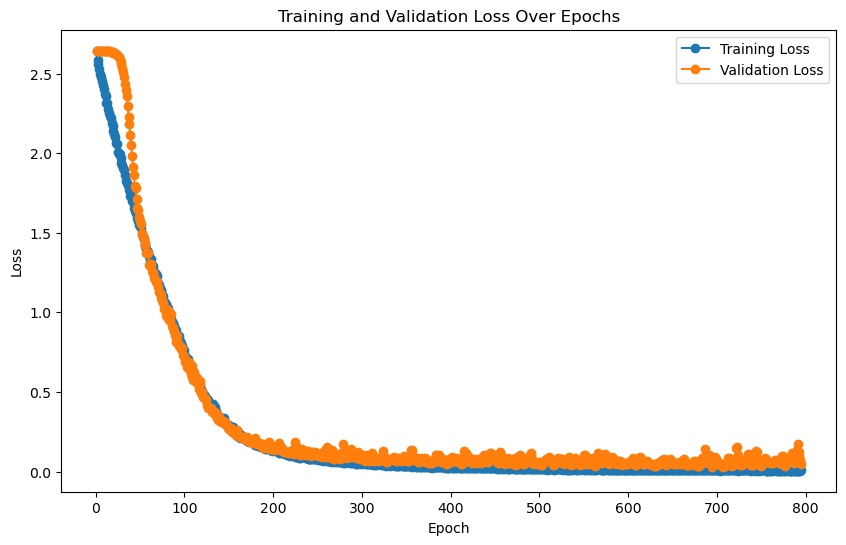

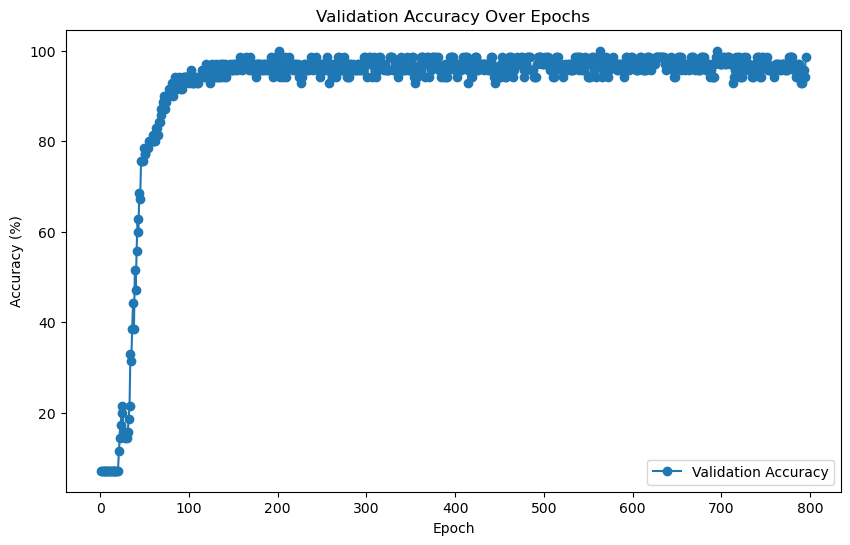


Evaluating on the test set...
    Test Batch [1/11], Loss: 0.0011

Final Test Loss: 0.0561, Test Accuracy: 98.55%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/11 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)

LOG: Training features shape: (560, 64), Training labels shape: (560,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (2618, 64), Test labels shape: (2618,)

LOG: Training Logistic Regression model...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       0.80      0.80      0.80         5
           3       1.00      0.80      0.89         5
           4       1.00      0.80      0.89         5
           5       0.40      0.40      0.40         5
           6       1.00      0.80      0.89         5
           7       0.83      1.00      0.91         5
           8       0.60      0.60      0.60         5
           9       0.67      0.80      0.73         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5

    accuracy                          

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)
Train reps shape: (560, 64)
Train labels shape: (560,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (2618, 64)
Test labels shape: (2618,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6739  |  Val Loss: 2.6246
Validation loss improved from inf to 2.6246.
[Epoch 2/1000] Train Loss: 2.6237  |  Val Loss: 2.6119
Validation loss improved from 2.6246 to 2.6119.
[Epoch 3/1000] Train Loss: 2.6047  |  Val Loss: 2.5905
Validation loss improved from 2.6119 to 2.5905.
[Epoch 4/1000] Train Loss: 2.5827  |  Val Loss: 2.5698
Validation loss improved from 2.5905 to 2.5698.
[Epoch 5/1000] Train Loss: 2.5591  |  Val Loss: 2.5468
Validation loss improved from 2.5698 to 2.5468.
[Epoch 6/1000] Train Loss: 2.5344  |  Val Loss: 2.5154
Validation loss improved from 2.5468 to 2.5154.
[Epoch 7/1000] Train Loss: 2.4960  |  Val Loss: 2.4766
Validation loss improved from 2.5154 to 2.4766.
[Epoch 8/1000] Train Loss: 2.4563  |  Val Loss: 2.4408
Validation loss improved from 2.4766 to 2.4408.


[Epoch 9/1000] Train Loss: 2.4046  |  Val Loss: 2.3724
Validation loss improved from 2.4408 to 2.3724.


[Epoch 10/1000] Train Loss: 2.3402  |  Val Loss: 2.2951
Validation loss improved from 2.3724 to 2.2951.
[Epoch 11/1000] Train Loss: 2.2592  |  Val Loss: 2.2139
Validation loss improved from 2.2951 to 2.2139.
[Epoch 12/1000] Train Loss: 2.1830  |  Val Loss: 2.1364
Validation loss improved from 2.2139 to 2.1364.


[Epoch 13/1000] Train Loss: 2.1046  |  Val Loss: 2.0564
Validation loss improved from 2.1364 to 2.0564.
[Epoch 14/1000] Train Loss: 2.0248  |  Val Loss: 1.9722
Validation loss improved from 2.0564 to 1.9722.
[Epoch 15/1000] Train Loss: 1.9418  |  Val Loss: 1.8933
Validation loss improved from 1.9722 to 1.8933.
[Epoch 16/1000] Train Loss: 1.8673  |  Val Loss: 1.8288
Validation loss improved from 1.8933 to 1.8288.
[Epoch 17/1000] Train Loss: 1.8087  |  Val Loss: 1.7570
Validation loss improved from 1.8288 to 1.7570.
[Epoch 18/1000] Train Loss: 1.7570  |  Val Loss: 1.7094
Validation loss improved from 1.7570 to 1.7094.
[Epoch 19/1000] Train Loss: 1.7107  |  Val Loss: 1.6620
Validation loss improved from 1.7094 to 1.6620.
[Epoch 20/1000] Train Loss: 1.6607  |  Val Loss: 1.6249
Validation loss improved from 1.6620 to 1.6249.


[Epoch 21/1000] Train Loss: 1.6281  |  Val Loss: 1.5785
Validation loss improved from 1.6249 to 1.5785.
[Epoch 22/1000] Train Loss: 1.5838  |  Val Loss: 1.5508
Validation loss improved from 1.5785 to 1.5508.
[Epoch 23/1000] Train Loss: 1.5405  |  Val Loss: 1.5379
Validation loss improved from 1.5508 to 1.5379.


[Epoch 24/1000] Train Loss: 1.5197  |  Val Loss: 1.5394
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 25/1000] Train Loss: 1.4998  |  Val Loss: 1.4880
Validation loss improved from 1.5379 to 1.4880.
[Epoch 26/1000] Train Loss: 1.4909  |  Val Loss: 1.4499
Validation loss improved from 1.4880 to 1.4499.
[Epoch 27/1000] Train Loss: 1.4690  |  Val Loss: 1.4634
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 28/1000] Train Loss: 1.4424  |  Val Loss: 1.4132
Validation loss improved from 1.4499 to 1.4132.
[Epoch 29/1000] Train Loss: 1.4283  |  Val Loss: 1.3972
Validation loss improved from 1.4132 to 1.3972.
[Epoch 30/1000] Train Loss: 1.4120  |  Val Loss: 1.3945
Validation loss improved from 1.3972 to 1.3945.
[Epoch 31/1000] Train Loss: 1.3927  |  Val Loss: 1.4049
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 32/1000] Train Loss: 1.3731  |  Val Loss: 1.4028
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 33/1000] Train Loss: 1.3815  |  V

[Epoch 34/1000] Train Loss: 1.3747  |  Val Loss: 1.3534
Validation loss improved from 1.3617 to 1.3534.
[Epoch 35/1000] Train Loss: 1.3467  |  Val Loss: 1.3242
Validation loss improved from 1.3534 to 1.3242.
[Epoch 36/1000] Train Loss: 1.3523  |  Val Loss: 1.3449
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 37/1000] Train Loss: 1.3377  |  Val Loss: 1.3065
Validation loss improved from 1.3242 to 1.3065.
[Epoch 38/1000] Train Loss: 1.3181  |  Val Loss: 1.3537
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 1.3206  |  Val Loss: 1.2959
Validation loss improved from 1.3065 to 1.2959.
[Epoch 40/1000] Train Loss: 1.3262  |  Val Loss: 1.2979
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 1.2990  |  Val Loss: 1.3042
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 42/1000] Train Loss: 1.3195  |  Val Loss: 1.3732
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 43/1000] Train Loss: 1.3219  |  Val Loss: 1.2825
Validation loss improved from 1.2959 to 1.2825.
[Epoch 44/1000] Train Loss: 1.3616  |  Val Loss: 1.3686
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 45/1000] Train Loss: 1.3460  |  Val Loss: 1.2668
Validation loss improved from 1.2825 to 1.2668.
[Epoch 46/1000] Train Loss: 1.2787  |  Val Loss: 1.2808
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 47/1000] Train Loss: 1.2739  |  Val Loss: 1.2622
Validation loss improved from 1.2668 to 1.2622.
[Epoch 48/1000] Train Loss: 1.2774  |  Val Loss: 1.2592
Validation loss improved from 1.2622 to 1.2592.
[Epoch 49/1000] Train Loss: 1.2623  |  Val Loss: 1.2684
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 50/1000] Train Loss: 1.2533  |  Val Loss: 1.2582
Validation loss improved from 1.2592 to 1.2582.
[Epoch 51/1000] Train Loss: 1.2681  |  Val Loss: 1.2348
Validation loss improved from 1.2582 to 1.2348.
[Epoch 52/1000] Train Loss: 1.2492  |  Val Loss: 1.2396
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 1.2406  |  Val Loss: 1.2576
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 54/1000] Train Loss: 1.2360  |  Val Loss: 1.2326
Validation loss improved from 1.2348 to 1.2326.
[Epoch 55/1000] Train Loss: 1.2361  |  Val Loss: 1.2231
Validation loss improved from 1.2326 to 1.2231.


[Epoch 56/1000] Train Loss: 1.2169  |  Val Loss: 1.2432
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 1.2263  |  Val Loss: 1.2311
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 1.2183  |  Val Loss: 1.2188
Validation loss improved from 1.2231 to 1.2188.


[Epoch 59/1000] Train Loss: 1.2070  |  Val Loss: 1.2376
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 1.2112  |  Val Loss: 1.2112
Validation loss improved from 1.2188 to 1.2112.
[Epoch 61/1000] Train Loss: 1.2097  |  Val Loss: 1.2048
Validation loss improved from 1.2112 to 1.2048.
[Epoch 62/1000] Train Loss: 1.2344  |  Val Loss: 1.2254
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 1.2416  |  Val Loss: 1.3070
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 64/1000] Train Loss: 1.2243  |  Val Loss: 1.3318
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 65/1000] Train Loss: 1.2356  |  Val Loss: 1.2375
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 66/1000] Train Loss: 1.2063  |  Val Loss: 1.2066
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 67/1000] Train Loss: 1.1985  |  Val Loss: 1.2279
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 68/1000] Train Loss: 1.2011  |  Val Loss: 1.2146
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 69/1000] Train Loss: 1.1837  |  Val Loss: 1.2039
Validation loss improved from 1.2048 to 1.2039.
[Epoch 70/1000] Train Loss: 1.1847  |  Val Loss: 1.1945
Validation loss improved from 1.2039 to 1.1945.
[Epoch 71/1000] Train Loss: 1.1943  |  Val Loss: 1.2529
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 72/1000] Train Loss: 1.1977  |  Val Loss: 1.2100
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 73/1000] Train Loss: 1.2083  |  Val Loss: 1.1918
Validation loss improved from 1.1945 to 1.1918.
[Epoch 74/1000] Train Loss: 1.1800  |  Val Loss: 1.1816
Validation loss improved from 1.1918 to 1.1816.
[Epoch 75/1000] Train Loss: 1.1706  |  Val Loss: 1.1895
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 76/1000] Train Loss: 1.1666  |  Val Loss: 1.1811
Validation loss improved from 1.1816 to 1.1811.
[Epoch 77/1000] Train Loss: 1.1684  |  Val Loss: 1.2063
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 78/1000] Train Loss: 1.1672  |  V

[Epoch 79/1000] Train Loss: 1.1624  |  Val Loss: 1.1970
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 80/1000] Train Loss: 1.1709  |  Val Loss: 1.1816
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 81/1000] Train Loss: 1.1711  |  Val Loss: 1.1706
Validation loss improved from 1.1811 to 1.1706.
[Epoch 82/1000] Train Loss: 1.1673  |  Val Loss: 1.1830
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Train Loss: 1.1769  |  Val Loss: 1.1862
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 1.2136  |  Val Loss: 1.2614
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 85/1000] Train Loss: 1.1773  |  Val Loss: 1.2060
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 86/1000] Train Loss: 1.1741  |  Val Loss: 1.1988
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 87/1000] Train Loss: 1.1485  |  Val Loss: 1.1717
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 88/1000] 

[Epoch 91/1000] Train Loss: 1.2052  |  Val Loss: 1.3726
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 92/1000] Train Loss: 1.1758  |  Val Loss: 1.2479
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 93/1000] Train Loss: 1.1362  |  Val Loss: 1.1852
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 94/1000] Train Loss: 1.1337  |  Val Loss: 1.1793
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 95/1000] Train Loss: 1.1275  |  Val Loss: 1.1531
Validation loss improved from 1.1706 to 1.1531.
[Epoch 96/1000] Train Loss: 1.1265  |  Val Loss: 1.1483
Validation loss improved from 1.1531 to 1.1483.
[Epoch 97/1000] Train Loss: 1.1264  |  Val Loss: 1.1434
Validation loss improved from 1.1483 to 1.1434.
[Epoch 98/1000] Train Loss: 1.1417  |  Val Loss: 1.1605
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 99/1000] Train Loss: 1.1494  |  Val Loss: 1.1957
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 100/1000] Train L

[Epoch 102/1000] Train Loss: 1.1690  |  Val Loss: 1.1582
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 103/1000] Train Loss: 1.1369  |  Val Loss: 1.1695
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 104/1000] Train Loss: 1.1638  |  Val Loss: 1.1604
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 105/1000] Train Loss: 1.1264  |  Val Loss: 1.1959
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 106/1000] Train Loss: 1.1316  |  Val Loss: 1.2216
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 107/1000] Train Loss: 1.1295  |  Val Loss: 1.1656
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 108/1000] Train Loss: 1.1278  |  Val Loss: 1.1430
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 109/1000] Train Loss: 1.1176  |  Val Loss: 1.1658
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 110/1000] Train Loss: 1.1269  |  Val Loss: 1.1252
Validation loss improved from 1.1425 to 1.1252.
[Epoch 

[Epoch 113/1000] Train Loss: 1.1181  |  Val Loss: 1.1454
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 114/1000] Train Loss: 1.1013  |  Val Loss: 1.1397
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 115/1000] Train Loss: 1.1185  |  Val Loss: 1.1336
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 116/1000] Train Loss: 1.1035  |  Val Loss: 1.1283
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 117/1000] Train Loss: 1.1300  |  Val Loss: 1.1352
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 118/1000] Train Loss: 1.1159  |  Val Loss: 1.1992
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 119/1000] Train Loss: 1.1232  |  Val Loss: 1.1982
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 120/1000] Train Loss: 1.0892  |  Val Loss: 1.1277
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 121/1000] Train Loss: 1.0988  |  Val Loss: 1.1575
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 125/1000] Train Loss: 1.0996  |  Val Loss: 1.1197
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 126/1000] Train Loss: 1.1118  |  Val Loss: 1.3029
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 127/1000] Train Loss: 1.1428  |  Val Loss: 1.2313
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 128/1000] Train Loss: 1.1223  |  Val Loss: 1.1084
Validation loss improved from 1.1117 to 1.1084.
[Epoch 129/1000] Train Loss: 1.0866  |  Val Loss: 1.1139
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 130/1000] Train Loss: 1.0767  |  Val Loss: 1.1176
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 131/1000] Train Loss: 1.0900  |  Val Loss: 1.1466
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 132/1000] Train Loss: 1.0786  |  Val Loss: 1.1091
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 133/1000] Train Loss: 1.1047  |  Val Loss: 1.1110
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 136/1000] Train Loss: 1.0585  |  Val Loss: 1.1041
Validation loss improved from 1.1084 to 1.1041.
[Epoch 137/1000] Train Loss: 1.0515  |  Val Loss: 1.1280
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 138/1000] Train Loss: 1.0831  |  Val Loss: 1.0928
Validation loss improved from 1.1041 to 1.0928.
[Epoch 139/1000] Train Loss: 1.0968  |  Val Loss: 1.1144
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 140/1000] Train Loss: 1.0665  |  Val Loss: 1.0850
Validation loss improved from 1.0928 to 1.0850.
[Epoch 141/1000] Train Loss: 1.0510  |  Val Loss: 1.1153
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 1.0512  |  Val Loss: 1.0856
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 143/1000] Train Loss: 1.0546  |  Val Loss: 1.0945
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 144/1000] Train Loss: 1.0716  |  Val Loss: 1.1162
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 145/1000] Tr

[Epoch 148/1000] Train Loss: 1.0575  |  Val Loss: 1.0827
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 149/1000] Train Loss: 1.0433  |  Val Loss: 1.0824
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 150/1000] Train Loss: 1.0504  |  Val Loss: 1.1000
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 151/1000] Train Loss: 1.0242  |  Val Loss: 1.0489
Validation loss improved from 1.0819 to 1.0489.
[Epoch 152/1000] Train Loss: 1.0244  |  Val Loss: 1.0682
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 153/1000] Train Loss: 1.0353  |  Val Loss: 1.1014
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 154/1000] Train Loss: 1.0415  |  Val Loss: 1.0662
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 155/1000] Train Loss: 1.0133  |  Val Loss: 1.0738
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 156/1000] Train Loss: 1.0327  |  Val Loss: 1.0599
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 159/1000] Train Loss: 1.0483  |  Val Loss: 1.0594
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 160/1000] Train Loss: 1.0236  |  Val Loss: 1.1075
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 161/1000] Train Loss: 1.0232  |  Val Loss: 1.1750
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 162/1000] Train Loss: 1.1198  |  Val Loss: 1.0398
Validation loss improved from 1.0489 to 1.0398.
[Epoch 163/1000] Train Loss: 1.0801  |  Val Loss: 1.0225
Validation loss improved from 1.0398 to 1.0225.
[Epoch 164/1000] Train Loss: 1.1055  |  Val Loss: 1.1488
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 165/1000] Train Loss: 1.0536  |  Val Loss: 1.2143
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 166/1000] Train Loss: 1.0375  |  Val Loss: 1.0441
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 167/1000] Train Loss: 1.0093  |  Val Loss: 1.0319
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 168/1

[Epoch 171/1000] Train Loss: 0.9686  |  Val Loss: 1.0161
Validation loss improved from 1.0225 to 1.0161.
[Epoch 172/1000] Train Loss: 0.9738  |  Val Loss: 1.0205
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 173/1000] Train Loss: 0.9796  |  Val Loss: 1.0182
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 174/1000] Train Loss: 0.9521  |  Val Loss: 1.0184
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 175/1000] Train Loss: 0.9591  |  Val Loss: 1.0557
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 176/1000] Train Loss: 0.9829  |  Val Loss: 1.1277
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 177/1000] Train Loss: 0.9980  |  Val Loss: 1.1194
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 178/1000] Train Loss: 0.9760  |  Val Loss: 1.0350
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 179/1000] Train Loss: 0.9850  |  Val Loss: 0.9856
Validation loss improved from 1.0161 to 0.9856.
[Epoch 180/10

[Epoch 182/1000] Train Loss: 0.9745  |  Val Loss: 0.9932
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 183/1000] Train Loss: 0.9397  |  Val Loss: 1.0155
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 184/1000] Train Loss: 0.9333  |  Val Loss: 1.0492
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 185/1000] Train Loss: 0.9650  |  Val Loss: 1.0459
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 186/1000] Train Loss: 0.9358  |  Val Loss: 0.9689
Validation loss improved from 0.9856 to 0.9689.
[Epoch 187/1000] Train Loss: 0.9143  |  Val Loss: 1.0188
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 188/1000] Train Loss: 0.9523  |  Val Loss: 0.9639
Validation loss improved from 0.9689 to 0.9639.
[Epoch 189/1000] Train Loss: 0.9313  |  Val Loss: 0.9650
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 190/1000] Train Loss: 0.9620  |  Val Loss: 0.9833
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 191/10

[Epoch 193/1000] Train Loss: 0.9008  |  Val Loss: 1.0296
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 194/1000] Train Loss: 0.8969  |  Val Loss: 0.9587
Validation loss improved from 0.9596 to 0.9587.
[Epoch 195/1000] Train Loss: 0.8815  |  Val Loss: 0.9520
Validation loss improved from 0.9587 to 0.9520.
[Epoch 196/1000] Train Loss: 0.8825  |  Val Loss: 0.9196
Validation loss improved from 0.9520 to 0.9196.
[Epoch 197/1000] Train Loss: 0.9275  |  Val Loss: 0.9992
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 198/1000] Train Loss: 0.9159  |  Val Loss: 0.9334
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 199/1000] Train Loss: 0.8957  |  Val Loss: 1.0321
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 200/1000] Train Loss: 0.9520  |  Val Loss: 0.9357
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 201/1000] Train Loss: 0.8766  |  Val Loss: 1.2239
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 202/1000] Tr

[Epoch 204/1000] Train Loss: 0.8822  |  Val Loss: 0.9181
Validation loss improved from 0.9196 to 0.9181.
[Epoch 205/1000] Train Loss: 0.8533  |  Val Loss: 0.9006
Validation loss improved from 0.9181 to 0.9006.
[Epoch 206/1000] Train Loss: 0.8473  |  Val Loss: 0.9254
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 207/1000] Train Loss: 0.8562  |  Val Loss: 0.9128
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 208/1000] Train Loss: 0.8395  |  Val Loss: 0.8849
Validation loss improved from 0.9006 to 0.8849.
[Epoch 209/1000] Train Loss: 0.8452  |  Val Loss: 0.8926
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 210/1000] Train Loss: 0.8668  |  Val Loss: 0.9608
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 211/1000] Train Loss: 0.8874  |  Val Loss: 0.9457
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 212/1000] Train Loss: 0.8742  |  Val Loss: 0.8612
Validation loss improved from 0.8849 to 0.8612.
[Epoch 213/1000] Train Lo

[Epoch 215/1000] Train Loss: 0.7910  |  Val Loss: 0.8529
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 216/1000] Train Loss: 0.7814  |  Val Loss: 0.8462
Validation loss improved from 0.8521 to 0.8462.
[Epoch 217/1000] Train Loss: 0.7968  |  Val Loss: 0.8585
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 218/1000] Train Loss: 0.7898  |  Val Loss: 0.8031
Validation loss improved from 0.8462 to 0.8031.
[Epoch 219/1000] Train Loss: 0.7826  |  Val Loss: 0.9348
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 220/1000] Train Loss: 0.8580  |  Val Loss: 0.9472
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 221/1000] Train Loss: 0.8514  |  Val Loss: 0.9421
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 222/1000] Train Loss: 0.8583  |  Val Loss: 0.9002
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 223/1000] Train Loss: 0.8139  |  Val Loss: 0.8246
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 224/10

[Epoch 226/1000] Train Loss: 0.7973  |  Val Loss: 0.8656
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 227/1000] Train Loss: 0.7723  |  Val Loss: 0.9012
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 228/1000] Train Loss: 0.7487  |  Val Loss: 0.7780
Validation loss improved from 0.8031 to 0.7780.
[Epoch 229/1000] Train Loss: 0.7498  |  Val Loss: 0.7839
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 230/1000] Train Loss: 0.7547  |  Val Loss: 0.7949
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 231/1000] Train Loss: 0.7446  |  Val Loss: 0.7936
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 232/1000] Train Loss: 0.7293  |  Val Loss: 0.7841
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 233/1000] Train Loss: 0.7111  |  Val Loss: 0.7692
Validation loss improved from 0.7780 to 0.7692.
[Epoch 234/1000] Train Loss: 0.7098  |  Val Loss: 0.7732
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 235/10

[Epoch 237/1000] Train Loss: 0.6962  |  Val Loss: 0.7665
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 238/1000] Train Loss: 0.7024  |  Val Loss: 0.7521
Validation loss improved from 0.7640 to 0.7521.
[Epoch 239/1000] Train Loss: 0.7052  |  Val Loss: 0.7880
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 240/1000] Train Loss: 0.7010  |  Val Loss: 0.7746
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 241/1000] Train Loss: 0.6817  |  Val Loss: 0.7671
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 242/1000] Train Loss: 0.7058  |  Val Loss: 0.7765
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 243/1000] Train Loss: 0.6854  |  Val Loss: 0.8064
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 244/1000] Train Loss: 0.6948  |  Val Loss: 0.7259
Validation loss improved from 0.7521 to 0.7259.
[Epoch 245/1000] Train Loss: 0.7308  |  Val Loss: 0.7777
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 246/10

[Epoch 249/1000] Train Loss: 0.6857  |  Val Loss: 0.8580
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 250/1000] Train Loss: 0.7060  |  Val Loss: 0.8173
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 251/1000] Train Loss: 0.6685  |  Val Loss: 0.7442
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 252/1000] Train Loss: 0.6675  |  Val Loss: 0.7470
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 253/1000] Train Loss: 0.6474  |  Val Loss: 0.7114
Validation loss improved from 0.7259 to 0.7114.
[Epoch 254/1000] Train Loss: 0.6444  |  Val Loss: 0.7244
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 255/1000] Train Loss: 0.6553  |  Val Loss: 0.7499
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 256/1000] Train Loss: 0.7144  |  Val Loss: 0.8843
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 257/1000] Train Loss: 0.7169  |  Val Loss: 0.7398
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 260/1000] Train Loss: 0.6333  |  Val Loss: 0.6908
Validation loss improved from 0.7114 to 0.6908.
[Epoch 261/1000] Train Loss: 0.6369  |  Val Loss: 0.7615
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 262/1000] Train Loss: 0.6569  |  Val Loss: 0.7127
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 263/1000] Train Loss: 0.6374  |  Val Loss: 0.7057
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 264/1000] Train Loss: 0.6221  |  Val Loss: 0.7024
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 265/1000] Train Loss: 0.6176  |  Val Loss: 0.6982
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 266/1000] Train Loss: 0.6120  |  Val Loss: 0.6947
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 267/1000] Train Loss: 0.6268  |  Val Loss: 0.8433
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 268/1000] Train Loss: 0.6421  |  Val Loss: 0.6873
Validation loss improved from 0.6908 to 0.6873.
[Epoch 269/10

[Epoch 272/1000] Train Loss: 0.7124  |  Val Loss: 0.7334
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 273/1000] Train Loss: 0.6246  |  Val Loss: 0.7212
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 274/1000] Train Loss: 0.6137  |  Val Loss: 0.7606
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 275/1000] Train Loss: 0.6844  |  Val Loss: 0.8826
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 276/1000] Train Loss: 0.6621  |  Val Loss: 0.7705
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 277/1000] Train Loss: 0.6173  |  Val Loss: 0.7783
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 278/1000] Train Loss: 0.6203  |  Val Loss: 0.7268
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 279/1000] Train Loss: 0.5967  |  Val Loss: 0.6860
Validation loss improved from 0.6873 to 0.6860.
[Epoch 280/1000] Train Loss: 0.6194  |  Val Loss: 0.8138
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch

[Epoch 284/1000] Train Loss: 0.5798  |  Val Loss: 0.6629
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 285/1000] Train Loss: 0.5890  |  Val Loss: 0.7099
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 286/1000] Train Loss: 0.5981  |  Val Loss: 0.6472
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 287/1000] Train Loss: 0.5882  |  Val Loss: 0.7334
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 288/1000] Train Loss: 0.6621  |  Val Loss: 0.7499
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 289/1000] Train Loss: 0.6320  |  Val Loss: 0.7450
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 290/1000] Train Loss: 0.6814  |  Val Loss: 1.0337
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 291/1000] Train Loss: 0.7789  |  Val Loss: 0.7777
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 292/1000] Train Loss: 0.6391  |  Val Loss: 0.7490
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 294/1000] Train Loss: 0.6229  |  Val Loss: 0.6725
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 295/1000] Train Loss: 0.6087  |  Val Loss: 0.7036
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 296/1000] Train Loss: 0.5786  |  Val Loss: 0.6548
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 297/1000] Train Loss: 0.5851  |  Val Loss: 0.6819
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 298/1000] Train Loss: 0.6083  |  Val Loss: 0.7145
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 299/1000] Train Loss: 0.6007  |  Val Loss: 0.6551
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 300/1000] Train Loss: 0.5901  |  Val Loss: 0.6586
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 301/1000] Train Loss: 0.5965  |  Val Loss: 0.7109
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 302/1000] Train Loss: 0.5987  |  Val Loss: 0.6339
Validation loss improved from 0.6457 to 0.6339.

[Epoch 305/1000] Train Loss: 0.5785  |  Val Loss: 0.6400
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 306/1000] Train Loss: 0.5903  |  Val Loss: 0.6693
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 307/1000] Train Loss: 0.5658  |  Val Loss: 0.6532
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 308/1000] Train Loss: 0.5562  |  Val Loss: 0.6133
Validation loss improved from 0.6289 to 0.6133.
[Epoch 309/1000] Train Loss: 0.5570  |  Val Loss: 0.6893
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 310/1000] Train Loss: 0.6161  |  Val Loss: 0.8872
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 311/1000] Train Loss: 0.7836  |  Val Loss: 0.8567
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 312/1000] Train Loss: 0.7087  |  Val Loss: 0.9237
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 313/1000] Train Loss: 0.6690  |  Val Loss: 0.6757
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 316/1000] Train Loss: 0.5570  |  Val Loss: 0.6243
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 317/1000] Train Loss: 0.5673  |  Val Loss: 0.6705
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 318/1000] Train Loss: 0.5530  |  Val Loss: 0.6417
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 319/1000] Train Loss: 0.5615  |  Val Loss: 0.6236
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 320/1000] Train Loss: 0.5345  |  Val Loss: 0.6266
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 321/1000] Train Loss: 0.5345  |  Val Loss: 0.6383
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 322/1000] Train Loss: 0.5778  |  Val Loss: 0.6920
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 323/1000] Train Loss: 0.6051  |  Val Loss: 0.6496
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 324/1000] Train Loss: 0.5934  |  Val Loss: 0.6788
!! Validation loss did NOT improve !! Patience: 1

[Epoch 329/1000] Train Loss: 0.5196  |  Val Loss: 0.6301
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 330/1000] Train Loss: 0.5224  |  Val Loss: 0.6389
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 331/1000] Train Loss: 0.5502  |  Val Loss: 0.6079
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 332/1000] Train Loss: 0.5330  |  Val Loss: 0.6406
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 333/1000] Train Loss: 0.5255  |  Val Loss: 0.6364
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 334/1000] Train Loss: 0.5232  |  Val Loss: 0.6222
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 335/1000] Train Loss: 0.5119  |  Val Loss: 0.6334
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 336/1000] Train Loss: 0.5106  |  Val Loss: 0.6728
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 337/1000] Train Loss: 0.5477  |  Val Loss: 0.6541
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 341/1000] Train Loss: 0.5546  |  Val Loss: 0.6685
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 342/1000] Train Loss: 0.5539  |  Val Loss: 0.6890
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 343/1000] Train Loss: 0.5402  |  Val Loss: 0.6538
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 344/1000] Train Loss: 0.5372  |  Val Loss: 0.6386
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 345/1000] Train Loss: 0.5012  |  Val Loss: 0.6296
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 346/1000] Train Loss: 0.5100  |  Val Loss: 0.5976
Validation loss improved from 0.6048 to 0.5976.
[Epoch 347/1000] Train Loss: 0.5223  |  Val Loss: 0.6262
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 348/1000] Train Loss: 0.5358  |  Val Loss: 0.6987
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 349/1000] Train Loss: 0.5502  |  Val Loss: 0.6707
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 352/1000] Train Loss: 0.5034  |  Val Loss: 0.6117
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 353/1000] Train Loss: 0.5215  |  Val Loss: 0.5993
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 354/1000] Train Loss: 0.5198  |  Val Loss: 0.6365
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 355/1000] Train Loss: 0.5110  |  Val Loss: 0.6044
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 356/1000] Train Loss: 0.5199  |  Val Loss: 0.5894
Validation loss improved from 0.5976 to 0.5894.
[Epoch 357/1000] Train Loss: 0.4931  |  Val Loss: 0.6076
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 358/1000] Train Loss: 0.4967  |  Val Loss: 0.5998
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 359/1000] Train Loss: 0.4918  |  Val Loss: 0.6107
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 360/1000] Train Loss: 0.5002  |  Val Loss: 0.5822
Validation loss improved from 0.5894 to 0.5822.
[Epoch 361/10

[Epoch 363/1000] Train Loss: 0.4821  |  Val Loss: 0.6287
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 364/1000] Train Loss: 0.4896  |  Val Loss: 0.5964
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 365/1000] Train Loss: 0.4917  |  Val Loss: 0.6052
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 366/1000] Train Loss: 0.4867  |  Val Loss: 0.6203
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 367/1000] Train Loss: 0.4879  |  Val Loss: 0.6598
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 368/1000] Train Loss: 0.4860  |  Val Loss: 0.5941
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 369/1000] Train Loss: 0.4921  |  Val Loss: 0.5959
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 370/1000] Train Loss: 0.5133  |  Val Loss: 0.5946
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 371/1000] Train Loss: 0.5019  |  Val Loss: 0.6513
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 374/1000] Train Loss: 0.5103  |  Val Loss: 0.6567
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 375/1000] Train Loss: 0.5164  |  Val Loss: 0.5934
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 376/1000] Train Loss: 0.4778  |  Val Loss: 0.5931
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 377/1000] Train Loss: 0.4936  |  Val Loss: 0.6522
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 378/1000] Train Loss: 0.5157  |  Val Loss: 0.5673
Validation loss improved from 0.5822 to 0.5673.
[Epoch 379/1000] Train Loss: 0.4971  |  Val Loss: 0.5576
Validation loss improved from 0.5673 to 0.5576.
[Epoch 380/1000] Train Loss: 0.5059  |  Val Loss: 0.6562
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 381/1000] Train Loss: 0.4951  |  Val Loss: 0.5733
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 382/1000] Train Loss: 0.4857  |  Val Loss: 0.5880
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 38

[Epoch 386/1000] Train Loss: 0.5998  |  Val Loss: 0.6177
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 387/1000] Train Loss: 0.5159  |  Val Loss: 0.6408
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 388/1000] Train Loss: 0.5086  |  Val Loss: 0.7102
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 389/1000] Train Loss: 0.5293  |  Val Loss: 0.5947
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 390/1000] Train Loss: 0.5550  |  Val Loss: 0.6037
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 391/1000] Train Loss: 0.6042  |  Val Loss: 0.5751
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 392/1000] Train Loss: 0.5718  |  Val Loss: 0.6235
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 393/1000] Train Loss: 0.4953  |  Val Loss: 0.6494
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 394/1000] Train Loss: 0.5931  |  Val Loss: 0.6002
!! Validation loss did NOT improve !! Patience: 15

[Epoch 397/1000] Train Loss: 0.7329  |  Val Loss: 0.7592
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 398/1000] Train Loss: 0.5545  |  Val Loss: 0.7162
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 399/1000] Train Loss: 0.5047  |  Val Loss: 0.5933
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 400/1000] Train Loss: 0.4905  |  Val Loss: 0.7060
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 401/1000] Train Loss: 0.4668  |  Val Loss: 0.5814
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 402/1000] Train Loss: 0.4606  |  Val Loss: 0.5680
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 403/1000] Train Loss: 0.4548  |  Val Loss: 0.5703
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 404/1000] Train Loss: 0.4512  |  Val Loss: 0.5532
Validation loss improved from 0.5576 to 0.5532.
[Epoch 405/1000] Train Loss: 0.4703  |  Val Loss: 0.6262
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 409/1000] Train Loss: 0.4563  |  Val Loss: 0.5760
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 410/1000] Train Loss: 0.4566  |  Val Loss: 0.5954
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 411/1000] Train Loss: 0.4631  |  Val Loss: 0.5862
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 412/1000] Train Loss: 0.5180  |  Val Loss: 0.6402
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 413/1000] Train Loss: 0.5992  |  Val Loss: 0.6681
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 414/1000] Train Loss: 0.5260  |  Val Loss: 0.5520
Validation loss improved from 0.5532 to 0.5520.
[Epoch 415/1000] Train Loss: 0.4814  |  Val Loss: 0.5536
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 416/1000] Train Loss: 0.4813  |  Val Loss: 0.6196
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 417/1000] Train Loss: 0.4655  |  Val Loss: 0.6122
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 419/1000] Train Loss: 0.4847  |  Val Loss: 0.6507
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 420/1000] Train Loss: 0.4955  |  Val Loss: 0.5215
Validation loss improved from 0.5520 to 0.5215.
[Epoch 421/1000] Train Loss: 0.4783  |  Val Loss: 0.5988
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 422/1000] Train Loss: 0.4638  |  Val Loss: 0.5521
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 423/1000] Train Loss: 0.4539  |  Val Loss: 0.5458
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 424/1000] Train Loss: 0.4489  |  Val Loss: 0.5909
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 425/1000] Train Loss: 0.4425  |  Val Loss: 0.6274
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 426/1000] Train Loss: 0.4652  |  Val Loss: 0.5661
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 427/1000] Train Loss: 0.4733  |  Val Loss: 0.5886
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 430/1000] Train Loss: 0.4541  |  Val Loss: 0.5343
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 431/1000] Train Loss: 0.4488  |  Val Loss: 0.5389
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 432/1000] Train Loss: 0.4955  |  Val Loss: 0.5474
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 433/1000] Train Loss: 0.4697  |  Val Loss: 0.6089
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 434/1000] Train Loss: 0.4560  |  Val Loss: 0.5815
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 435/1000] Train Loss: 0.4485  |  Val Loss: 0.5978
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 436/1000] Train Loss: 0.4541  |  Val Loss: 0.5547
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 437/1000] Train Loss: 0.4520  |  Val Loss: 0.6558
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 438/1000] Train Loss: 0.4394  |  Val Loss: 0.5548
!! Validation loss did NOT improve !! Patience:

[Epoch 442/1000] Train Loss: 0.4566  |  Val Loss: 0.5440
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 443/1000] Train Loss: 0.4352  |  Val Loss: 0.5532
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 444/1000] Train Loss: 0.4215  |  Val Loss: 0.5606
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 445/1000] Train Loss: 0.4337  |  Val Loss: 0.5391
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 446/1000] Train Loss: 0.4282  |  Val Loss: 0.5181
Validation loss improved from 0.5215 to 0.5181.
[Epoch 447/1000] Train Loss: 0.4379  |  Val Loss: 0.5648
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 448/1000] Train Loss: 0.4609  |  Val Loss: 0.5283
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 449/1000] Train Loss: 0.4426  |  Val Loss: 0.5164
Validation loss improved from 0.5181 to 0.5164.
[Epoch 450/1000] Train Loss: 0.4348  |  Val Loss: 0.5415
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45

[Epoch 452/1000] Train Loss: 0.4361  |  Val Loss: 0.6523
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 453/1000] Train Loss: 0.4623  |  Val Loss: 0.6631
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 454/1000] Train Loss: 0.4838  |  Val Loss: 0.6388
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 455/1000] Train Loss: 0.4478  |  Val Loss: 0.5841
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 456/1000] Train Loss: 0.4265  |  Val Loss: 0.5450
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 457/1000] Train Loss: 0.4485  |  Val Loss: 0.5621
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 458/1000] Train Loss: 0.4378  |  Val Loss: 0.5130
Validation loss improved from 0.5164 to 0.5130.
[Epoch 459/1000] Train Loss: 0.4408  |  Val Loss: 0.5286
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 460/1000] Train Loss: 0.4463  |  Val Loss: 0.6486
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 463/1000] Train Loss: 0.4195  |  Val Loss: 0.5680
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 464/1000] Train Loss: 0.4275  |  Val Loss: 0.5788
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 465/1000] Train Loss: 0.4360  |  Val Loss: 0.5707
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 466/1000] Train Loss: 0.4439  |  Val Loss: 0.5842
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 467/1000] Train Loss: 0.4337  |  Val Loss: 0.5375
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 468/1000] Train Loss: 0.4284  |  Val Loss: 0.5630
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 469/1000] Train Loss: 0.4044  |  Val Loss: 0.5282
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 470/1000] Train Loss: 0.4068  |  Val Loss: 0.5337
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 471/1000] Train Loss: 0.4364  |  Val Loss: 0.5679
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 473/1000] Train Loss: 0.4714  |  Val Loss: 0.5642
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 474/1000] Train Loss: 0.4206  |  Val Loss: 0.5834
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 475/1000] Train Loss: 0.4066  |  Val Loss: 0.5409
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 476/1000] Train Loss: 0.4193  |  Val Loss: 0.5065
Validation loss improved from 0.5130 to 0.5065.
[Epoch 477/1000] Train Loss: 0.4859  |  Val Loss: 0.5600
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 478/1000] Train Loss: 0.4530  |  Val Loss: 0.5285
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 479/1000] Train Loss: 0.4615  |  Val Loss: 0.6060
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 480/1000] Train Loss: 0.4726  |  Val Loss: 0.6195
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 481/1000] Train Loss: 0.4573  |  Val Loss: 0.6639
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 485/1000] Train Loss: 0.4615  |  Val Loss: 0.6950
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 486/1000] Train Loss: 0.4233  |  Val Loss: 0.5118
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 487/1000] Train Loss: 0.4012  |  Val Loss: 0.5233
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 488/1000] Train Loss: 0.4063  |  Val Loss: 0.5181
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 489/1000] Train Loss: 0.4046  |  Val Loss: 0.4995
Validation loss improved from 0.5065 to 0.4995.
[Epoch 490/1000] Train Loss: 0.4264  |  Val Loss: 0.5615
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 491/1000] Train Loss: 0.4090  |  Val Loss: 0.5104
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 492/1000] Train Loss: 0.3952  |  Val Loss: 0.5868
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 493/1000] Train Loss: 0.4078  |  Val Loss: 0.5346
!! Validation loss did NOT improve !! Patience: 4/100
[Epo

[Epoch 496/1000] Train Loss: 0.4205  |  Val Loss: 0.5191
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 497/1000] Train Loss: 0.3902  |  Val Loss: 0.5159
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 498/1000] Train Loss: 0.4131  |  Val Loss: 0.5140
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 499/1000] Train Loss: 0.4218  |  Val Loss: 0.5268
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 500/1000] Train Loss: 0.4206  |  Val Loss: 0.5092
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 501/1000] Train Loss: 0.4145  |  Val Loss: 0.5556
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 502/1000] Train Loss: 0.4017  |  Val Loss: 0.5503
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 503/1000] Train Loss: 0.4099  |  Val Loss: 0.5474
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 504/1000] Train Loss: 0.4007  |  Val Loss: 0.5773
!! Validation loss did NOT improve !! Patience: 15

[Epoch 508/1000] Train Loss: 0.4294  |  Val Loss: 0.5557
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 509/1000] Train Loss: 0.4044  |  Val Loss: 0.5360
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 510/1000] Train Loss: 0.4122  |  Val Loss: 0.5617
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 511/1000] Train Loss: 0.4059  |  Val Loss: 0.5237
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 512/1000] Train Loss: 0.4248  |  Val Loss: 0.4953
Validation loss improved from 0.4995 to 0.4953.
[Epoch 513/1000] Train Loss: 0.4089  |  Val Loss: 0.5248
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 514/1000] Train Loss: 0.4024  |  Val Loss: 0.5139
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 515/1000] Train Loss: 0.4081  |  Val Loss: 0.5133
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 516/1000] Train Loss: 0.3957  |  Val Loss: 0.5356
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 519/1000] Train Loss: 0.4154  |  Val Loss: 0.5138
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 520/1000] Train Loss: 0.4071  |  Val Loss: 0.5273
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 521/1000] Train Loss: 0.4061  |  Val Loss: 0.6075
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 522/1000] Train Loss: 0.4305  |  Val Loss: 0.5509
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 523/1000] Train Loss: 0.3975  |  Val Loss: 0.5505
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 524/1000] Train Loss: 0.4027  |  Val Loss: 0.5447
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 525/1000] Train Loss: 0.4239  |  Val Loss: 0.4919
Validation loss improved from 0.4953 to 0.4919.
[Epoch 526/1000] Train Loss: 0.4091  |  Val Loss: 0.5054
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 527/1000] Train Loss: 0.4328  |  Val Loss: 0.5852
!! Validation loss did NOT improve !! Patience: 2/100
[Epo

[Epoch 531/1000] Train Loss: 0.4252  |  Val Loss: 0.5330
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 532/1000] Train Loss: 0.4211  |  Val Loss: 0.5306
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 533/1000] Train Loss: 0.4036  |  Val Loss: 0.5168
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 534/1000] Train Loss: 0.3883  |  Val Loss: 0.5340
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 535/1000] Train Loss: 0.4011  |  Val Loss: 0.6251
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 536/1000] Train Loss: 0.4582  |  Val Loss: 0.5659
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 537/1000] Train Loss: 0.4332  |  Val Loss: 0.5653
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 538/1000] Train Loss: 0.3798  |  Val Loss: 0.5053
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 539/1000] Train Loss: 0.3860  |  Val Loss: 0.5265
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 542/1000] Train Loss: 0.3920  |  Val Loss: 0.5128
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 543/1000] Train Loss: 0.4282  |  Val Loss: 0.5371
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 544/1000] Train Loss: 0.4487  |  Val Loss: 0.5750
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 545/1000] Train Loss: 0.4590  |  Val Loss: 0.5540
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 546/1000] Train Loss: 0.3787  |  Val Loss: 0.5837
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 547/1000] Train Loss: 0.4134  |  Val Loss: 0.6553
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 548/1000] Train Loss: 0.4631  |  Val Loss: 0.5229
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 549/1000] Train Loss: 0.3824  |  Val Loss: 0.5274
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 550/1000] Train Loss: 0.3895  |  Val Loss: 0.5094
!! Validation loss did NOT improve !! Patience:

[Epoch 553/1000] Train Loss: 0.4012  |  Val Loss: 0.5369
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 554/1000] Train Loss: 0.4148  |  Val Loss: 0.5544
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 555/1000] Train Loss: 0.3778  |  Val Loss: 0.5463
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 556/1000] Train Loss: 0.3794  |  Val Loss: 0.4811
Validation loss improved from 0.4839 to 0.4811.
[Epoch 557/1000] Train Loss: 0.3777  |  Val Loss: 0.5026
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 558/1000] Train Loss: 0.4256  |  Val Loss: 0.5016
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 559/1000] Train Loss: 0.4338  |  Val Loss: 0.4673
Validation loss improved from 0.4811 to 0.4673.
[Epoch 560/1000] Train Loss: 0.3936  |  Val Loss: 0.5065
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 561/1000] Train Loss: 0.3755  |  Val Loss: 0.5181
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 562

[Epoch 564/1000] Train Loss: 0.4599  |  Val Loss: 0.5127
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 565/1000] Train Loss: 0.4220  |  Val Loss: 0.7406
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 566/1000] Train Loss: 0.4744  |  Val Loss: 0.5615
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 567/1000] Train Loss: 0.4364  |  Val Loss: 0.5247
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 568/1000] Train Loss: 0.3755  |  Val Loss: 0.4876
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 569/1000] Train Loss: 0.3974  |  Val Loss: 0.5083
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 570/1000] Train Loss: 0.4283  |  Val Loss: 0.5309
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 571/1000] Train Loss: 0.3893  |  Val Loss: 0.6022
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 572/1000] Train Loss: 0.4004  |  Val Loss: 0.5541
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 575/1000] Train Loss: 0.3664  |  Val Loss: 0.4596
Validation loss improved from 0.4673 to 0.4596.
[Epoch 576/1000] Train Loss: 0.3609  |  Val Loss: 0.5411
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 577/1000] Train Loss: 0.4149  |  Val Loss: 0.5217
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 578/1000] Train Loss: 0.4905  |  Val Loss: 0.5504
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 579/1000] Train Loss: 0.4506  |  Val Loss: 0.4931
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 580/1000] Train Loss: 0.4885  |  Val Loss: 0.4926
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 581/1000] Train Loss: 0.4233  |  Val Loss: 0.4949
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 582/1000] Train Loss: 0.3907  |  Val Loss: 0.5315
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 583/1000] Train Loss: 0.4322  |  Val Loss: 0.6045
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 586/1000] Train Loss: 0.3593  |  Val Loss: 0.5452
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 587/1000] Train Loss: 0.3917  |  Val Loss: 0.6179
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 588/1000] Train Loss: 0.3972  |  Val Loss: 0.5744
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 589/1000] Train Loss: 0.3922  |  Val Loss: 0.5699
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 590/1000] Train Loss: 0.3807  |  Val Loss: 0.5262
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 591/1000] Train Loss: 0.4359  |  Val Loss: 0.6775
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 592/1000] Train Loss: 0.4033  |  Val Loss: 0.4864
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 593/1000] Train Loss: 0.3657  |  Val Loss: 0.5864
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 594/1000] Train Loss: 0.4050  |  Val Loss: 0.5891
!! Validation loss did NOT improve !! Patience:

[Epoch 596/1000] Train Loss: 0.4439  |  Val Loss: 0.6726
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 597/1000] Train Loss: 0.4271  |  Val Loss: 0.5376
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 598/1000] Train Loss: 0.3936  |  Val Loss: 0.4717
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 599/1000] Train Loss: 0.3556  |  Val Loss: 0.4814
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 600/1000] Train Loss: 0.3697  |  Val Loss: 0.5842
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 601/1000] Train Loss: 0.4229  |  Val Loss: 0.5481
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 602/1000] Train Loss: 0.3775  |  Val Loss: 0.5064
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 603/1000] Train Loss: 0.3621  |  Val Loss: 0.5386
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 604/1000] Train Loss: 0.4118  |  Val Loss: 0.4971
!! Validation loss did NOT improve !! Patience:

[Epoch 607/1000] Train Loss: 0.3874  |  Val Loss: 0.4880
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 608/1000] Train Loss: 0.3827  |  Val Loss: 0.4702
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 609/1000] Train Loss: 0.3650  |  Val Loss: 0.4701
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 610/1000] Train Loss: 0.4017  |  Val Loss: 0.4526
Validation loss improved from 0.4596 to 0.4526.
[Epoch 611/1000] Train Loss: 0.4154  |  Val Loss: 0.5376
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 612/1000] Train Loss: 0.3889  |  Val Loss: 0.5133
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 613/1000] Train Loss: 0.3984  |  Val Loss: 0.4894
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 614/1000] Train Loss: 0.3619  |  Val Loss: 0.4871
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 615/1000] Train Loss: 0.4107  |  Val Loss: 0.5279
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 618/1000] Train Loss: 0.4152  |  Val Loss: 0.4933
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 619/1000] Train Loss: 0.3925  |  Val Loss: 0.6753
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 620/1000] Train Loss: 0.4788  |  Val Loss: 0.6465
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 621/1000] Train Loss: 0.4284  |  Val Loss: 0.4493
Validation loss improved from 0.4526 to 0.4493.
[Epoch 622/1000] Train Loss: 0.3524  |  Val Loss: 0.5011
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 623/1000] Train Loss: 0.3914  |  Val Loss: 0.6802
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 624/1000] Train Loss: 0.4140  |  Val Loss: 0.6727
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 625/1000] Train Loss: 0.4100  |  Val Loss: 0.4655
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 626/1000] Train Loss: 0.3560  |  Val Loss: 0.4914
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch

[Epoch 629/1000] Train Loss: 0.3469  |  Val Loss: 0.4536
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 630/1000] Train Loss: 0.3845  |  Val Loss: 0.6608
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 631/1000] Train Loss: 0.3905  |  Val Loss: 0.5431
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 632/1000] Train Loss: 0.3952  |  Val Loss: 0.5570
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 633/1000] Train Loss: 0.4708  |  Val Loss: 0.4707
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 634/1000] Train Loss: 0.4170  |  Val Loss: 0.4580
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 635/1000] Train Loss: 0.4003  |  Val Loss: 0.7216
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 636/1000] Train Loss: 0.4121  |  Val Loss: 0.5159
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 637/1000] Train Loss: 0.4276  |  Val Loss: 0.4579
!! Validation loss did NOT improve !! Patience: 1

[Epoch 641/1000] Train Loss: 0.3400  |  Val Loss: 0.6076
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 642/1000] Train Loss: 0.3876  |  Val Loss: 0.5563
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 643/1000] Train Loss: 0.3639  |  Val Loss: 0.6008
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 644/1000] Train Loss: 0.3948  |  Val Loss: 0.4548
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 645/1000] Train Loss: 0.3983  |  Val Loss: 0.4742
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 646/1000] Train Loss: 0.3581  |  Val Loss: 0.4856
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 647/1000] Train Loss: 0.3418  |  Val Loss: 0.4443
Validation loss improved from 0.4493 to 0.4443.
[Epoch 648/1000] Train Loss: 0.3456  |  Val Loss: 0.5151
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 649/1000] Train Loss: 0.3758  |  Val Loss: 0.5573
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 652/1000] Train Loss: 0.3581  |  Val Loss: 0.5198
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 653/1000] Train Loss: 0.3757  |  Val Loss: 0.5094
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 654/1000] Train Loss: 0.4015  |  Val Loss: 0.5476
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 655/1000] Train Loss: 0.4218  |  Val Loss: 0.4765
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 656/1000] Train Loss: 0.3897  |  Val Loss: 0.4921
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 657/1000] Train Loss: 0.3726  |  Val Loss: 0.6002
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 658/1000] Train Loss: 0.3752  |  Val Loss: 0.4649
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 659/1000] Train Loss: 0.3355  |  Val Loss: 0.6070
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 660/1000] Train Loss: 0.3591  |  Val Loss: 0.4810
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 664/1000] Train Loss: 0.4056  |  Val Loss: 0.5038
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 665/1000] Train Loss: 0.3364  |  Val Loss: 0.4500
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 666/1000] Train Loss: 0.3317  |  Val Loss: 0.4473
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 667/1000] Train Loss: 0.3620  |  Val Loss: 0.4802
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 668/1000] Train Loss: 0.3369  |  Val Loss: 0.4614
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 669/1000] Train Loss: 0.3728  |  Val Loss: 0.5010
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 670/1000] Train Loss: 0.3512  |  Val Loss: 0.4264
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 671/1000] Train Loss: 0.3479  |  Val Loss: 0.4576
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 672/1000] Train Loss: 0.3520  |  Val Loss: 0.5179
!! Validation loss did NOT improve !! Patience:

[Epoch 674/1000] Train Loss: 0.3762  |  Val Loss: 0.4920
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 675/1000] Train Loss: 0.3547  |  Val Loss: 0.5406
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 676/1000] Train Loss: 0.3434  |  Val Loss: 0.5054
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 677/1000] Train Loss: 0.3313  |  Val Loss: 0.4746
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 678/1000] Train Loss: 0.3415  |  Val Loss: 0.5793
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 679/1000] Train Loss: 0.3700  |  Val Loss: 0.4926
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 680/1000] Train Loss: 0.3551  |  Val Loss: 0.5040
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 681/1000] Train Loss: 0.3820  |  Val Loss: 0.4991
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 682/1000] Train Loss: 0.3411  |  Val Loss: 0.4230
Validation loss improved from 0.4233 to 0.4230.

[Epoch 684/1000] Train Loss: 0.3317  |  Val Loss: 0.4714
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 685/1000] Train Loss: 0.3235  |  Val Loss: 0.4611
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 686/1000] Train Loss: 0.3608  |  Val Loss: 0.4964
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 687/1000] Train Loss: 0.3427  |  Val Loss: 0.5804
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 688/1000] Train Loss: 0.3412  |  Val Loss: 0.4872
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 689/1000] Train Loss: 0.4030  |  Val Loss: 0.5824
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 690/1000] Train Loss: 0.3818  |  Val Loss: 0.5015
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 691/1000] Train Loss: 0.4389  |  Val Loss: 0.4948
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 692/1000] Train Loss: 0.3478  |  Val Loss: 0.5727
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 696/1000] Train Loss: 0.3968  |  Val Loss: 0.5426
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 697/1000] Train Loss: 0.4069  |  Val Loss: 0.4697
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 698/1000] Train Loss: 0.3765  |  Val Loss: 0.4750
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 699/1000] Train Loss: 0.3398  |  Val Loss: 0.5141
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 700/1000] Train Loss: 0.3466  |  Val Loss: 0.4349
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 701/1000] Train Loss: 0.3128  |  Val Loss: 0.5615
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 702/1000] Train Loss: 0.4087  |  Val Loss: 0.7259
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 703/1000] Train Loss: 0.4246  |  Val Loss: 0.4590
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 704/1000] Train Loss: 0.3980  |  Val Loss: 0.5306
!! Validation loss did NOT improve !! Patience:

[Epoch 707/1000] Train Loss: 0.3477  |  Val Loss: 0.4733
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 708/1000] Train Loss: 0.3728  |  Val Loss: 0.4905
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 709/1000] Train Loss: 0.3590  |  Val Loss: 0.4409
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 710/1000] Train Loss: 0.3738  |  Val Loss: 0.5395
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 711/1000] Train Loss: 0.3810  |  Val Loss: 0.4802
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 712/1000] Train Loss: 0.3334  |  Val Loss: 0.4447
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 713/1000] Train Loss: 0.3379  |  Val Loss: 0.4520
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 714/1000] Train Loss: 0.3612  |  Val Loss: 0.7706
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 715/1000] Train Loss: 0.4741  |  Val Loss: 0.4019
Validation loss improved from 0.4230 to 0.4019.

[Epoch 718/1000] Train Loss: 0.3444  |  Val Loss: 0.4897
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 719/1000] Train Loss: 0.3366  |  Val Loss: 0.5292
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 720/1000] Train Loss: 0.4493  |  Val Loss: 0.6285
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 721/1000] Train Loss: 0.4293  |  Val Loss: 0.4482
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 722/1000] Train Loss: 0.4164  |  Val Loss: 0.5570
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 723/1000] Train Loss: 0.4234  |  Val Loss: 0.5852
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 724/1000] Train Loss: 0.3623  |  Val Loss: 0.6337
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 725/1000] Train Loss: 0.4148  |  Val Loss: 0.5488
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 726/1000] Train Loss: 0.3686  |  Val Loss: 0.5650
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 729/1000] Train Loss: 0.3444  |  Val Loss: 0.5443
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 730/1000] Train Loss: 0.3321  |  Val Loss: 0.4272
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 731/1000] Train Loss: 0.3273  |  Val Loss: 0.4846
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 732/1000] Train Loss: 0.3288  |  Val Loss: 0.5342
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 733/1000] Train Loss: 0.3585  |  Val Loss: 0.4444
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 734/1000] Train Loss: 0.3349  |  Val Loss: 0.4532
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 735/1000] Train Loss: 0.3435  |  Val Loss: 0.5788
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 736/1000] Train Loss: 0.3460  |  Val Loss: 0.4353
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 737/1000] Train Loss: 0.3279  |  Val Loss: 0.5252
!! Validation loss did NOT improve !! Patience:

[Epoch 741/1000] Train Loss: 0.3394  |  Val Loss: 0.4434
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 742/1000] Train Loss: 0.3375  |  Val Loss: 0.4833
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 743/1000] Train Loss: 0.3333  |  Val Loss: 0.4643
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 744/1000] Train Loss: 0.3671  |  Val Loss: 0.5000
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 745/1000] Train Loss: 0.3238  |  Val Loss: 0.4720
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 746/1000] Train Loss: 0.3194  |  Val Loss: 0.4542
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 747/1000] Train Loss: 0.3247  |  Val Loss: 0.4303
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 748/1000] Train Loss: 0.3446  |  Val Loss: 0.4330
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 749/1000] Train Loss: 0.3862  |  Val Loss: 0.4880
!! Validation loss did NOT improve !! Patience:

[Epoch 753/1000] Train Loss: 0.3429  |  Val Loss: 0.4307
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 754/1000] Train Loss: 0.3163  |  Val Loss: 0.5031
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 755/1000] Train Loss: 0.3107  |  Val Loss: 0.4685
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 756/1000] Train Loss: 0.3247  |  Val Loss: 0.5186
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 757/1000] Train Loss: 0.3402  |  Val Loss: 0.4616
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 758/1000] Train Loss: 0.3317  |  Val Loss: 0.4695
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 759/1000] Train Loss: 0.3455  |  Val Loss: 0.4332
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 760/1000] Train Loss: 0.3479  |  Val Loss: 0.5120
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 761/1000] Train Loss: 0.3091  |  Val Loss: 0.4421
!! Validation loss did NOT improve !! Patience:

[Epoch 765/1000] Train Loss: 0.3048  |  Val Loss: 0.4142
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 766/1000] Train Loss: 0.3057  |  Val Loss: 0.4504
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 767/1000] Train Loss: 0.3361  |  Val Loss: 0.5008
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 768/1000] Train Loss: 0.3128  |  Val Loss: 0.4307
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 769/1000] Train Loss: 0.3228  |  Val Loss: 0.4448
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 770/1000] Train Loss: 0.3170  |  Val Loss: 0.4945
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 771/1000] Train Loss: 0.3486  |  Val Loss: 0.5310
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 772/1000] Train Loss: 0.3369  |  Val Loss: 0.5779
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 773/1000] Train Loss: 0.3744  |  Val Loss: 0.4530
!! Validation loss did NOT improve !! Patience:

[Epoch 777/1000] Train Loss: 0.3424  |  Val Loss: 0.4354
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 778/1000] Train Loss: 0.3372  |  Val Loss: 0.4149
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 779/1000] Train Loss: 0.3511  |  Val Loss: 0.4564
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 780/1000] Train Loss: 0.3541  |  Val Loss: 0.4396
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 781/1000] Train Loss: 0.3172  |  Val Loss: 0.4034
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 782/1000] Train Loss: 0.3063  |  Val Loss: 0.4498
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 783/1000] Train Loss: 0.3044  |  Val Loss: 0.4583
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 784/1000] Train Loss: 0.3142  |  Val Loss: 0.4406
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 785/1000] Train Loss: 0.3030  |  Val Loss: 0.4891
!! Validation loss did NOT improve !! Patience:

[Epoch 788/1000] Train Loss: 0.3038  |  Val Loss: 0.4548
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 789/1000] Train Loss: 0.3171  |  Val Loss: 0.3965
Validation loss improved from 0.4019 to 0.3965.
[Epoch 790/1000] Train Loss: 0.3028  |  Val Loss: 0.4568
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 791/1000] Train Loss: 0.2956  |  Val Loss: 0.4537
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 792/1000] Train Loss: 0.3189  |  Val Loss: 0.4959
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 793/1000] Train Loss: 0.3395  |  Val Loss: 0.4918
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 794/1000] Train Loss: 0.2889  |  Val Loss: 0.4912
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 795/1000] Train Loss: 0.3052  |  Val Loss: 0.4388
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 796/1000] Train Loss: 0.3124  |  Val Loss: 0.4237
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 800/1000] Train Loss: 0.3109  |  Val Loss: 0.4128
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 801/1000] Train Loss: 0.3098  |  Val Loss: 0.4018
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 802/1000] Train Loss: 0.3084  |  Val Loss: 0.4271
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 803/1000] Train Loss: 0.2978  |  Val Loss: 0.5277
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 804/1000] Train Loss: 0.4359  |  Val Loss: 0.7000
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 805/1000] Train Loss: 0.3751  |  Val Loss: 0.4875
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 806/1000] Train Loss: 0.3374  |  Val Loss: 0.4838
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 807/1000] Train Loss: 0.3420  |  Val Loss: 0.4923
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 808/1000] Train Loss: 0.3050  |  Val Loss: 0.3688
Validation loss improved from 0.3965 to 0.3688.

[Epoch 811/1000] Train Loss: 0.2891  |  Val Loss: 0.4059
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 812/1000] Train Loss: 0.2955  |  Val Loss: 0.4934
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 813/1000] Train Loss: 0.3022  |  Val Loss: 0.4184
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 814/1000] Train Loss: 0.2897  |  Val Loss: 0.4323
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 815/1000] Train Loss: 0.3033  |  Val Loss: 0.4164
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 816/1000] Train Loss: 0.2916  |  Val Loss: 0.4750
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 817/1000] Train Loss: 0.3081  |  Val Loss: 0.4447
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 818/1000] Train Loss: 0.3191  |  Val Loss: 0.3952
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 819/1000] Train Loss: 0.2947  |  Val Loss: 0.5322
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 823/1000] Train Loss: 0.3255  |  Val Loss: 0.4014
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 824/1000] Train Loss: 0.3316  |  Val Loss: 0.5297
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 825/1000] Train Loss: 0.3442  |  Val Loss: 0.4283
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 826/1000] Train Loss: 0.2925  |  Val Loss: 0.4513
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 827/1000] Train Loss: 0.2908  |  Val Loss: 0.4204
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 828/1000] Train Loss: 0.3088  |  Val Loss: 0.3992
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 829/1000] Train Loss: 0.3059  |  Val Loss: 0.4536
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 830/1000] Train Loss: 0.2953  |  Val Loss: 0.4282
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 831/1000] Train Loss: 0.2860  |  Val Loss: 0.4266
!! Validation loss did NOT improve !! Patience:

[Epoch 834/1000] Train Loss: 0.2918  |  Val Loss: 0.4317
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 835/1000] Train Loss: 0.3228  |  Val Loss: 0.4359
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 836/1000] Train Loss: 0.3482  |  Val Loss: 0.4318
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 837/1000] Train Loss: 0.2992  |  Val Loss: 0.4125
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 838/1000] Train Loss: 0.2898  |  Val Loss: 0.4128
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 839/1000] Train Loss: 0.3039  |  Val Loss: 0.4315
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 840/1000] Train Loss: 0.3238  |  Val Loss: 0.4541
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 841/1000] Train Loss: 0.3372  |  Val Loss: 0.5069
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 842/1000] Train Loss: 0.4518  |  Val Loss: 0.4176
!! Validation loss did NOT improve !! Patience:

[Epoch 845/1000] Train Loss: 0.3425  |  Val Loss: 0.4591
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 846/1000] Train Loss: 0.3275  |  Val Loss: 0.5077
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 847/1000] Train Loss: 0.2905  |  Val Loss: 0.4540
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 848/1000] Train Loss: 0.3313  |  Val Loss: 0.4041
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 849/1000] Train Loss: 0.3179  |  Val Loss: 0.5361
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 850/1000] Train Loss: 0.3171  |  Val Loss: 0.4836
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 851/1000] Train Loss: 0.3335  |  Val Loss: 0.5139
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 852/1000] Train Loss: 0.3350  |  Val Loss: 0.4862
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 853/1000] Train Loss: 0.3087  |  Val Loss: 0.4483
!! Validation loss did NOT improve !! Patience:

[Epoch 857/1000] Train Loss: 0.3361  |  Val Loss: 0.4233
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 858/1000] Train Loss: 0.3088  |  Val Loss: 0.4620
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 859/1000] Train Loss: 0.3196  |  Val Loss: 0.4289
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 860/1000] Train Loss: 0.3325  |  Val Loss: 0.5052
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 861/1000] Train Loss: 0.3425  |  Val Loss: 0.4583
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 862/1000] Train Loss: 0.3161  |  Val Loss: 0.4273
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 863/1000] Train Loss: 0.2817  |  Val Loss: 0.4412
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 864/1000] Train Loss: 0.2919  |  Val Loss: 0.4149
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 865/1000] Train Loss: 0.3252  |  Val Loss: 0.4488
!! Validation loss did NOT improve !! Patience:

[Epoch 869/1000] Train Loss: 0.3563  |  Val Loss: 0.4331
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 870/1000] Train Loss: 0.3031  |  Val Loss: 0.4710
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 871/1000] Train Loss: 0.3376  |  Val Loss: 0.4190
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 872/1000] Train Loss: 0.3243  |  Val Loss: 0.4543
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 873/1000] Train Loss: 0.3162  |  Val Loss: 0.4230
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 874/1000] Train Loss: 0.3253  |  Val Loss: 0.5022
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 875/1000] Train Loss: 0.3186  |  Val Loss: 0.3967
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 876/1000] Train Loss: 0.2949  |  Val Loss: 0.5585
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 877/1000] Train Loss: 0.3450  |  Val Loss: 0.3990
!! Validation loss did NOT improve !! Patience:

[Epoch 880/1000] Train Loss: 0.2842  |  Val Loss: 0.4235
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 881/1000] Train Loss: 0.2834  |  Val Loss: 0.4020
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 882/1000] Train Loss: 0.2697  |  Val Loss: 0.4231
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 883/1000] Train Loss: 0.2953  |  Val Loss: 0.4287
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 884/1000] Train Loss: 0.3091  |  Val Loss: 0.4689
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 885/1000] Train Loss: 0.3251  |  Val Loss: 0.4423
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 886/1000] Train Loss: 0.2922  |  Val Loss: 0.4324
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 887/1000] Train Loss: 0.3356  |  Val Loss: 0.4795
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 888/1000] Train Loss: 0.3431  |  Val Loss: 0.5033
!! Validation loss did NOT improve !! Patience:

[Epoch 891/1000] Train Loss: 0.3018  |  Val Loss: 0.4220
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 892/1000] Train Loss: 0.3050  |  Val Loss: 0.4711
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 893/1000] Train Loss: 0.3088  |  Val Loss: 0.4456
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 894/1000] Train Loss: 0.3334  |  Val Loss: 0.4303
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 895/1000] Train Loss: 0.3181  |  Val Loss: 0.5132
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 896/1000] Train Loss: 0.2992  |  Val Loss: 0.3926
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 897/1000] Train Loss: 0.2944  |  Val Loss: 0.4052
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 898/1000] Train Loss: 0.3351  |  Val Loss: 0.4466
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 899/1000] Train Loss: 0.3180  |  Val Loss: 0.4299
!! Validation loss did NOT improve !! Patience:

[Epoch 903/1000] Train Loss: 0.3327  |  Val Loss: 0.4977
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 904/1000] Train Loss: 0.3139  |  Val Loss: 0.4777
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 905/1000] Train Loss: 0.3102  |  Val Loss: 0.3950
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 906/1000] Train Loss: 0.2982  |  Val Loss: 0.4778
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 907/1000] Train Loss: 0.2825  |  Val Loss: 0.4215
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 908/1000] Train Loss: 0.2702  |  Val Loss: 0.3996
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 908 !!
No improvement for 100 epochs.


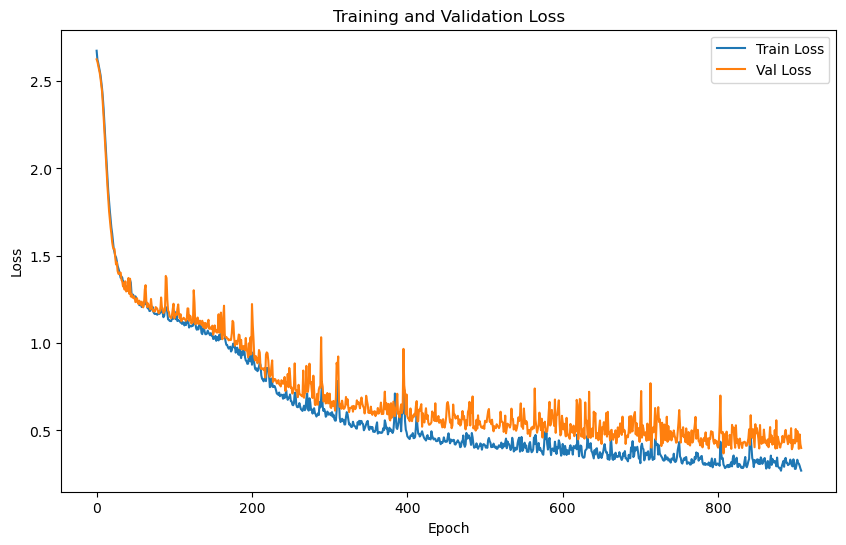

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.4597 | Test Accuracy: 83.27%


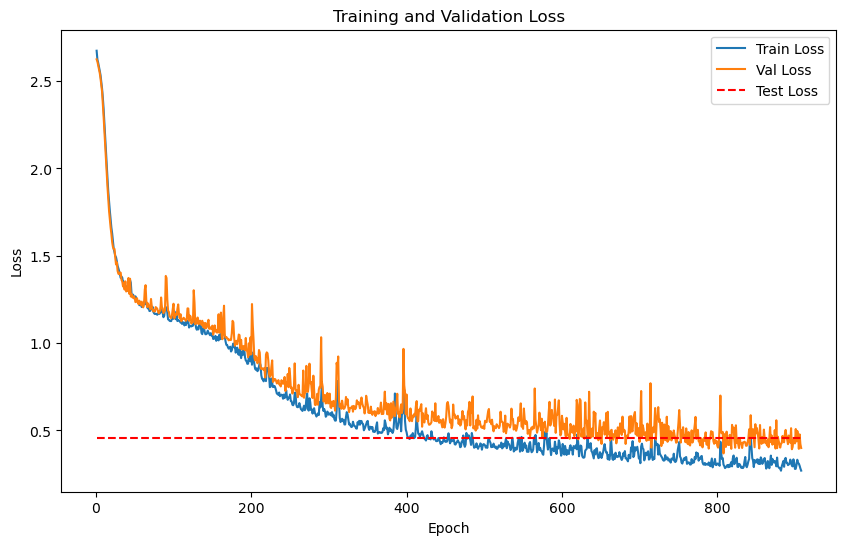

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)


Train embeddings shape: (560, 64), 
Train labels shape: (560,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2618, 64), 
Test labels shape: (2618,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/2], Train Loss: 7.9095
    Batch [2/2], Train Loss: 7.7618
Epoch [1/2000], Avg Train Loss: 7.8357
Epoch [1/2000], Avg Val Loss: 3.3605
Validation loss improved from inf to 3.3605. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 7.6441
    Batch [2/2], Train Loss: 7.6434
Epoch [2/2000], Avg Train Loss: 7.6438
Epoch [2/2000], Avg Val Loss: 3.3280
Validation loss improved from 3.3605 to 3.3280. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.6637
    Batch [2/2], Train Loss: 7.6760
Epoch [3/2000], Avg Train Loss: 7.6698
Epoch [3/2000], Avg Val Loss: 3.2985
Validation loss improved from 3.3280 to 3.2985. Saving model...

LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 7.4677
    Batch [2/2], Train Loss: 7.4623
Epoch [4/2000], Avg Train Loss: 7.4650
Epoch [4/2000], Avg Val Loss: 3.2720
Validation loss improved from 3.2985 to 3.2720. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 7.3133
    Batch [2/2], Train Loss: 7.3818
Epoch [5/2000], Avg Train Loss: 7.3476
Epoch [5/2000], Avg Val Loss: 3.2482
Validation loss improved from 3.2720 to 3.2482. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 7.2012
    Batch [2/2], Train Loss: 7.1745
Epoch [6/2000], Avg Train Loss: 7.1879
Epoch [6/2000], Avg Val Loss: 3.2270
Validation loss improved from 3.2482 to 3.2270. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 7.0735
    Batch [2/2], Train Loss: 7.1094
Epoch [7/2000], Avg Train Loss: 7.0914
Epoch [7/2000], Avg Val Loss: 3.2080
Validation loss improved from 3.2270 to 3.2080. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/2], Train L

    Batch [2/2], Train Loss: 6.5647
Epoch [11/2000], Avg Train Loss: 6.5570


Epoch [11/2000], Avg Val Loss: 3.1517
Validation loss improved from 3.1631 to 3.1517. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 6.4840
    Batch [2/2], Train Loss: 6.4056
Epoch [12/2000], Avg Train Loss: 6.4448
Epoch [12/2000], Avg Val Loss: 3.1417
Validation loss improved from 3.1517 to 3.1417. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.3321
    Batch [2/2], Train Loss: 6.3409
Epoch [13/2000], Avg Train Loss: 6.3365
Epoch [13/2000], Avg Val Loss: 3.1329
Validation loss improved from 3.1417 to 3.1329. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.4035
    Batch [2/2], Train Loss: 6.3379
Epoch [14/2000], Avg Train Loss: 6.3707
Epoch [14/2000], Avg Val Loss: 3.1252
Validation loss improved from 3.1329 to 3.1252. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.1262
    Batch [2/2], Train Loss: 6.1851
Epoch [15/2000], Avg Train Loss: 6.1557
Epoch [15/20

    Batch [2/2], Train Loss: 5.6446
Epoch [24/2000], Avg Train Loss: 5.6876
Epoch [24/2000], Avg Val Loss: 3.0910
Validation loss improved from 3.0923 to 3.0910. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 5.6526
    Batch [2/2], Train Loss: 5.5304
Epoch [25/2000], Avg Train Loss: 5.5915
Epoch [25/2000], Avg Val Loss: 3.0899
Validation loss improved from 3.0910 to 3.0899. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 5.6503
    Batch [2/2], Train Loss: 5.5877
Epoch [26/2000], Avg Train Loss: 5.6190
Epoch [26/2000], Avg Val Loss: 3.0890
Validation loss improved from 3.0899 to 3.0890. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 5.5262
    Batch [2/2], Train Loss: 5.5278
Epoch [27/2000], Avg Train Loss: 5.5270
Epoch [27/2000], Avg Val Loss: 3.0882
Validation loss improved from 3.0890 to 3.0882. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 5.4722
    Batch [2

    Batch [2/2], Train Loss: 5.4042
Epoch [33/2000], Avg Train Loss: 5.3708
Epoch [33/2000], Avg Val Loss: 3.0860
Validation loss improved from 3.0862 to 3.0860. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.2801
    Batch [2/2], Train Loss: 5.3412
Epoch [34/2000], Avg Train Loss: 5.3106
Epoch [34/2000], Avg Val Loss: 3.0858
Validation loss improved from 3.0860 to 3.0858. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.3499
    Batch [2/2], Train Loss: 5.3191
Epoch [35/2000], Avg Train Loss: 5.3345
Epoch [35/2000], Avg Val Loss: 3.0856
Validation loss improved from 3.0858 to 3.0856. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.3273
    Batch [2/2], Train Loss: 5.3272
Epoch [36/2000], Avg Train Loss: 5.3273
Epoch [36/2000], Avg Val Loss: 3.0854
Validation loss improved from 3.0856 to 3.0854. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.3001
    Batch [2

    Batch [2/2], Train Loss: 5.1231
Epoch [45/2000], Avg Train Loss: 5.1353
Epoch [45/2000], Avg Val Loss: 3.0820
Validation loss improved from 3.0826 to 3.0820. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 5.1449
    Batch [2/2], Train Loss: 5.1510
Epoch [46/2000], Avg Train Loss: 5.1480
Epoch [46/2000], Avg Val Loss: 3.0813
Validation loss improved from 3.0820 to 3.0813. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 5.1393
    Batch [2/2], Train Loss: 5.1600
Epoch [47/2000], Avg Train Loss: 5.1496
Epoch [47/2000], Avg Val Loss: 3.0806
Validation loss improved from 3.0813 to 3.0806. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 5.1721
    Batch [2/2], Train Loss: 5.0935
Epoch [48/2000], Avg Train Loss: 5.1328
Epoch [48/2000], Avg Val Loss: 3.0798
Validation loss improved from 3.0806 to 3.0798. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 5.1047
    Batch [2

    Batch [2/2], Train Loss: 5.0492
Epoch [55/2000], Avg Train Loss: 5.0628
Epoch [55/2000], Avg Val Loss: 3.0736
Validation loss improved from 3.0746 to 3.0736. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 4.9912
    Batch [2/2], Train Loss: 4.9748
Epoch [56/2000], Avg Train Loss: 4.9830
Epoch [56/2000], Avg Val Loss: 3.0725
Validation loss improved from 3.0736 to 3.0725. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 5.0099
    Batch [2/2], Train Loss: 5.0173
Epoch [57/2000], Avg Train Loss: 5.0136
Epoch [57/2000], Avg Val Loss: 3.0713
Validation loss improved from 3.0725 to 3.0713. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 5.0765
    Batch [2/2], Train Loss: 5.0220
Epoch [58/2000], Avg Train Loss: 5.0493
Epoch [58/2000], Avg Val Loss: 3.0701
Validation loss improved from 3.0713 to 3.0701. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 5.0282
    Batch [2

    Batch [2/2], Train Loss: 4.9522
Epoch [67/2000], Avg Train Loss: 4.9604
Epoch [67/2000], Avg Val Loss: 3.0589
Validation loss improved from 3.0603 to 3.0589. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 4.8924
    Batch [2/2], Train Loss: 4.9127
Epoch [68/2000], Avg Train Loss: 4.9025
Epoch [68/2000], Avg Val Loss: 3.0574
Validation loss improved from 3.0589 to 3.0574. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 4.9240
    Batch [2/2], Train Loss: 4.9192
Epoch [69/2000], Avg Train Loss: 4.9216
Epoch [69/2000], Avg Val Loss: 3.0558
Validation loss improved from 3.0574 to 3.0558. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 4.8907
    Batch [2/2], Train Loss: 4.8916
Epoch [70/2000], Avg Train Loss: 4.8912
Epoch [70/2000], Avg Val Loss: 3.0541
Validation loss improved from 3.0558 to 3.0541. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 4.8831
    Batch [2

    Batch [1/2], Train Loss: 4.8788
    Batch [2/2], Train Loss: 4.8831
Epoch [78/2000], Avg Train Loss: 4.8810
Epoch [78/2000], Avg Val Loss: 3.0399
Validation loss improved from 3.0418 to 3.0399. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 4.8663
    Batch [2/2], Train Loss: 4.8486
Epoch [79/2000], Avg Train Loss: 4.8574
Epoch [79/2000], Avg Val Loss: 3.0381
Validation loss improved from 3.0399 to 3.0381. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 4.8233
    Batch [2/2], Train Loss: 4.8341
Epoch [80/2000], Avg Train Loss: 4.8287
Epoch [80/2000], Avg Val Loss: 3.0362
Validation loss improved from 3.0381 to 3.0362. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 4.8231
    Batch [2/2], Train Loss: 4.8461
Epoch [81/2000], Avg Train Loss: 4.8346
Epoch [81/2000], Avg Val Loss: 3.0343
Validation loss improved from 3.0362 to 3.0343. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.7649
Epoch [89/2000], Avg Train Loss: 4.8105
Epoch [89/2000], Avg Val Loss: 3.0177
Validation loss improved from 3.0198 to 3.0177. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 4.7882
    Batch [2/2], Train Loss: 4.8030
Epoch [90/2000], Avg Train Loss: 4.7956
Epoch [90/2000], Avg Val Loss: 3.0157
Validation loss improved from 3.0177 to 3.0157. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 4.8041
    Batch [2/2], Train Loss: 4.8241
Epoch [91/2000], Avg Train Loss: 4.8141
Epoch [91/2000], Avg Val Loss: 3.0136
Validation loss improved from 3.0157 to 3.0136. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 4.8264
    Batch [2/2], Train Loss: 4.7774
Epoch [92/2000], Avg Train Loss: 4.8019
Epoch [92/2000], Avg Val Loss: 3.0115
Validation loss improved from 3.0136 to 3.0115. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 4.7533
    Batch [2

    Batch [1/2], Train Loss: 4.7877
    Batch [2/2], Train Loss: 4.7843
Epoch [99/2000], Avg Train Loss: 4.7860
Epoch [99/2000], Avg Val Loss: 2.9965
Validation loss improved from 2.9987 to 2.9965. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 4.7808
    Batch [2/2], Train Loss: 4.7410
Epoch [100/2000], Avg Train Loss: 4.7609
Epoch [100/2000], Avg Val Loss: 2.9945
Validation loss improved from 2.9965 to 2.9945. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 4.7524
    Batch [2/2], Train Loss: 4.6991
Epoch [101/2000], Avg Train Loss: 4.7257
Epoch [101/2000], Avg Val Loss: 2.9924
Validation loss improved from 2.9945 to 2.9924. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 4.7355
    Batch [2/2], Train Loss: 4.7497
Epoch [102/2000], Avg Train Loss: 4.7426
Epoch [102/2000], Avg Val Loss: 2.9905
Validation loss improved from 2.9924 to 2.9905. Saving model...

LOG: Epoch [103/2000] - Training
  

    Batch [2/2], Train Loss: 4.7219
Epoch [110/2000], Avg Train Loss: 4.7074
Epoch [110/2000], Avg Val Loss: 2.9736
Validation loss improved from 2.9759 to 2.9736. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 4.7160
    Batch [2/2], Train Loss: 4.6499
Epoch [111/2000], Avg Train Loss: 4.6829
Epoch [111/2000], Avg Val Loss: 2.9714
Validation loss improved from 2.9736 to 2.9714. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 4.6969
    Batch [2/2], Train Loss: 4.7148
Epoch [112/2000], Avg Train Loss: 4.7059
Epoch [112/2000], Avg Val Loss: 2.9691
Validation loss improved from 2.9714 to 2.9691. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 4.7411
    Batch [2/2], Train Loss: 4.6925
Epoch [113/2000], Avg Train Loss: 4.7168
Epoch [113/2000], Avg Val Loss: 2.9668
Validation loss improved from 2.9691 to 2.9668. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 4.7075


    Batch [2/2], Train Loss: 4.6301
Epoch [119/2000], Avg Train Loss: 4.6528
Epoch [119/2000], Avg Val Loss: 2.9537
Validation loss improved from 2.9559 to 2.9537. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 4.6655
    Batch [2/2], Train Loss: 4.6708
Epoch [120/2000], Avg Train Loss: 4.6682
Epoch [120/2000], Avg Val Loss: 2.9515
Validation loss improved from 2.9537 to 2.9515. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 4.6349
    Batch [2/2], Train Loss: 4.6455
Epoch [121/2000], Avg Train Loss: 4.6402
Epoch [121/2000], Avg Val Loss: 2.9492
Validation loss improved from 2.9515 to 2.9492. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 4.6410
    Batch [2/2], Train Loss: 4.6243
Epoch [122/2000], Avg Train Loss: 4.6327
Epoch [122/2000], Avg Val Loss: 2.9468
Validation loss improved from 2.9492 to 2.9468. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 4.6607


Epoch [131/2000], Avg Val Loss: 2.9262
Validation loss improved from 2.9284 to 2.9262. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 4.6482
    Batch [2/2], Train Loss: 4.6073
Epoch [132/2000], Avg Train Loss: 4.6278
Epoch [132/2000], Avg Val Loss: 2.9241
Validation loss improved from 2.9262 to 2.9241. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 4.5918
    Batch [2/2], Train Loss: 4.5801
Epoch [133/2000], Avg Train Loss: 4.5860
Epoch [133/2000], Avg Val Loss: 2.9219
Validation loss improved from 2.9241 to 2.9219. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 4.6429
    Batch [2/2], Train Loss: 4.6884
Epoch [134/2000], Avg Train Loss: 4.6656
Epoch [134/2000], Avg Val Loss: 2.9198
Validation loss improved from 2.9219 to 2.9198. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 4.6198
    Batch [2/2], Train Loss: 4.6305
Epoch [135/2000], Avg Train Loss: 4.6251


Epoch [141/2000], Avg Val Loss: 2.9042
Validation loss improved from 2.9065 to 2.9042. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 4.6423
    Batch [2/2], Train Loss: 4.5471
Epoch [142/2000], Avg Train Loss: 4.5947
Epoch [142/2000], Avg Val Loss: 2.9020
Validation loss improved from 2.9042 to 2.9020. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 4.5976
    Batch [2/2], Train Loss: 4.6252
Epoch [143/2000], Avg Train Loss: 4.6114
Epoch [143/2000], Avg Val Loss: 2.8998
Validation loss improved from 2.9020 to 2.8998. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 4.5125
    Batch [2/2], Train Loss: 4.5045
Epoch [144/2000], Avg Train Loss: 4.5085
Epoch [144/2000], Avg Val Loss: 2.8976
Validation loss improved from 2.8998 to 2.8976. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 4.5207
    Batch [2/2], Train Loss: 4.5697
Epoch [145/2000], Avg Train Loss: 4.5452


    Batch [2/2], Train Loss: 4.5043
Epoch [152/2000], Avg Train Loss: 4.5254
Epoch [152/2000], Avg Val Loss: 2.8780
Validation loss improved from 2.8806 to 2.8780. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 4.5107
    Batch [2/2], Train Loss: 4.4949
Epoch [153/2000], Avg Train Loss: 4.5028
Epoch [153/2000], Avg Val Loss: 2.8755
Validation loss improved from 2.8780 to 2.8755. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 4.5461
    Batch [2/2], Train Loss: 4.5216
Epoch [154/2000], Avg Train Loss: 4.5339
Epoch [154/2000], Avg Val Loss: 2.8731
Validation loss improved from 2.8755 to 2.8731. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 4.5281
    Batch [2/2], Train Loss: 4.4777
Epoch [155/2000], Avg Train Loss: 4.5029
Epoch [155/2000], Avg Val Loss: 2.8707
Validation loss improved from 2.8731 to 2.8707. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 4.4859


    Batch [1/2], Train Loss: 4.5398
    Batch [2/2], Train Loss: 4.5216
Epoch [163/2000], Avg Train Loss: 4.5307
Epoch [163/2000], Avg Val Loss: 2.8519
Validation loss improved from 2.8542 to 2.8519. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 4.5094
    Batch [2/2], Train Loss: 4.4692
Epoch [164/2000], Avg Train Loss: 4.4893
Epoch [164/2000], Avg Val Loss: 2.8496
Validation loss improved from 2.8519 to 2.8496. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 4.5267
    Batch [2/2], Train Loss: 4.5227
Epoch [165/2000], Avg Train Loss: 4.5247
Epoch [165/2000], Avg Val Loss: 2.8474
Validation loss improved from 2.8496 to 2.8474. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 4.5416
    Batch [2/2], Train Loss: 4.5522
Epoch [166/2000], Avg Train Loss: 4.5469
Epoch [166/2000], Avg Val Loss: 2.8452
Validation loss improved from 2.8474 to 2.8452. Saving model...

LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 4.4820
    Batch [2/2], Train Loss: 4.4698
Epoch [173/2000], Avg Train Loss: 4.4759
Epoch [173/2000], Avg Val Loss: 2.8300
Validation loss improved from 2.8323 to 2.8300. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 4.4522
    Batch [2/2], Train Loss: 4.4457
Epoch [174/2000], Avg Train Loss: 4.4490
Epoch [174/2000], Avg Val Loss: 2.8276
Validation loss improved from 2.8300 to 2.8276. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 4.4743
    Batch [2/2], Train Loss: 4.4657
Epoch [175/2000], Avg Train Loss: 4.4700
Epoch [175/2000], Avg Val Loss: 2.8253
Validation loss improved from 2.8276 to 2.8253. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 4.4238
    Batch [2/2], Train Loss: 4.4998
Epoch [176/2000], Avg Train Loss: 4.4618
Epoch [176/2000], Avg Val Loss: 2.8230
Validation loss improved from 2.8253 to 2.8230. Saving model...

LOG: Epoch [177/2000] - Training


    Batch [2/2], Train Loss: 4.4458
Epoch [185/2000], Avg Train Loss: 4.4389
Epoch [185/2000], Avg Val Loss: 2.8025
Validation loss improved from 2.8048 to 2.8025. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 4.4283
    Batch [2/2], Train Loss: 4.4523
Epoch [186/2000], Avg Train Loss: 4.4403
Epoch [186/2000], Avg Val Loss: 2.8001
Validation loss improved from 2.8025 to 2.8001. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 4.4289
    Batch [2/2], Train Loss: 4.3886
Epoch [187/2000], Avg Train Loss: 4.4087
Epoch [187/2000], Avg Val Loss: 2.7979
Validation loss improved from 2.8001 to 2.7979. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 4.4433
    Batch [2/2], Train Loss: 4.3740
Epoch [188/2000], Avg Train Loss: 4.4086
Epoch [188/2000], Avg Val Loss: 2.7956
Validation loss improved from 2.7979 to 2.7956. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 4.4309


    Batch [1/2], Train Loss: 4.3849
    Batch [2/2], Train Loss: 4.3585
Epoch [195/2000], Avg Train Loss: 4.3717
Epoch [195/2000], Avg Val Loss: 2.7800
Validation loss improved from 2.7822 to 2.7800. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 4.3737
    Batch [2/2], Train Loss: 4.4403
Epoch [196/2000], Avg Train Loss: 4.4070
Epoch [196/2000], Avg Val Loss: 2.7778
Validation loss improved from 2.7800 to 2.7778. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 4.3761
    Batch [2/2], Train Loss: 4.4245
Epoch [197/2000], Avg Train Loss: 4.4003
Epoch [197/2000], Avg Val Loss: 2.7756
Validation loss improved from 2.7778 to 2.7756. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 4.4083
    Batch [2/2], Train Loss: 4.3520
Epoch [198/2000], Avg Train Loss: 4.3802
Epoch [198/2000], Avg Val Loss: 2.7735
Validation loss improved from 2.7756 to 2.7735. Saving model...

LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 4.4099
    Batch [2/2], Train Loss: 4.3747
Epoch [208/2000], Avg Train Loss: 4.3923
Epoch [208/2000], Avg Val Loss: 2.7523
Validation loss improved from 2.7543 to 2.7523. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 4.3908
    Batch [2/2], Train Loss: 4.3612
Epoch [209/2000], Avg Train Loss: 4.3760
Epoch [209/2000], Avg Val Loss: 2.7501
Validation loss improved from 2.7523 to 2.7501. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 4.3786
    Batch [2/2], Train Loss: 4.3390
Epoch [210/2000], Avg Train Loss: 4.3588
Epoch [210/2000], Avg Val Loss: 2.7481
Validation loss improved from 2.7501 to 2.7481. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 4.3139
    Batch [2/2], Train Loss: 4.3426
Epoch [211/2000], Avg Train Loss: 4.3282
Epoch [211/2000], Avg Val Loss: 2.7460
Validation loss improved from 2.7481 to 2.7460. Saving model...

LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 4.3238
    Batch [2/2], Train Loss: 4.2989
Epoch [217/2000], Avg Train Loss: 4.3114
Epoch [217/2000], Avg Val Loss: 2.7338
Validation loss improved from 2.7357 to 2.7338. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 4.3338
    Batch [2/2], Train Loss: 4.2859
Epoch [218/2000], Avg Train Loss: 4.3098
Epoch [218/2000], Avg Val Loss: 2.7319
Validation loss improved from 2.7338 to 2.7319. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 4.3031
    Batch [2/2], Train Loss: 4.3628
Epoch [219/2000], Avg Train Loss: 4.3329
Epoch [219/2000], Avg Val Loss: 2.7300
Validation loss improved from 2.7319 to 2.7300. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 4.2920
    Batch [2/2], Train Loss: 4.3330
Epoch [220/2000], Avg Train Loss: 4.3125
Epoch [220/2000], Avg Val Loss: 2.7281
Validation loss improved from 2.7300 to 2.7281. Saving model...

LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 4.2393
    Batch [2/2], Train Loss: 4.2789
Epoch [231/2000], Avg Train Loss: 4.2591
Epoch [231/2000], Avg Val Loss: 2.7056
Validation loss improved from 2.7075 to 2.7056. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 4.2454
    Batch [2/2], Train Loss: 4.2644
Epoch [232/2000], Avg Train Loss: 4.2549
Epoch [232/2000], Avg Val Loss: 2.7037
Validation loss improved from 2.7056 to 2.7037. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 4.2945
    Batch [2/2], Train Loss: 4.2653
Epoch [233/2000], Avg Train Loss: 4.2799
Epoch [233/2000], Avg Val Loss: 2.7018
Validation loss improved from 2.7037 to 2.7018. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 4.3014
    Batch [2/2], Train Loss: 4.3300
Epoch [234/2000], Avg Train Loss: 4.3157
Epoch [234/2000], Avg Val Loss: 2.6998
Validation loss improved from 2.7018 to 2.6998. Saving model...

LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 4.2768
    Batch [2/2], Train Loss: 4.2689
Epoch [238/2000], Avg Train Loss: 4.2728
Epoch [238/2000], Avg Val Loss: 2.6918
Validation loss improved from 2.6937 to 2.6918. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 4.2818
    Batch [2/2], Train Loss: 4.2283
Epoch [239/2000], Avg Train Loss: 4.2550
Epoch [239/2000], Avg Val Loss: 2.6899
Validation loss improved from 2.6918 to 2.6899. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 4.2527
    Batch [2/2], Train Loss: 4.2318
Epoch [240/2000], Avg Train Loss: 4.2422
Epoch [240/2000], Avg Val Loss: 2.6880
Validation loss improved from 2.6899 to 2.6880. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 4.2311
    Batch [2/2], Train Loss: 4.2817
Epoch [241/2000], Avg Train Loss: 4.2564
Epoch [241/2000], Avg Val Loss: 2.6861
Validation loss improved from 2.6880 to 2.6861. Saving model...

LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 4.2378
    Batch [2/2], Train Loss: 4.2425
Epoch [252/2000], Avg Train Loss: 4.2401
Epoch [252/2000], Avg Val Loss: 2.6656
Validation loss improved from 2.6671 to 2.6656. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 4.2962
    Batch [2/2], Train Loss: 4.1834
Epoch [253/2000], Avg Train Loss: 4.2398
Epoch [253/2000], Avg Val Loss: 2.6640
Validation loss improved from 2.6656 to 2.6640. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 4.2857
    Batch [2/2], Train Loss: 4.2013
Epoch [254/2000], Avg Train Loss: 4.2435
Epoch [254/2000], Avg Val Loss: 2.6624
Validation loss improved from 2.6640 to 2.6624. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 4.2318
    Batch [2/2], Train Loss: 4.2035
Epoch [255/2000], Avg Train Loss: 4.2177
Epoch [255/2000], Avg Val Loss: 2.6610
Validation loss improved from 2.6624 to 2.6610. Saving model...

LOG: Epoch [256/2000] - Training


    Batch [2/2], Train Loss: 4.2393
Epoch [261/2000], Avg Train Loss: 4.1914
Epoch [261/2000], Avg Val Loss: 2.6530
Validation loss improved from 2.6544 to 2.6530. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 4.1707
    Batch [2/2], Train Loss: 4.1637
Epoch [262/2000], Avg Train Loss: 4.1672
Epoch [262/2000], Avg Val Loss: 2.6515
Validation loss improved from 2.6530 to 2.6515. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 4.2257
    Batch [2/2], Train Loss: 4.1987
Epoch [263/2000], Avg Train Loss: 4.2122
Epoch [263/2000], Avg Val Loss: 2.6499
Validation loss improved from 2.6515 to 2.6499. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 4.2108
    Batch [2/2], Train Loss: 4.1845
Epoch [264/2000], Avg Train Loss: 4.1977
Epoch [264/2000], Avg Val Loss: 2.6483
Validation loss improved from 2.6499 to 2.6483. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 4.2135


    Batch [1/2], Train Loss: 4.2110
    Batch [2/2], Train Loss: 4.2059
Epoch [274/2000], Avg Train Loss: 4.2084
Epoch [274/2000], Avg Val Loss: 2.6342
Validation loss improved from 2.6355 to 2.6342. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 4.1963
    Batch [2/2], Train Loss: 4.2069
Epoch [275/2000], Avg Train Loss: 4.2016
Epoch [275/2000], Avg Val Loss: 2.6329
Validation loss improved from 2.6342 to 2.6329. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 4.2010
    Batch [2/2], Train Loss: 4.1773
Epoch [276/2000], Avg Train Loss: 4.1892
Epoch [276/2000], Avg Val Loss: 2.6316
Validation loss improved from 2.6329 to 2.6316. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 4.1371
    Batch [2/2], Train Loss: 4.1258
Epoch [277/2000], Avg Train Loss: 4.1314
Epoch [277/2000], Avg Val Loss: 2.6302
Validation loss improved from 2.6316 to 2.6302. Saving model...

LOG: Epoch [278/2000] - Training


    Batch [2/2], Train Loss: 4.1274
Epoch [283/2000], Avg Train Loss: 4.1285
Epoch [283/2000], Avg Val Loss: 2.6219
Validation loss improved from 2.6233 to 2.6219. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 4.1511
    Batch [2/2], Train Loss: 4.1618
Epoch [284/2000], Avg Train Loss: 4.1564
Epoch [284/2000], Avg Val Loss: 2.6204
Validation loss improved from 2.6219 to 2.6204. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 4.1206
    Batch [2/2], Train Loss: 4.1238
Epoch [285/2000], Avg Train Loss: 4.1222
Epoch [285/2000], Avg Val Loss: 2.6190
Validation loss improved from 2.6204 to 2.6190. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 4.0861
    Batch [2/2], Train Loss: 4.0816
Epoch [286/2000], Avg Train Loss: 4.0839
Epoch [286/2000], Avg Val Loss: 2.6176
Validation loss improved from 2.6190 to 2.6176. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 4.1550


    Batch [1/2], Train Loss: 4.1128
    Batch [2/2], Train Loss: 4.0932
Epoch [297/2000], Avg Train Loss: 4.1030
Epoch [297/2000], Avg Val Loss: 2.6026
Validation loss improved from 2.6039 to 2.6026. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 4.1615
    Batch [2/2], Train Loss: 4.1278
Epoch [298/2000], Avg Train Loss: 4.1446
Epoch [298/2000], Avg Val Loss: 2.6013
Validation loss improved from 2.6026 to 2.6013. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 4.0984
    Batch [2/2], Train Loss: 4.0785
Epoch [299/2000], Avg Train Loss: 4.0885
Epoch [299/2000], Avg Val Loss: 2.6002
Validation loss improved from 2.6013 to 2.6002. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 4.1652
    Batch [2/2], Train Loss: 4.1101
Epoch [300/2000], Avg Train Loss: 4.1377
Epoch [300/2000], Avg Val Loss: 2.5992
Validation loss improved from 2.6002 to 2.5992. Saving model...

LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 4.1213
    Batch [2/2], Train Loss: 4.1162
Epoch [305/2000], Avg Train Loss: 4.1187
Epoch [305/2000], Avg Val Loss: 2.5934
Validation loss improved from 2.5948 to 2.5934. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 4.0815
    Batch [2/2], Train Loss: 4.1034
Epoch [306/2000], Avg Train Loss: 4.0924
Epoch [306/2000], Avg Val Loss: 2.5920
Validation loss improved from 2.5934 to 2.5920. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 4.1488
    Batch [2/2], Train Loss: 4.0968
Epoch [307/2000], Avg Train Loss: 4.1228
Epoch [307/2000], Avg Val Loss: 2.5908
Validation loss improved from 2.5920 to 2.5908. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/2], Train Loss: 3.9904
    Batch [2/2], Train Loss: 4.0982
Epoch [308/2000], Avg Train Loss: 4.0443
Epoch [308/2000], Avg Val Loss: 2.5897
Validation loss improved from 2.5908 to 2.5897. Saving model...

LOG: Epoch [309/2000] - Training


Epoch [319/2000], Avg Val Loss: 2.5776
Validation loss improved from 2.5785 to 2.5776. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 4.1033
    Batch [2/2], Train Loss: 4.0713
Epoch [320/2000], Avg Train Loss: 4.0873
Epoch [320/2000], Avg Val Loss: 2.5766
Validation loss improved from 2.5776 to 2.5766. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 4.0896
    Batch [2/2], Train Loss: 4.1640
Epoch [321/2000], Avg Train Loss: 4.1268
Epoch [321/2000], Avg Val Loss: 2.5758
Validation loss improved from 2.5766 to 2.5758. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 4.0515
    Batch [2/2], Train Loss: 4.0833
Epoch [322/2000], Avg Train Loss: 4.0674
Epoch [322/2000], Avg Val Loss: 2.5749
Validation loss improved from 2.5758 to 2.5749. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 3.9927
    Batch [2/2], Train Loss: 4.0501
Epoch [323/2000], Avg Train Loss: 4.0214


    Batch [2/2], Train Loss: 4.0745
Epoch [327/2000], Avg Train Loss: 4.1088
Epoch [327/2000], Avg Val Loss: 2.5711
Validation loss improved from 2.5718 to 2.5711. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 4.1012
    Batch [2/2], Train Loss: 4.0109
Epoch [328/2000], Avg Train Loss: 4.0560
Epoch [328/2000], Avg Val Loss: 2.5706
Validation loss improved from 2.5711 to 2.5706. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 3.9934
    Batch [2/2], Train Loss: 4.0656
Epoch [329/2000], Avg Train Loss: 4.0295
Epoch [329/2000], Avg Val Loss: 2.5698
Validation loss improved from 2.5706 to 2.5698. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 4.0031
    Batch [2/2], Train Loss: 4.0903
Epoch [330/2000], Avg Train Loss: 4.0467
Epoch [330/2000], Avg Val Loss: 2.5688
Validation loss improved from 2.5698 to 2.5688. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 4.0346


    Batch [1/2], Train Loss: 4.0246
    Batch [2/2], Train Loss: 4.0306
Epoch [342/2000], Avg Train Loss: 4.0276
Epoch [342/2000], Avg Val Loss: 2.5582
Validation loss improved from 2.5591 to 2.5582. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 4.0059
    Batch [2/2], Train Loss: 4.0145
Epoch [343/2000], Avg Train Loss: 4.0102
Epoch [343/2000], Avg Val Loss: 2.5571
Validation loss improved from 2.5582 to 2.5571. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 4.0515
    Batch [2/2], Train Loss: 3.9849
Epoch [344/2000], Avg Train Loss: 4.0182
Epoch [344/2000], Avg Val Loss: 2.5560
Validation loss improved from 2.5571 to 2.5560. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 3.9880
    Batch [2/2], Train Loss: 4.0469
Epoch [345/2000], Avg Train Loss: 4.0174
Epoch [345/2000], Avg Val Loss: 2.5549
Validation loss improved from 2.5560 to 2.5549. Saving model...

LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 4.0433
    Batch [2/2], Train Loss: 4.0297
Epoch [349/2000], Avg Train Loss: 4.0365
Epoch [349/2000], Avg Val Loss: 2.5513
Validation loss improved from 2.5521 to 2.5513. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 3.9857
    Batch [2/2], Train Loss: 3.9795
Epoch [350/2000], Avg Train Loss: 3.9826
Epoch [350/2000], Avg Val Loss: 2.5506
Validation loss improved from 2.5513 to 2.5506. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 4.0067
    Batch [2/2], Train Loss: 4.0514
Epoch [351/2000], Avg Train Loss: 4.0291
Epoch [351/2000], Avg Val Loss: 2.5500
Validation loss improved from 2.5506 to 2.5500. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 4.0084
    Batch [2/2], Train Loss: 4.0203
Epoch [352/2000], Avg Train Loss: 4.0144
Epoch [352/2000], Avg Val Loss: 2.5493
Validation loss improved from 2.5500 to 2.5493. Saving model...

LOG: Epoch [353/2000] - Training


    Batch [2/2], Train Loss: 4.0037
Epoch [363/2000], Avg Train Loss: 4.0238
Epoch [363/2000], Avg Val Loss: 2.5437
Validation loss improved from 2.5441 to 2.5437. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 3.9776
    Batch [2/2], Train Loss: 4.0013
Epoch [364/2000], Avg Train Loss: 3.9895
Epoch [364/2000], Avg Val Loss: 2.5432
Validation loss improved from 2.5437 to 2.5432. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 3.9915
    Batch [2/2], Train Loss: 3.9874
Epoch [365/2000], Avg Train Loss: 3.9894
Epoch [365/2000], Avg Val Loss: 2.5426
Validation loss improved from 2.5432 to 2.5426. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 4.0104
    Batch [2/2], Train Loss: 4.0128
Epoch [366/2000], Avg Train Loss: 4.0116
Epoch [366/2000], Avg Val Loss: 2.5421
Validation loss improved from 2.5426 to 2.5421. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 3.9722


Epoch [372/2000], Avg Val Loss: 2.5373
Validation loss improved from 2.5384 to 2.5373. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 3.9668
    Batch [2/2], Train Loss: 4.0031
Epoch [373/2000], Avg Train Loss: 3.9849
Epoch [373/2000], Avg Val Loss: 2.5361
Validation loss improved from 2.5373 to 2.5361. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 3.9876
    Batch [2/2], Train Loss: 3.9726
Epoch [374/2000], Avg Train Loss: 3.9801
Epoch [374/2000], Avg Val Loss: 2.5350
Validation loss improved from 2.5361 to 2.5350. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 3.9195
    Batch [2/2], Train Loss: 3.9260
Epoch [375/2000], Avg Train Loss: 3.9228
Epoch [375/2000], Avg Val Loss: 2.5340
Validation loss improved from 2.5350 to 2.5340. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 3.9626
    Batch [2/2], Train Loss: 3.9797
Epoch [376/2000], Avg Train Loss: 3.9711


    Batch [1/2], Train Loss: 3.9069
    Batch [2/2], Train Loss: 3.9352
Epoch [385/2000], Avg Train Loss: 3.9210
Epoch [385/2000], Avg Val Loss: 2.5255
Validation loss improved from 2.5262 to 2.5255. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 3.9503
    Batch [2/2], Train Loss: 3.9580
Epoch [386/2000], Avg Train Loss: 3.9541
Epoch [386/2000], Avg Val Loss: 2.5247
Validation loss improved from 2.5255 to 2.5247. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 3.9089
    Batch [2/2], Train Loss: 3.9276
Epoch [387/2000], Avg Train Loss: 3.9182
Epoch [387/2000], Avg Val Loss: 2.5240
Validation loss improved from 2.5247 to 2.5240. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 4.0356
    Batch [2/2], Train Loss: 3.9230
Epoch [388/2000], Avg Train Loss: 3.9793
Epoch [388/2000], Avg Val Loss: 2.5233
Validation loss improved from 2.5240 to 2.5233. Saving model...

LOG: Epoch [389/2000] - Training


    Batch [2/2], Train Loss: 3.9408
Epoch [394/2000], Avg Train Loss: 3.9396
Epoch [394/2000], Avg Val Loss: 2.5179
Validation loss improved from 2.5189 to 2.5179. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 3.9361
    Batch [2/2], Train Loss: 3.9504
Epoch [395/2000], Avg Train Loss: 3.9433
Epoch [395/2000], Avg Val Loss: 2.5171
Validation loss improved from 2.5179 to 2.5171. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 3.9335
    Batch [2/2], Train Loss: 3.9311
Epoch [396/2000], Avg Train Loss: 3.9323
Epoch [396/2000], Avg Val Loss: 2.5165
Validation loss improved from 2.5171 to 2.5165. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 3.9578
    Batch [2/2], Train Loss: 3.9190
Epoch [397/2000], Avg Train Loss: 3.9384
Epoch [397/2000], Avg Val Loss: 2.5159
Validation loss improved from 2.5165 to 2.5159. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 3.9448


    Batch [1/2], Train Loss: 3.9851
    Batch [2/2], Train Loss: 3.9716
Epoch [407/2000], Avg Train Loss: 3.9784
Epoch [407/2000], Avg Val Loss: 2.5134
Validation loss improved from 2.5137 to 2.5134. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 3.8775
    Batch [2/2], Train Loss: 3.9217
Epoch [408/2000], Avg Train Loss: 3.8996
Epoch [408/2000], Avg Val Loss: 2.5131
Validation loss improved from 2.5134 to 2.5131. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 3.9438
    Batch [2/2], Train Loss: 3.9062
Epoch [409/2000], Avg Train Loss: 3.9250
Epoch [409/2000], Avg Val Loss: 2.5129
Validation loss improved from 2.5131 to 2.5129. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 3.9663
    Batch [2/2], Train Loss: 3.9070
Epoch [410/2000], Avg Train Loss: 3.9366
Epoch [410/2000], Avg Val Loss: 2.5124
Validation loss improved from 2.5129 to 2.5124. Saving model...

LOG: Epoch [411/2000] - Training


    Batch [2/2], Train Loss: 3.9598
Epoch [418/2000], Avg Train Loss: 3.9151
Epoch [418/2000], Avg Val Loss: 2.5107
Validation loss improved from 2.5108 to 2.5107. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 3.8653
    Batch [2/2], Train Loss: 3.8434
Epoch [419/2000], Avg Train Loss: 3.8543
Epoch [419/2000], Avg Val Loss: 2.5103
Validation loss improved from 2.5107 to 2.5103. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 3.9440
    Batch [2/2], Train Loss: 3.9017
Epoch [420/2000], Avg Train Loss: 3.9229
Epoch [420/2000], Avg Val Loss: 2.5097
Validation loss improved from 2.5103 to 2.5097. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 3.9239
    Batch [2/2], Train Loss: 3.9248
Epoch [421/2000], Avg Train Loss: 3.9244
Epoch [421/2000], Avg Val Loss: 2.5092
Validation loss improved from 2.5097 to 2.5092. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 3.8966


    Batch [1/2], Train Loss: 3.8999
    Batch [2/2], Train Loss: 3.9148
Epoch [429/2000], Avg Train Loss: 3.9073
Epoch [429/2000], Avg Val Loss: 2.5066
Validation loss improved from 2.5071 to 2.5066. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/2], Train Loss: 3.8703
    Batch [2/2], Train Loss: 3.8992
Epoch [430/2000], Avg Train Loss: 3.8847
Epoch [430/2000], Avg Val Loss: 2.5062
Validation loss improved from 2.5066 to 2.5062. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 3.8504
    Batch [2/2], Train Loss: 3.8480
Epoch [431/2000], Avg Train Loss: 3.8492
Epoch [431/2000], Avg Val Loss: 2.5057
Validation loss improved from 2.5062 to 2.5057. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 3.8461
    Batch [2/2], Train Loss: 3.9286
Epoch [432/2000], Avg Train Loss: 3.8874
Epoch [432/2000], Avg Val Loss: 2.5051
Validation loss improved from 2.5057 to 2.5051. Saving model...

LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 3.8569
    Batch [2/2], Train Loss: 3.8512
Epoch [440/2000], Avg Train Loss: 3.8540
Epoch [440/2000], Avg Val Loss: 2.5005
Validation loss improved from 2.5008 to 2.5005. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 3.8689
    Batch [2/2], Train Loss: 3.8680
Epoch [441/2000], Avg Train Loss: 3.8684
Epoch [441/2000], Avg Val Loss: 2.5000
Validation loss improved from 2.5005 to 2.5000. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 3.9025
    Batch [2/2], Train Loss: 3.8560
Epoch [442/2000], Avg Train Loss: 3.8792
Epoch [442/2000], Avg Val Loss: 2.4996
Validation loss improved from 2.5000 to 2.4996. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 3.8794
    Batch [2/2], Train Loss: 3.8639
Epoch [443/2000], Avg Train Loss: 3.8717
Epoch [443/2000], Avg Val Loss: 2.4989
Validation loss improved from 2.4996 to 2.4989. Saving model...

LOG: Epoch [444/2000] - Training


    Batch [2/2], Train Loss: 3.8596
Epoch [451/2000], Avg Train Loss: 3.8421
Epoch [451/2000], Avg Val Loss: 2.4942
Validation loss improved from 2.4949 to 2.4942. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 3.8812
    Batch [2/2], Train Loss: 3.8649
Epoch [452/2000], Avg Train Loss: 3.8730
Epoch [452/2000], Avg Val Loss: 2.4936
Validation loss improved from 2.4942 to 2.4936. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 3.8682
    Batch [2/2], Train Loss: 3.8324
Epoch [453/2000], Avg Train Loss: 3.8503
Epoch [453/2000], Avg Val Loss: 2.4929
Validation loss improved from 2.4936 to 2.4929. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 3.8427
    Batch [2/2], Train Loss: 3.8272
Epoch [454/2000], Avg Train Loss: 3.8349
Epoch [454/2000], Avg Val Loss: 2.4924
Validation loss improved from 2.4929 to 2.4924. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 3.8520


    Batch [2/2], Train Loss: 3.8024
Epoch [463/2000], Avg Train Loss: 3.8280
Epoch [463/2000], Avg Val Loss: 2.4918
Validation loss did not improve. Patience: 5/100

LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 3.8984
    Batch [2/2], Train Loss: 3.8606
Epoch [464/2000], Avg Train Loss: 3.8795
Epoch [464/2000], Avg Val Loss: 2.4916
Validation loss did not improve. Patience: 6/100

LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 3.8639
    Batch [2/2], Train Loss: 3.8368
Epoch [465/2000], Avg Train Loss: 3.8503
Epoch [465/2000], Avg Val Loss: 2.4913
Validation loss did not improve. Patience: 7/100

LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 3.8836
    Batch [2/2], Train Loss: 3.7850
Epoch [466/2000], Avg Train Loss: 3.8343
Epoch [466/2000], Avg Val Loss: 2.4911
Validation loss improved from 2.4911 to 2.4911. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 3.8382
    Batch [2/2], Train Loss: 3.8536
Epoch [46

    Batch [2/2], Train Loss: 3.8200
Epoch [473/2000], Avg Train Loss: 3.8172
Epoch [473/2000], Avg Val Loss: 2.4886
Validation loss improved from 2.4888 to 2.4886. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 3.8452
    Batch [2/2], Train Loss: 3.8212
Epoch [474/2000], Avg Train Loss: 3.8332
Epoch [474/2000], Avg Val Loss: 2.4882
Validation loss improved from 2.4886 to 2.4882. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 3.8308
    Batch [2/2], Train Loss: 3.8005
Epoch [475/2000], Avg Train Loss: 3.8157
Epoch [475/2000], Avg Val Loss: 2.4880
Validation loss improved from 2.4882 to 2.4880. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 3.8130
    Batch [2/2], Train Loss: 3.8183
Epoch [476/2000], Avg Train Loss: 3.8157
Epoch [476/2000], Avg Val Loss: 2.4878
Validation loss improved from 2.4880 to 2.4878. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 3.8584


    Batch [1/2], Train Loss: 3.8318
    Batch [2/2], Train Loss: 3.7675
Epoch [485/2000], Avg Train Loss: 3.7997
Epoch [485/2000], Avg Val Loss: 2.4859
Validation loss improved from 2.4860 to 2.4859. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 3.8113
    Batch [2/2], Train Loss: 3.8428
Epoch [486/2000], Avg Train Loss: 3.8270
Epoch [486/2000], Avg Val Loss: 2.4858
Validation loss improved from 2.4859 to 2.4858. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 3.8290
    Batch [2/2], Train Loss: 3.7858
Epoch [487/2000], Avg Train Loss: 3.8074
Epoch [487/2000], Avg Val Loss: 2.4855
Validation loss improved from 2.4858 to 2.4855. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 3.8585
    Batch [2/2], Train Loss: 3.8213
Epoch [488/2000], Avg Train Loss: 3.8399
Epoch [488/2000], Avg Val Loss: 2.4853
Validation loss improved from 2.4855 to 2.4853. Saving model...

LOG: Epoch [489/2000] - Training


    Batch [2/2], Train Loss: 3.7509
Epoch [495/2000], Avg Train Loss: 3.7622
Epoch [495/2000], Avg Val Loss: 2.4826
Validation loss improved from 2.4827 to 2.4826. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 3.8195
    Batch [2/2], Train Loss: 3.7874
Epoch [496/2000], Avg Train Loss: 3.8034
Epoch [496/2000], Avg Val Loss: 2.4826
Validation loss improved from 2.4826 to 2.4826. Saving model...

LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 3.7941
    Batch [2/2], Train Loss: 3.7832
Epoch [497/2000], Avg Train Loss: 3.7887
Epoch [497/2000], Avg Val Loss: 2.4825
Validation loss improved from 2.4826 to 2.4825. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 3.7964
    Batch [2/2], Train Loss: 3.8124
Epoch [498/2000], Avg Train Loss: 3.8044
Epoch [498/2000], Avg Val Loss: 2.4824
Validation loss improved from 2.4825 to 2.4824. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 3.8267


    Batch [2/2], Train Loss: 3.7746
Epoch [506/2000], Avg Train Loss: 3.7983
Epoch [506/2000], Avg Val Loss: 2.4819
Validation loss improved from 2.4819 to 2.4819. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 3.7596
    Batch [2/2], Train Loss: 3.7963
Epoch [507/2000], Avg Train Loss: 3.7780
Epoch [507/2000], Avg Val Loss: 2.4820
Validation loss did not improve. Patience: 1/100

LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 3.8061
    Batch [2/2], Train Loss: 3.7945
Epoch [508/2000], Avg Train Loss: 3.8003
Epoch [508/2000], Avg Val Loss: 2.4821
Validation loss did not improve. Patience: 2/100

LOG: Epoch [509/2000] - Training
    Batch [1/2], Train Loss: 3.7924
    Batch [2/2], Train Loss: 3.7747
Epoch [509/2000], Avg Train Loss: 3.7836
Epoch [509/2000], Avg Val Loss: 2.4820
Validation loss did not improve. Patience: 3/100

LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 3.7608
    Batch [2/2], Train Loss: 3.8210
Epoch [51

    Batch [1/2], Train Loss: 3.7837
    Batch [2/2], Train Loss: 3.7700
Epoch [516/2000], Avg Train Loss: 3.7768
Epoch [516/2000], Avg Val Loss: 2.4808
Validation loss improved from 2.4815 to 2.4808. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 3.7691
    Batch [2/2], Train Loss: 3.7800
Epoch [517/2000], Avg Train Loss: 3.7745
Epoch [517/2000], Avg Val Loss: 2.4800
Validation loss improved from 2.4808 to 2.4800. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 3.8080
    Batch [2/2], Train Loss: 3.7808
Epoch [518/2000], Avg Train Loss: 3.7944
Epoch [518/2000], Avg Val Loss: 2.4792
Validation loss improved from 2.4800 to 2.4792. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 3.7785
    Batch [2/2], Train Loss: 3.7611
Epoch [519/2000], Avg Train Loss: 3.7698
Epoch [519/2000], Avg Val Loss: 2.4784
Validation loss improved from 2.4792 to 2.4784. Saving model...

LOG: Epoch [520/2000] - Training


    Batch [2/2], Train Loss: 3.7884
Epoch [527/2000], Avg Train Loss: 3.7830
Epoch [527/2000], Avg Val Loss: 2.4721
Validation loss improved from 2.4727 to 2.4721. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 3.7988
    Batch [2/2], Train Loss: 3.7306
Epoch [528/2000], Avg Train Loss: 3.7647
Epoch [528/2000], Avg Val Loss: 2.4718
Validation loss improved from 2.4721 to 2.4718. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/2], Train Loss: 3.7597
    Batch [2/2], Train Loss: 3.8114
Epoch [529/2000], Avg Train Loss: 3.7855
Epoch [529/2000], Avg Val Loss: 2.4713
Validation loss improved from 2.4718 to 2.4713. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 3.7388
    Batch [2/2], Train Loss: 3.7786
Epoch [530/2000], Avg Train Loss: 3.7587
Epoch [530/2000], Avg Val Loss: 2.4709
Validation loss improved from 2.4713 to 2.4709. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/2], Train Loss: 3.8135


    Batch [1/2], Train Loss: 3.8032
    Batch [2/2], Train Loss: 3.8006
Epoch [540/2000], Avg Train Loss: 3.8019
Epoch [540/2000], Avg Val Loss: 2.4686
Validation loss improved from 2.4686 to 2.4686. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 3.7812
    Batch [2/2], Train Loss: 3.7330
Epoch [541/2000], Avg Train Loss: 3.7571
Epoch [541/2000], Avg Val Loss: 2.4685
Validation loss improved from 2.4686 to 2.4685. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 3.7855
    Batch [2/2], Train Loss: 3.6960
Epoch [542/2000], Avg Train Loss: 3.7407
Epoch [542/2000], Avg Val Loss: 2.4685
Validation loss improved from 2.4685 to 2.4685. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 3.6967
    Batch [2/2], Train Loss: 3.7800
Epoch [543/2000], Avg Train Loss: 3.7384
Epoch [543/2000], Avg Val Loss: 2.4684
Validation loss improved from 2.4685 to 2.4684. Saving model...

LOG: Epoch [544/2000] - Training


Epoch [549/2000], Avg Val Loss: 2.4701
Validation loss did not improve. Patience: 6/100

LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 3.7437
    Batch [2/2], Train Loss: 3.7631
Epoch [550/2000], Avg Train Loss: 3.7534
Epoch [550/2000], Avg Val Loss: 2.4704
Validation loss did not improve. Patience: 7/100

LOG: Epoch [551/2000] - Training
    Batch [1/2], Train Loss: 3.7808
    Batch [2/2], Train Loss: 3.7320
Epoch [551/2000], Avg Train Loss: 3.7564
Epoch [551/2000], Avg Val Loss: 2.4708
Validation loss did not improve. Patience: 8/100

LOG: Epoch [552/2000] - Training
    Batch [1/2], Train Loss: 3.7004
    Batch [2/2], Train Loss: 3.7664
Epoch [552/2000], Avg Train Loss: 3.7334
Epoch [552/2000], Avg Val Loss: 2.4710
Validation loss did not improve. Patience: 9/100

LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 3.7666
    Batch [2/2], Train Loss: 3.7621
Epoch [553/2000], Avg Train Loss: 3.7644
Epoch [553/2000], Avg Val Loss: 2.4711
Validation loss did n

Epoch [561/2000], Avg Train Loss: 3.7126
Epoch [561/2000], Avg Val Loss: 2.4679
Validation loss improved from 2.4683 to 2.4679. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 3.7217
    Batch [2/2], Train Loss: 3.7304
Epoch [562/2000], Avg Train Loss: 3.7260
Epoch [562/2000], Avg Val Loss: 2.4677
Validation loss improved from 2.4679 to 2.4677. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 3.7113
    Batch [2/2], Train Loss: 3.6980
Epoch [563/2000], Avg Train Loss: 3.7047
Epoch [563/2000], Avg Val Loss: 2.4674
Validation loss improved from 2.4677 to 2.4674. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 3.7030
    Batch [2/2], Train Loss: 3.7504
Epoch [564/2000], Avg Train Loss: 3.7267
Epoch [564/2000], Avg Val Loss: 2.4668
Validation loss improved from 2.4674 to 2.4668. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 3.7476
    Batch [2/2], Train Loss: 3.7729


    Batch [1/2], Train Loss: 3.7085
    Batch [2/2], Train Loss: 3.7227
Epoch [572/2000], Avg Train Loss: 3.7156
Epoch [572/2000], Avg Val Loss: 2.4669
Validation loss did not improve. Patience: 6/100

LOG: Epoch [573/2000] - Training
    Batch [1/2], Train Loss: 3.7343
    Batch [2/2], Train Loss: 3.7095
Epoch [573/2000], Avg Train Loss: 3.7219
Epoch [573/2000], Avg Val Loss: 2.4668
Validation loss did not improve. Patience: 7/100

LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 3.6905
    Batch [2/2], Train Loss: 3.7226
Epoch [574/2000], Avg Train Loss: 3.7065
Epoch [574/2000], Avg Val Loss: 2.4667
Validation loss did not improve. Patience: 8/100

LOG: Epoch [575/2000] - Training
    Batch [1/2], Train Loss: 3.7120
    Batch [2/2], Train Loss: 3.7611
Epoch [575/2000], Avg Train Loss: 3.7365
Epoch [575/2000], Avg Val Loss: 2.4665
Validation loss did not improve. Patience: 9/100

LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 3.6701
    Batch [2/2], Train L

Epoch [582/2000], Avg Val Loss: 2.4662
Validation loss did not improve. Patience: 4/100

LOG: Epoch [583/2000] - Training
    Batch [1/2], Train Loss: 3.6257
    Batch [2/2], Train Loss: 3.7350
Epoch [583/2000], Avg Train Loss: 3.6804
Epoch [583/2000], Avg Val Loss: 2.4661
Validation loss did not improve. Patience: 5/100

LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 3.7033
    Batch [2/2], Train Loss: 3.6623
Epoch [584/2000], Avg Train Loss: 3.6828
Epoch [584/2000], Avg Val Loss: 2.4658
Validation loss improved from 2.4660 to 2.4658. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 3.7135
    Batch [2/2], Train Loss: 3.6945
Epoch [585/2000], Avg Train Loss: 3.7040
Epoch [585/2000], Avg Val Loss: 2.4653
Validation loss improved from 2.4658 to 2.4653. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 3.6705
    Batch [2/2], Train Loss: 3.7237
Epoch [586/2000], Avg Train Loss: 3.6971
Epoch [586/2000], Avg Val Loss

    Batch [2/2], Train Loss: 3.6947
Epoch [593/2000], Avg Train Loss: 3.6755
Epoch [593/2000], Avg Val Loss: 2.4666
Validation loss did not improve. Patience: 5/100

LOG: Epoch [594/2000] - Training
    Batch [1/2], Train Loss: 3.6816
    Batch [2/2], Train Loss: 3.7196
Epoch [594/2000], Avg Train Loss: 3.7006
Epoch [594/2000], Avg Val Loss: 2.4665
Validation loss did not improve. Patience: 6/100

LOG: Epoch [595/2000] - Training
    Batch [1/2], Train Loss: 3.6467
    Batch [2/2], Train Loss: 3.6923
Epoch [595/2000], Avg Train Loss: 3.6695
Epoch [595/2000], Avg Val Loss: 2.4668
Validation loss did not improve. Patience: 7/100

LOG: Epoch [596/2000] - Training
    Batch [1/2], Train Loss: 3.7398
    Batch [2/2], Train Loss: 3.7155
Epoch [596/2000], Avg Train Loss: 3.7276
Epoch [596/2000], Avg Val Loss: 2.4668
Validation loss did not improve. Patience: 8/100

LOG: Epoch [597/2000] - Training
    Batch [1/2], Train Loss: 3.7037
    Batch [2/2], Train Loss: 3.6736
Epoch [597/2000], Avg Tr

    Batch [2/2], Train Loss: 3.7179
Epoch [605/2000], Avg Train Loss: 3.6726
Epoch [605/2000], Avg Val Loss: 2.4627
Validation loss improved from 2.4630 to 2.4627. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 3.7070
    Batch [2/2], Train Loss: 3.6574
Epoch [606/2000], Avg Train Loss: 3.6822
Epoch [606/2000], Avg Val Loss: 2.4629
Validation loss did not improve. Patience: 1/100

LOG: Epoch [607/2000] - Training
    Batch [1/2], Train Loss: 3.7524
    Batch [2/2], Train Loss: 3.6863
Epoch [607/2000], Avg Train Loss: 3.7194
Epoch [607/2000], Avg Val Loss: 2.4631
Validation loss did not improve. Patience: 2/100

LOG: Epoch [608/2000] - Training
    Batch [1/2], Train Loss: 3.6847
    Batch [2/2], Train Loss: 3.6805
Epoch [608/2000], Avg Train Loss: 3.6826
Epoch [608/2000], Avg Val Loss: 2.4631
Validation loss did not improve. Patience: 3/100

LOG: Epoch [609/2000] - Training
    Batch [1/2], Train Loss: 3.7030
    Batch [2/2], Train Loss: 3.6284
Epoch [60

    Batch [1/2], Train Loss: 3.7176
    Batch [2/2], Train Loss: 3.7189
Epoch [615/2000], Avg Train Loss: 3.7183
Epoch [615/2000], Avg Val Loss: 2.4613
Validation loss improved from 2.4616 to 2.4613. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 3.6718
    Batch [2/2], Train Loss: 3.6400
Epoch [616/2000], Avg Train Loss: 3.6559
Epoch [616/2000], Avg Val Loss: 2.4607
Validation loss improved from 2.4613 to 2.4607. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 3.6745
    Batch [2/2], Train Loss: 3.7283
Epoch [617/2000], Avg Train Loss: 3.7014
Epoch [617/2000], Avg Val Loss: 2.4603
Validation loss improved from 2.4607 to 2.4603. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 3.7021
    Batch [2/2], Train Loss: 3.6569
Epoch [618/2000], Avg Train Loss: 3.6795
Epoch [618/2000], Avg Val Loss: 2.4595
Validation loss improved from 2.4603 to 2.4595. Saving model...

LOG: Epoch [619/2000] - Training


    Batch [2/2], Train Loss: 3.6586
Epoch [626/2000], Avg Train Loss: 3.6724
Epoch [626/2000], Avg Val Loss: 2.4559
Validation loss improved from 2.4559 to 2.4559. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 3.6163
    Batch [2/2], Train Loss: 3.6606
Epoch [627/2000], Avg Train Loss: 3.6384
Epoch [627/2000], Avg Val Loss: 2.4558
Validation loss improved from 2.4559 to 2.4558. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/2], Train Loss: 3.6867
    Batch [2/2], Train Loss: 3.6579
Epoch [628/2000], Avg Train Loss: 3.6723
Epoch [628/2000], Avg Val Loss: 2.4556
Validation loss improved from 2.4558 to 2.4556. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 3.7320
    Batch [2/2], Train Loss: 3.7211
Epoch [629/2000], Avg Train Loss: 3.7265
Epoch [629/2000], Avg Val Loss: 2.4555
Validation loss improved from 2.4556 to 2.4555. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/2], Train Loss: 3.6872


    Batch [2/2], Train Loss: 3.6559
Epoch [636/2000], Avg Train Loss: 3.6622
Epoch [636/2000], Avg Val Loss: 2.4553
Validation loss did not improve. Patience: 1/100

LOG: Epoch [637/2000] - Training
    Batch [1/2], Train Loss: 3.6239
    Batch [2/2], Train Loss: 3.6289
Epoch [637/2000], Avg Train Loss: 3.6264
Epoch [637/2000], Avg Val Loss: 2.4554
Validation loss did not improve. Patience: 2/100

LOG: Epoch [638/2000] - Training
    Batch [1/2], Train Loss: 3.6897
    Batch [2/2], Train Loss: 3.6074
Epoch [638/2000], Avg Train Loss: 3.6486
Epoch [638/2000], Avg Val Loss: 2.4555
Validation loss did not improve. Patience: 3/100

LOG: Epoch [639/2000] - Training
    Batch [1/2], Train Loss: 3.6558
    Batch [2/2], Train Loss: 3.6032
Epoch [639/2000], Avg Train Loss: 3.6295
Epoch [639/2000], Avg Val Loss: 2.4554
Validation loss did not improve. Patience: 4/100

LOG: Epoch [640/2000] - Training
    Batch [1/2], Train Loss: 3.6626
    Batch [2/2], Train Loss: 3.6891
Epoch [640/2000], Avg Tr

    Batch [1/2], Train Loss: 3.6440
    Batch [2/2], Train Loss: 3.5778
Epoch [648/2000], Avg Train Loss: 3.6109
Epoch [648/2000], Avg Val Loss: 2.4536
Validation loss improved from 2.4540 to 2.4536. Saving model...

LOG: Epoch [649/2000] - Training
    Batch [1/2], Train Loss: 3.6195
    Batch [2/2], Train Loss: 3.6673
Epoch [649/2000], Avg Train Loss: 3.6434
Epoch [649/2000], Avg Val Loss: 2.4534
Validation loss improved from 2.4536 to 2.4534. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 3.6586
    Batch [2/2], Train Loss: 3.6506
Epoch [650/2000], Avg Train Loss: 3.6546
Epoch [650/2000], Avg Val Loss: 2.4527
Validation loss improved from 2.4534 to 2.4527. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/2], Train Loss: 3.6338
    Batch [2/2], Train Loss: 3.6745
Epoch [651/2000], Avg Train Loss: 3.6542
Epoch [651/2000], Avg Val Loss: 2.4521
Validation loss improved from 2.4527 to 2.4521. Saving model...

LOG: Epoch [652/2000] - Training


    Batch [2/2], Train Loss: 3.5830
Epoch [669/2000], Avg Train Loss: 3.6016
Epoch [669/2000], Avg Val Loss: 2.4495
Validation loss did not improve. Patience: 9/100

LOG: Epoch [670/2000] - Training
    Batch [1/2], Train Loss: 3.6065
    Batch [2/2], Train Loss: 3.6654
Epoch [670/2000], Avg Train Loss: 3.6360
Epoch [670/2000], Avg Val Loss: 2.4494
Validation loss did not improve. Patience: 10/100

LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 3.6842
    Batch [2/2], Train Loss: 3.5909
Epoch [671/2000], Avg Train Loss: 3.6375
Epoch [671/2000], Avg Val Loss: 2.4492
Validation loss did not improve. Patience: 11/100

LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 3.6045
    Batch [2/2], Train Loss: 3.6669
Epoch [672/2000], Avg Train Loss: 3.6357
Epoch [672/2000], Avg Val Loss: 2.4493
Validation loss did not improve. Patience: 12/100

LOG: Epoch [673/2000] - Training
    Batch [1/2], Train Loss: 3.6333
    Batch [2/2], Train Loss: 3.5670
Epoch [673/2000], Avg

    Batch [1/2], Train Loss: 3.6447
    Batch [2/2], Train Loss: 3.6379
Epoch [692/2000], Avg Train Loss: 3.6413
Epoch [692/2000], Avg Val Loss: 2.4486
Validation loss did not improve. Patience: 32/100

LOG: Epoch [693/2000] - Training
    Batch [1/2], Train Loss: 3.6008
    Batch [2/2], Train Loss: 3.5858
Epoch [693/2000], Avg Train Loss: 3.5933
Epoch [693/2000], Avg Val Loss: 2.4482
Validation loss did not improve. Patience: 33/100

LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 3.6499
    Batch [2/2], Train Loss: 3.6312
Epoch [694/2000], Avg Train Loss: 3.6406
Epoch [694/2000], Avg Val Loss: 2.4481
Validation loss did not improve. Patience: 34/100

LOG: Epoch [695/2000] - Training
    Batch [1/2], Train Loss: 3.5930
    Batch [2/2], Train Loss: 3.5975
Epoch [695/2000], Avg Train Loss: 3.5952
Epoch [695/2000], Avg Val Loss: 2.4478
Validation loss did not improve. Patience: 35/100

LOG: Epoch [696/2000] - Training
    Batch [1/2], Train Loss: 3.6011
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.5911
    Batch [2/2], Train Loss: 3.6139
Epoch [714/2000], Avg Train Loss: 3.6025
Epoch [714/2000], Avg Val Loss: 2.4475
Validation loss did not improve. Patience: 54/100

LOG: Epoch [715/2000] - Training
    Batch [1/2], Train Loss: 3.6349
    Batch [2/2], Train Loss: 3.5760
Epoch [715/2000], Avg Train Loss: 3.6054
Epoch [715/2000], Avg Val Loss: 2.4471
Validation loss improved from 2.4472 to 2.4471. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/2], Train Loss: 3.5249
    Batch [2/2], Train Loss: 3.5770
Epoch [716/2000], Avg Train Loss: 3.5510
Epoch [716/2000], Avg Val Loss: 2.4466
Validation loss improved from 2.4471 to 2.4466. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/2], Train Loss: 3.6332
    Batch [2/2], Train Loss: 3.5882
Epoch [717/2000], Avg Train Loss: 3.6107
Epoch [717/2000], Avg Val Loss: 2.4461
Validation loss improved from 2.4466 to 2.4461. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/2

    Batch [2/2], Train Loss: 3.5947
Epoch [735/2000], Avg Train Loss: 3.5847
Epoch [735/2000], Avg Val Loss: 2.4439
Validation loss did not improve. Patience: 10/100

LOG: Epoch [736/2000] - Training
    Batch [1/2], Train Loss: 3.6056
    Batch [2/2], Train Loss: 3.5523
Epoch [736/2000], Avg Train Loss: 3.5789
Epoch [736/2000], Avg Val Loss: 2.4439
Validation loss did not improve. Patience: 11/100

LOG: Epoch [737/2000] - Training
    Batch [1/2], Train Loss: 3.6101
    Batch [2/2], Train Loss: 3.6041
Epoch [737/2000], Avg Train Loss: 3.6071
Epoch [737/2000], Avg Val Loss: 2.4440
Validation loss did not improve. Patience: 12/100

LOG: Epoch [738/2000] - Training
    Batch [1/2], Train Loss: 3.6210
    Batch [2/2], Train Loss: 3.5667
Epoch [738/2000], Avg Train Loss: 3.5938
Epoch [738/2000], Avg Val Loss: 2.4446
Validation loss did not improve. Patience: 13/100

LOG: Epoch [739/2000] - Training
    Batch [1/2], Train Loss: 3.6086
    Batch [2/2], Train Loss: 3.5524
Epoch [739/2000], Av

    Batch [1/2], Train Loss: 3.5948
    Batch [2/2], Train Loss: 3.5698
Epoch [756/2000], Avg Train Loss: 3.5823
Epoch [756/2000], Avg Val Loss: 2.4443
Validation loss did not improve. Patience: 31/100

LOG: Epoch [757/2000] - Training
    Batch [1/2], Train Loss: 3.5565
    Batch [2/2], Train Loss: 3.5162
Epoch [757/2000], Avg Train Loss: 3.5364
Epoch [757/2000], Avg Val Loss: 2.4443
Validation loss did not improve. Patience: 32/100

LOG: Epoch [758/2000] - Training
    Batch [1/2], Train Loss: 3.5363
    Batch [2/2], Train Loss: 3.5732
Epoch [758/2000], Avg Train Loss: 3.5547
Epoch [758/2000], Avg Val Loss: 2.4443
Validation loss did not improve. Patience: 33/100

LOG: Epoch [759/2000] - Training
    Batch [1/2], Train Loss: 3.5549
    Batch [2/2], Train Loss: 3.4929
Epoch [759/2000], Avg Train Loss: 3.5239
Epoch [759/2000], Avg Val Loss: 2.4441
Validation loss did not improve. Patience: 34/100

LOG: Epoch [760/2000] - Training
    Batch [1/2], Train Loss: 3.5923
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.5275
    Batch [2/2], Train Loss: 3.5552
Epoch [778/2000], Avg Train Loss: 3.5414
Epoch [778/2000], Avg Val Loss: 2.4436
Validation loss did not improve. Patience: 53/100

LOG: Epoch [779/2000] - Training
    Batch [1/2], Train Loss: 3.5658
    Batch [2/2], Train Loss: 3.5445
Epoch [779/2000], Avg Train Loss: 3.5551
Epoch [779/2000], Avg Val Loss: 2.4438
Validation loss did not improve. Patience: 54/100

LOG: Epoch [780/2000] - Training
    Batch [1/2], Train Loss: 3.5971
    Batch [2/2], Train Loss: 3.5594
Epoch [780/2000], Avg Train Loss: 3.5783
Epoch [780/2000], Avg Val Loss: 2.4443
Validation loss did not improve. Patience: 55/100

LOG: Epoch [781/2000] - Training
    Batch [1/2], Train Loss: 3.5535
    Batch [2/2], Train Loss: 3.5254
Epoch [781/2000], Avg Train Loss: 3.5394
Epoch [781/2000], Avg Val Loss: 2.4445
Validation loss did not improve. Patience: 56/100

LOG: Epoch [782/2000] - Training
    Batch [1/2], Train Loss: 3.5718
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.5120
    Batch [2/2], Train Loss: 3.5193
Epoch [801/2000], Avg Train Loss: 3.5156
Epoch [801/2000], Avg Val Loss: 2.4366
Validation loss did not improve. Patience: 2/100

LOG: Epoch [802/2000] - Training
    Batch [1/2], Train Loss: 3.4923
    Batch [2/2], Train Loss: 3.5426
Epoch [802/2000], Avg Train Loss: 3.5174
Epoch [802/2000], Avg Val Loss: 2.4375
Validation loss did not improve. Patience: 3/100

LOG: Epoch [803/2000] - Training
    Batch [1/2], Train Loss: 3.5133
    Batch [2/2], Train Loss: 3.5469
Epoch [803/2000], Avg Train Loss: 3.5301
Epoch [803/2000], Avg Val Loss: 2.4384
Validation loss did not improve. Patience: 4/100

LOG: Epoch [804/2000] - Training
    Batch [1/2], Train Loss: 3.5636
    Batch [2/2], Train Loss: 3.5434
Epoch [804/2000], Avg Train Loss: 3.5535
Epoch [804/2000], Avg Val Loss: 2.4391
Validation loss did not improve. Patience: 5/100

LOG: Epoch [805/2000] - Training
    Batch [1/2], Train Loss: 3.5299
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.5575
    Batch [2/2], Train Loss: 3.4750
Epoch [823/2000], Avg Train Loss: 3.5162
Epoch [823/2000], Avg Val Loss: 2.4388
Validation loss did not improve. Patience: 24/100

LOG: Epoch [824/2000] - Training
    Batch [1/2], Train Loss: 3.5115
    Batch [2/2], Train Loss: 3.4549
Epoch [824/2000], Avg Train Loss: 3.4832
Epoch [824/2000], Avg Val Loss: 2.4393
Validation loss did not improve. Patience: 25/100

LOG: Epoch [825/2000] - Training
    Batch [1/2], Train Loss: 3.6029
    Batch [2/2], Train Loss: 3.4889
Epoch [825/2000], Avg Train Loss: 3.5459
Epoch [825/2000], Avg Val Loss: 2.4395
Validation loss did not improve. Patience: 26/100

LOG: Epoch [826/2000] - Training
    Batch [1/2], Train Loss: 3.5427
    Batch [2/2], Train Loss: 3.5360
Epoch [826/2000], Avg Train Loss: 3.5393
Epoch [826/2000], Avg Val Loss: 2.4395
Validation loss did not improve. Patience: 27/100

LOG: Epoch [827/2000] - Training
    Batch [1/2], Train Loss: 3.5229
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.4993
    Batch [2/2], Train Loss: 3.5008
Epoch [844/2000], Avg Train Loss: 3.5001
Epoch [844/2000], Avg Val Loss: 2.4352
Validation loss did not improve. Patience: 7/100

LOG: Epoch [845/2000] - Training
    Batch [1/2], Train Loss: 3.5354
    Batch [2/2], Train Loss: 3.4945
Epoch [845/2000], Avg Train Loss: 3.5150
Epoch [845/2000], Avg Val Loss: 2.4358
Validation loss did not improve. Patience: 8/100

LOG: Epoch [846/2000] - Training
    Batch [1/2], Train Loss: 3.5212
    Batch [2/2], Train Loss: 3.4978
Epoch [846/2000], Avg Train Loss: 3.5095
Epoch [846/2000], Avg Val Loss: 2.4366
Validation loss did not improve. Patience: 9/100

LOG: Epoch [847/2000] - Training
    Batch [1/2], Train Loss: 3.5366
    Batch [2/2], Train Loss: 3.4602
Epoch [847/2000], Avg Train Loss: 3.4984
Epoch [847/2000], Avg Val Loss: 2.4371
Validation loss did not improve. Patience: 10/100

LOG: Epoch [848/2000] - Training
    Batch [1/2], Train Loss: 3.5039
    Batch [2/2], Train 

    Batch [2/2], Train Loss: 3.4850
Epoch [866/2000], Avg Train Loss: 3.5082
Epoch [866/2000], Avg Val Loss: 2.4354
Validation loss did not improve. Patience: 29/100

LOG: Epoch [867/2000] - Training
    Batch [1/2], Train Loss: 3.4791
    Batch [2/2], Train Loss: 3.5309
Epoch [867/2000], Avg Train Loss: 3.5050
Epoch [867/2000], Avg Val Loss: 2.4352
Validation loss did not improve. Patience: 30/100

LOG: Epoch [868/2000] - Training
    Batch [1/2], Train Loss: 3.5017
    Batch [2/2], Train Loss: 3.5067
Epoch [868/2000], Avg Train Loss: 3.5042
Epoch [868/2000], Avg Val Loss: 2.4350
Validation loss did not improve. Patience: 31/100

LOG: Epoch [869/2000] - Training
    Batch [1/2], Train Loss: 3.4718
    Batch [2/2], Train Loss: 3.4723
Epoch [869/2000], Avg Train Loss: 3.4720
Epoch [869/2000], Avg Val Loss: 2.4347
Validation loss did not improve. Patience: 32/100

LOG: Epoch [870/2000] - Training
    Batch [1/2], Train Loss: 3.5169
    Batch [2/2], Train Loss: 3.4652
Epoch [870/2000], Av

Epoch [887/2000], Avg Val Loss: 2.4334
Validation loss did not improve. Patience: 50/100

LOG: Epoch [888/2000] - Training
    Batch [1/2], Train Loss: 3.5038
    Batch [2/2], Train Loss: 3.4676
Epoch [888/2000], Avg Train Loss: 3.4857
Epoch [888/2000], Avg Val Loss: 2.4335
Validation loss did not improve. Patience: 51/100

LOG: Epoch [889/2000] - Training
    Batch [1/2], Train Loss: 3.5271
    Batch [2/2], Train Loss: 3.4637
Epoch [889/2000], Avg Train Loss: 3.4954
Epoch [889/2000], Avg Val Loss: 2.4337
Validation loss did not improve. Patience: 52/100

LOG: Epoch [890/2000] - Training
    Batch [1/2], Train Loss: 3.4881
    Batch [2/2], Train Loss: 3.4267
Epoch [890/2000], Avg Train Loss: 3.4574
Epoch [890/2000], Avg Val Loss: 2.4343
Validation loss did not improve. Patience: 53/100

LOG: Epoch [891/2000] - Training
    Batch [1/2], Train Loss: 3.4495
    Batch [2/2], Train Loss: 3.5046
Epoch [891/2000], Avg Train Loss: 3.4771
Epoch [891/2000], Avg Val Loss: 2.4350
Validation loss d

    Batch [1/2], Train Loss: 3.4970
    Batch [2/2], Train Loss: 3.4755
Epoch [910/2000], Avg Train Loss: 3.4863
Epoch [910/2000], Avg Val Loss: 2.4336
Validation loss did not improve. Patience: 3/100

LOG: Epoch [911/2000] - Training
    Batch [1/2], Train Loss: 3.4685
    Batch [2/2], Train Loss: 3.4671
Epoch [911/2000], Avg Train Loss: 3.4678
Epoch [911/2000], Avg Val Loss: 2.4341
Validation loss did not improve. Patience: 4/100

LOG: Epoch [912/2000] - Training
    Batch [1/2], Train Loss: 3.4750
    Batch [2/2], Train Loss: 3.4617
Epoch [912/2000], Avg Train Loss: 3.4684
Epoch [912/2000], Avg Val Loss: 2.4350
Validation loss did not improve. Patience: 5/100

LOG: Epoch [913/2000] - Training
    Batch [1/2], Train Loss: 3.4932
    Batch [2/2], Train Loss: 3.4950
Epoch [913/2000], Avg Train Loss: 3.4941
Epoch [913/2000], Avg Val Loss: 2.4357
Validation loss did not improve. Patience: 6/100

LOG: Epoch [914/2000] - Training
    Batch [1/2], Train Loss: 3.4127
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.4777
Epoch [932/2000], Avg Train Loss: 3.4773
Epoch [932/2000], Avg Val Loss: 2.4319
Validation loss did not improve. Patience: 1/100

LOG: Epoch [933/2000] - Training
    Batch [1/2], Train Loss: 3.4195
    Batch [2/2], Train Loss: 3.4490
Epoch [933/2000], Avg Train Loss: 3.4343
Epoch [933/2000], Avg Val Loss: 2.4321
Validation loss did not improve. Patience: 2/100

LOG: Epoch [934/2000] - Training
    Batch [1/2], Train Loss: 3.4175
    Batch [2/2], Train Loss: 3.4597
Epoch [934/2000], Avg Train Loss: 3.4386
Epoch [934/2000], Avg Val Loss: 2.4320
Validation loss did not improve. Patience: 3/100

LOG: Epoch [935/2000] - Training
    Batch [1/2], Train Loss: 3.5166
    Batch [2/2], Train Loss: 3.4574
Epoch [935/2000], Avg Train Loss: 3.4870
Epoch [935/2000], Avg Val Loss: 2.4318
Validation loss improved from 2.4318 to 2.4318. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/2], Train Loss: 3.4442
    Batch [2/2], Train Loss: 3.4709
Epoch [93

    Batch [2/2], Train Loss: 3.4656
Epoch [955/2000], Avg Train Loss: 3.4426
Epoch [955/2000], Avg Val Loss: 2.4402
Validation loss did not improve. Patience: 20/100

LOG: Epoch [956/2000] - Training
    Batch [1/2], Train Loss: 3.4027
    Batch [2/2], Train Loss: 3.4454
Epoch [956/2000], Avg Train Loss: 3.4241
Epoch [956/2000], Avg Val Loss: 2.4406
Validation loss did not improve. Patience: 21/100

LOG: Epoch [957/2000] - Training
    Batch [1/2], Train Loss: 3.4439
    Batch [2/2], Train Loss: 3.4539
Epoch [957/2000], Avg Train Loss: 3.4489
Epoch [957/2000], Avg Val Loss: 2.4406
Validation loss did not improve. Patience: 22/100

LOG: Epoch [958/2000] - Training
    Batch [1/2], Train Loss: 3.5124
    Batch [2/2], Train Loss: 3.4696
Epoch [958/2000], Avg Train Loss: 3.4910
Epoch [958/2000], Avg Val Loss: 2.4405
Validation loss did not improve. Patience: 23/100

LOG: Epoch [959/2000] - Training
    Batch [1/2], Train Loss: 3.4252
    Batch [2/2], Train Loss: 3.4223
Epoch [959/2000], Av

    Batch [2/2], Train Loss: 3.3935
Epoch [976/2000], Avg Train Loss: 3.4291
Epoch [976/2000], Avg Val Loss: 2.4441
Validation loss did not improve. Patience: 41/100

LOG: Epoch [977/2000] - Training
    Batch [1/2], Train Loss: 3.4431
    Batch [2/2], Train Loss: 3.4284
Epoch [977/2000], Avg Train Loss: 3.4357
Epoch [977/2000], Avg Val Loss: 2.4428
Validation loss did not improve. Patience: 42/100

LOG: Epoch [978/2000] - Training
    Batch [1/2], Train Loss: 3.4248
    Batch [2/2], Train Loss: 3.4232
Epoch [978/2000], Avg Train Loss: 3.4240
Epoch [978/2000], Avg Val Loss: 2.4414
Validation loss did not improve. Patience: 43/100

LOG: Epoch [979/2000] - Training
    Batch [1/2], Train Loss: 3.4407
    Batch [2/2], Train Loss: 3.4440
Epoch [979/2000], Avg Train Loss: 3.4424
Epoch [979/2000], Avg Val Loss: 2.4403
Validation loss did not improve. Patience: 44/100

LOG: Epoch [980/2000] - Training
    Batch [1/2], Train Loss: 3.4429
    Batch [2/2], Train Loss: 3.4519
Epoch [980/2000], Av

    Batch [2/2], Train Loss: 3.4420
Epoch [998/2000], Avg Train Loss: 3.4490
Epoch [998/2000], Avg Val Loss: 2.4383
Validation loss did not improve. Patience: 63/100

LOG: Epoch [999/2000] - Training
    Batch [1/2], Train Loss: 3.4779
    Batch [2/2], Train Loss: 3.4172
Epoch [999/2000], Avg Train Loss: 3.4475
Epoch [999/2000], Avg Val Loss: 2.4381
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1000/2000] - Training
    Batch [1/2], Train Loss: 3.3953
    Batch [2/2], Train Loss: 3.4223
Epoch [1000/2000], Avg Train Loss: 3.4088
Epoch [1000/2000], Avg Val Loss: 2.4384
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1001/2000] - Training
    Batch [1/2], Train Loss: 3.4553
    Batch [2/2], Train Loss: 3.4478
Epoch [1001/2000], Avg Train Loss: 3.4516
Epoch [1001/2000], Avg Val Loss: 2.4388
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1002/2000] - Training
    Batch [1/2], Train Loss: 3.4258
    Batch [2/2], Train Loss: 3.4694
Epoch [1002/2

    Batch [1/2], Train Loss: 3.4431
    Batch [2/2], Train Loss: 3.4774
Epoch [1019/2000], Avg Train Loss: 3.4603
Epoch [1019/2000], Avg Val Loss: 2.4277
Validation loss improved from 2.4279 to 2.4277. Saving model...

LOG: Epoch [1020/2000] - Training
    Batch [1/2], Train Loss: 3.4296
    Batch [2/2], Train Loss: 3.3823
Epoch [1020/2000], Avg Train Loss: 3.4059
Epoch [1020/2000], Avg Val Loss: 2.4280
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1021/2000] - Training
    Batch [1/2], Train Loss: 3.4225
    Batch [2/2], Train Loss: 3.4228
Epoch [1021/2000], Avg Train Loss: 3.4226
Epoch [1021/2000], Avg Val Loss: 2.4282
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1022/2000] - Training
    Batch [1/2], Train Loss: 3.3996
    Batch [2/2], Train Loss: 3.3649
Epoch [1022/2000], Avg Train Loss: 3.3823
Epoch [1022/2000], Avg Val Loss: 2.4288
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1023/2000] - Training
    Batch [1/2], Train Loss: 3.44

    Batch [2/2], Train Loss: 3.4182
Epoch [1041/2000], Avg Train Loss: 3.4049
Epoch [1041/2000], Avg Val Loss: 2.4406
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1042/2000] - Training
    Batch [1/2], Train Loss: 3.4516
    Batch [2/2], Train Loss: 3.4282
Epoch [1042/2000], Avg Train Loss: 3.4399
Epoch [1042/2000], Avg Val Loss: 2.4411
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1043/2000] - Training
    Batch [1/2], Train Loss: 3.3852
    Batch [2/2], Train Loss: 3.4041
Epoch [1043/2000], Avg Train Loss: 3.3946
Epoch [1043/2000], Avg Val Loss: 2.4419
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1044/2000] - Training
    Batch [1/2], Train Loss: 3.3956
    Batch [2/2], Train Loss: 3.4209
Epoch [1044/2000], Avg Train Loss: 3.4082
Epoch [1044/2000], Avg Val Loss: 2.4428
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1045/2000] - Training
    Batch [1/2], Train Loss: 3.3967
    Batch [2/2], Train Loss: 3.4147
Epoch [1

    Batch [2/2], Train Loss: 3.4267
Epoch [1063/2000], Avg Train Loss: 3.3978
Epoch [1063/2000], Avg Val Loss: 2.4364
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1064/2000] - Training
    Batch [1/2], Train Loss: 3.4162
    Batch [2/2], Train Loss: 3.3881
Epoch [1064/2000], Avg Train Loss: 3.4022
Epoch [1064/2000], Avg Val Loss: 2.4368
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1065/2000] - Training
    Batch [1/2], Train Loss: 3.4013
    Batch [2/2], Train Loss: 3.3686
Epoch [1065/2000], Avg Train Loss: 3.3849
Epoch [1065/2000], Avg Val Loss: 2.4371
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1066/2000] - Training
    Batch [1/2], Train Loss: 3.3794
    Batch [2/2], Train Loss: 3.3816
Epoch [1066/2000], Avg Train Loss: 3.3805
Epoch [1066/2000], Avg Val Loss: 2.4374
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1067/2000] - Training
    Batch [1/2], Train Loss: 3.3997
    Batch [2/2], Train Loss: 3.3666
Epoch [1

    Batch [2/2], Train Loss: 3.3899
Epoch [1086/2000], Avg Train Loss: 3.3974
Epoch [1086/2000], Avg Val Loss: 2.4385
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1087/2000] - Training
    Batch [1/2], Train Loss: 3.3751
    Batch [2/2], Train Loss: 3.4038
Epoch [1087/2000], Avg Train Loss: 3.3895
Epoch [1087/2000], Avg Val Loss: 2.4388
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1088/2000] - Training
    Batch [1/2], Train Loss: 3.4131
    Batch [2/2], Train Loss: 3.3823
Epoch [1088/2000], Avg Train Loss: 3.3977
Epoch [1088/2000], Avg Val Loss: 2.4393
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1089/2000] - Training
    Batch [1/2], Train Loss: 3.4076
    Batch [2/2], Train Loss: 3.4058
Epoch [1089/2000], Avg Train Loss: 3.4067
Epoch [1089/2000], Avg Val Loss: 2.4397
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1090/2000] - Training
    Batch [1/2], Train Loss: 3.4117
    Batch [2/2], Train Loss: 3.3608
Epoch [1

    Batch [2/2], Train Loss: 3.3959
Epoch [1108/2000], Avg Train Loss: 3.3968
Epoch [1108/2000], Avg Val Loss: 2.4438
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1109/2000] - Training
    Batch [1/2], Train Loss: 3.3600
    Batch [2/2], Train Loss: 3.3673
Epoch [1109/2000], Avg Train Loss: 3.3636
Epoch [1109/2000], Avg Val Loss: 2.4429
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1110/2000] - Training
    Batch [1/2], Train Loss: 3.3847
    Batch [2/2], Train Loss: 3.3713
Epoch [1110/2000], Avg Train Loss: 3.3780
Epoch [1110/2000], Avg Val Loss: 2.4422
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1111/2000] - Training
    Batch [1/2], Train Loss: 3.3576
    Batch [2/2], Train Loss: 3.3447
Epoch [1111/2000], Avg Train Loss: 3.3512
Epoch [1111/2000], Avg Val Loss: 2.4420
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1112/2000] - Training
    Batch [1/2], Train Loss: 3.3956
    Batch [2/2], Train Loss: 3.3825
Epoch [1

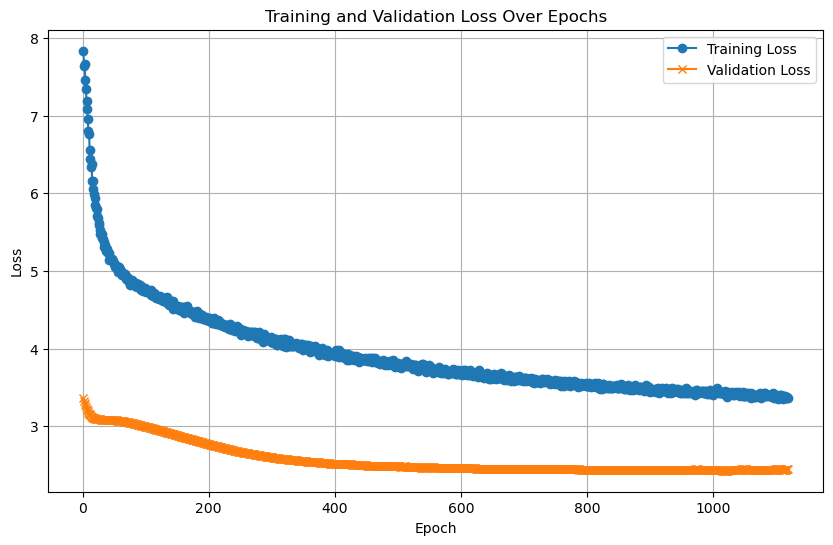

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/11], Loss: 4.8388

Test Loss: 5.2082


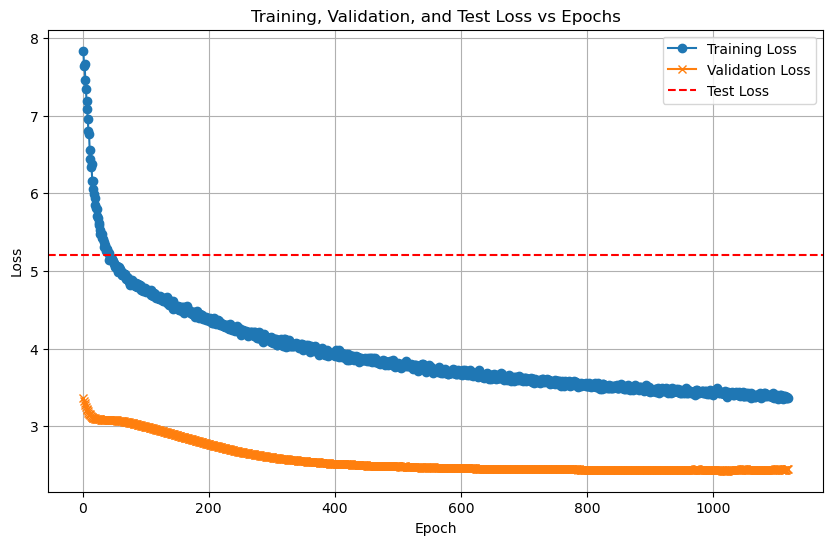

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/11 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 87.14%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       0.83      1.00      0.91         5
           4       1.00      0.80      0.89         5
           5       0.67      0.80      0.73         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       0.75      0.60      0.67         5
           9       0.80      0.80      0.80         5
          10       1.00      0.80      0.89         5
          11       0.80      0.80      0.80         5
          12       0.67      0.80      0.73         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9212  |  Val Loss: 2.8701
Validation loss improved from inf to 2.8701.
[Epoch 2/1000] Train Loss: 2.8120  |  Val Loss: 2.7694
Validation loss improved from 2.8701 to 2.7694.
[Epoch 3/1000] Train Loss: 2.7132  |  Val Loss: 2.6805
Validation loss improved from 2.7694 to 2.6805.
[Epoch 4/1000] Train Loss: 2.6329  |  Val Loss: 2.6102
Validation loss improved from 2.6805 to 2.6102.
[Epoch 5/1000] Train Loss: 2.5688  |  Val Loss: 2.5516
Validation loss improved from 2.6102 to 2.5516.
[Epoch 6/1000] Train Loss: 2.5107  |  Val Loss: 2.4978
Validation loss improved from 2.5516 to 2.4978.


[Epoch 7/1000] Train Loss: 2.4562  |  Val Loss: 2.4537


Validation loss improved from 2.4978 to 2.4537.
[Epoch 8/1000] Train Loss: 2.4127  |  Val Loss: 2.4141
Validation loss improved from 2.4537 to 2.4141.
[Epoch 9/1000] Train Loss: 2.3714  |  Val Loss: 2.3789
Validation loss improved from 2.4141 to 2.3789.
[Epoch 10/1000] Train Loss: 2.3328  |  Val Loss: 2.3424
Validation loss improved from 2.3789 to 2.3424.
[Epoch 11/1000] Train Loss: 2.2912  |  Val Loss: 2.2998
Validation loss improved from 2.3424 to 2.2998.


[Epoch 12/1000] Train Loss: 2.2438  |  Val Loss: 2.2586
Validation loss improved from 2.2998 to 2.2586.
[Epoch 13/1000] Train Loss: 2.1988  |  Val Loss: 2.2197
Validation loss improved from 2.2586 to 2.2197.
[Epoch 14/1000] Train Loss: 2.1573  |  Val Loss: 2.1838
Validation loss improved from 2.2197 to 2.1838.
[Epoch 15/1000] Train Loss: 2.1184  |  Val Loss: 2.1490
Validation loss improved from 2.1838 to 2.1490.
[Epoch 16/1000] Train Loss: 2.0810  |  Val Loss: 2.1141
Validation loss improved from 2.1490 to 2.1141.
[Epoch 17/1000] Train Loss: 2.0438  |  Val Loss: 2.0793
Validation loss improved from 2.1141 to 2.0793.
[Epoch 18/1000] Train Loss: 2.0069  |  Val Loss: 2.0457
Validation loss improved from 2.0793 to 2.0457.


[Epoch 19/1000] Train Loss: 1.9718  |  Val Loss: 2.0115
Validation loss improved from 2.0457 to 2.0115.
[Epoch 20/1000] Train Loss: 1.9352  |  Val Loss: 1.9776
Validation loss improved from 2.0115 to 1.9776.
[Epoch 21/1000] Train Loss: 1.9001  |  Val Loss: 1.9441
Validation loss improved from 1.9776 to 1.9441.
[Epoch 22/1000] Train Loss: 1.8648  |  Val Loss: 1.9110
Validation loss improved from 1.9441 to 1.9110.
[Epoch 23/1000] Train Loss: 1.8301  |  Val Loss: 1.8781
Validation loss improved from 1.9110 to 1.8781.


[Epoch 24/1000] Train Loss: 1.7957  |  Val Loss: 1.8448
Validation loss improved from 1.8781 to 1.8448.
[Epoch 25/1000] Train Loss: 1.7595  |  Val Loss: 1.8098
Validation loss improved from 1.8448 to 1.8098.
[Epoch 26/1000] Train Loss: 1.7227  |  Val Loss: 1.7746
Validation loss improved from 1.8098 to 1.7746.
[Epoch 27/1000] Train Loss: 1.6867  |  Val Loss: 1.7401
Validation loss improved from 1.7746 to 1.7401.
[Epoch 28/1000] Train Loss: 1.6521  |  Val Loss: 1.7072
Validation loss improved from 1.7401 to 1.7072.
[Epoch 29/1000] Train Loss: 1.6188  |  Val Loss: 1.6753
Validation loss improved from 1.7072 to 1.6753.


[Epoch 30/1000] Train Loss: 1.5869  |  Val Loss: 1.6440
Validation loss improved from 1.6753 to 1.6440.
[Epoch 31/1000] Train Loss: 1.5553  |  Val Loss: 1.6127
Validation loss improved from 1.6440 to 1.6127.
[Epoch 32/1000] Train Loss: 1.5240  |  Val Loss: 1.5826
Validation loss improved from 1.6127 to 1.5826.
[Epoch 33/1000] Train Loss: 1.4935  |  Val Loss: 1.5540
Validation loss improved from 1.5826 to 1.5540.
[Epoch 34/1000] Train Loss: 1.4635  |  Val Loss: 1.5267
Validation loss improved from 1.5540 to 1.5267.
[Epoch 35/1000] Train Loss: 1.4355  |  Val Loss: 1.5001
Validation loss improved from 1.5267 to 1.5001.


[Epoch 36/1000] Train Loss: 1.4073  |  Val Loss: 1.4749
Validation loss improved from 1.5001 to 1.4749.
[Epoch 37/1000] Train Loss: 1.3808  |  Val Loss: 1.4503
Validation loss improved from 1.4749 to 1.4503.
[Epoch 38/1000] Train Loss: 1.3541  |  Val Loss: 1.4266
Validation loss improved from 1.4503 to 1.4266.
[Epoch 39/1000] Train Loss: 1.3286  |  Val Loss: 1.4036
Validation loss improved from 1.4266 to 1.4036.
[Epoch 40/1000] Train Loss: 1.3032  |  Val Loss: 1.3814
Validation loss improved from 1.4036 to 1.3814.


[Epoch 41/1000] Train Loss: 1.2786  |  Val Loss: 1.3596
Validation loss improved from 1.3814 to 1.3596.
[Epoch 42/1000] Train Loss: 1.2543  |  Val Loss: 1.3385
Validation loss improved from 1.3596 to 1.3385.
[Epoch 43/1000] Train Loss: 1.2305  |  Val Loss: 1.3179
Validation loss improved from 1.3385 to 1.3179.
[Epoch 44/1000] Train Loss: 1.2073  |  Val Loss: 1.2973
Validation loss improved from 1.3179 to 1.2973.
[Epoch 45/1000] Train Loss: 1.1839  |  Val Loss: 1.2773
Validation loss improved from 1.2973 to 1.2773.
[Epoch 46/1000] Train Loss: 1.1609  |  Val Loss: 1.2575
Validation loss improved from 1.2773 to 1.2575.


[Epoch 47/1000] Train Loss: 1.1382  |  Val Loss: 1.2380
Validation loss improved from 1.2575 to 1.2380.
[Epoch 48/1000] Train Loss: 1.1159  |  Val Loss: 1.2189
Validation loss improved from 1.2380 to 1.2189.
[Epoch 49/1000] Train Loss: 1.0937  |  Val Loss: 1.1996
Validation loss improved from 1.2189 to 1.1996.
[Epoch 50/1000] Train Loss: 1.0718  |  Val Loss: 1.1802
Validation loss improved from 1.1996 to 1.1802.
[Epoch 51/1000] Train Loss: 1.0495  |  Val Loss: 1.1615
Validation loss improved from 1.1802 to 1.1615.


[Epoch 52/1000] Train Loss: 1.0276  |  Val Loss: 1.1428
Validation loss improved from 1.1615 to 1.1428.
[Epoch 53/1000] Train Loss: 1.0054  |  Val Loss: 1.1237
Validation loss improved from 1.1428 to 1.1237.
[Epoch 54/1000] Train Loss: 0.9835  |  Val Loss: 1.1050
Validation loss improved from 1.1237 to 1.1050.
[Epoch 55/1000] Train Loss: 0.9622  |  Val Loss: 1.0858
Validation loss improved from 1.1050 to 1.0858.
[Epoch 56/1000] Train Loss: 0.9406  |  Val Loss: 1.0663
Validation loss improved from 1.0858 to 1.0663.
[Epoch 57/1000] Train Loss: 0.9193  |  Val Loss: 1.0484
Validation loss improved from 1.0663 to 1.0484.
[Epoch 58/1000] Train Loss: 0.8985  |  Val Loss: 1.0298
Validation loss improved from 1.0484 to 1.0298.
[Epoch 59/1000] Train Loss: 0.8777  |  Val Loss: 1.0122
Validation loss improved from 1.0298 to 1.0122.


[Epoch 60/1000] Train Loss: 0.8581  |  Val Loss: 0.9947
Validation loss improved from 1.0122 to 0.9947.
[Epoch 61/1000] Train Loss: 0.8384  |  Val Loss: 0.9780
Validation loss improved from 0.9947 to 0.9780.
[Epoch 62/1000] Train Loss: 0.8187  |  Val Loss: 0.9614
Validation loss improved from 0.9780 to 0.9614.


[Epoch 63/1000] Train Loss: 0.8001  |  Val Loss: 0.9452
Validation loss improved from 0.9614 to 0.9452.
[Epoch 64/1000] Train Loss: 0.7816  |  Val Loss: 0.9291
Validation loss improved from 0.9452 to 0.9291.
[Epoch 65/1000] Train Loss: 0.7631  |  Val Loss: 0.9140
Validation loss improved from 0.9291 to 0.9140.
[Epoch 66/1000] Train Loss: 0.7452  |  Val Loss: 0.8981
Validation loss improved from 0.9140 to 0.8981.
[Epoch 67/1000] Train Loss: 0.7276  |  Val Loss: 0.8826
Validation loss improved from 0.8981 to 0.8826.
[Epoch 68/1000] Train Loss: 0.7100  |  Val Loss: 0.8674
Validation loss improved from 0.8826 to 0.8674.
[Epoch 69/1000] Train Loss: 0.6929  |  Val Loss: 0.8518
Validation loss improved from 0.8674 to 0.8518.
[Epoch 70/1000] Train Loss: 0.6758  |  Val Loss: 0.8371
Validation loss improved from 0.8518 to 0.8371.


[Epoch 71/1000] Train Loss: 0.6589  |  Val Loss: 0.8228
Validation loss improved from 0.8371 to 0.8228.
[Epoch 72/1000] Train Loss: 0.6424  |  Val Loss: 0.8090
Validation loss improved from 0.8228 to 0.8090.
[Epoch 73/1000] Train Loss: 0.6264  |  Val Loss: 0.7940
Validation loss improved from 0.8090 to 0.7940.


[Epoch 74/1000] Train Loss: 0.6099  |  Val Loss: 0.7811
Validation loss improved from 0.7940 to 0.7811.
[Epoch 75/1000] Train Loss: 0.5940  |  Val Loss: 0.7670
Validation loss improved from 0.7811 to 0.7670.
[Epoch 76/1000] Train Loss: 0.5778  |  Val Loss: 0.7539
Validation loss improved from 0.7670 to 0.7539.
[Epoch 77/1000] Train Loss: 0.5620  |  Val Loss: 0.7398
Validation loss improved from 0.7539 to 0.7398.
[Epoch 78/1000] Train Loss: 0.5461  |  Val Loss: 0.7261
Validation loss improved from 0.7398 to 0.7261.
[Epoch 79/1000] Train Loss: 0.5304  |  Val Loss: 0.7130
Validation loss improved from 0.7261 to 0.7130.
[Epoch 80/1000] Train Loss: 0.5153  |  Val Loss: 0.6989
Validation loss improved from 0.7130 to 0.6989.
[Epoch 81/1000] Train Loss: 0.5003  |  Val Loss: 0.6869
Validation loss improved from 0.6989 to 0.6869.
[Epoch 82/1000] Train Loss: 0.4854  |  Val Loss: 0.6743
Validation loss improved from 0.6869 to 0.6743.
[Epoch 83/1000] Train Loss: 0.4707  |  Val Loss: 0.6610
Validati

[Epoch 84/1000] Train Loss: 0.4560  |  Val Loss: 0.6493
Validation loss improved from 0.6610 to 0.6493.


[Epoch 85/1000] Train Loss: 0.4419  |  Val Loss: 0.6376
Validation loss improved from 0.6493 to 0.6376.
[Epoch 86/1000] Train Loss: 0.4280  |  Val Loss: 0.6258
Validation loss improved from 0.6376 to 0.6258.
[Epoch 87/1000] Train Loss: 0.4143  |  Val Loss: 0.6146
Validation loss improved from 0.6258 to 0.6146.
[Epoch 88/1000] Train Loss: 0.4006  |  Val Loss: 0.6024
Validation loss improved from 0.6146 to 0.6024.
[Epoch 89/1000] Train Loss: 0.3876  |  Val Loss: 0.5921
Validation loss improved from 0.6024 to 0.5921.
[Epoch 90/1000] Train Loss: 0.3745  |  Val Loss: 0.5801
Validation loss improved from 0.5921 to 0.5801.
[Epoch 91/1000] Train Loss: 0.3616  |  Val Loss: 0.5705
Validation loss improved from 0.5801 to 0.5705.
[Epoch 92/1000] Train Loss: 0.3493  |  Val Loss: 0.5602
Validation loss improved from 0.5705 to 0.5602.
[Epoch 93/1000] Train Loss: 0.3370  |  Val Loss: 0.5505
Validation loss improved from 0.5602 to 0.5505.
[Epoch 94/1000] Train Loss: 0.3253  |  Val Loss: 0.5404
Validati

[Epoch 96/1000] Train Loss: 0.3029  |  Val Loss: 0.5220
Validation loss improved from 0.5313 to 0.5220.
[Epoch 97/1000] Train Loss: 0.2917  |  Val Loss: 0.5139
Validation loss improved from 0.5220 to 0.5139.
[Epoch 98/1000] Train Loss: 0.2817  |  Val Loss: 0.5054
Validation loss improved from 0.5139 to 0.5054.
[Epoch 99/1000] Train Loss: 0.2716  |  Val Loss: 0.4969
Validation loss improved from 0.5054 to 0.4969.
[Epoch 100/1000] Train Loss: 0.2614  |  Val Loss: 0.4896
Validation loss improved from 0.4969 to 0.4896.
[Epoch 101/1000] Train Loss: 0.2524  |  Val Loss: 0.4829
Validation loss improved from 0.4896 to 0.4829.
[Epoch 102/1000] Train Loss: 0.2435  |  Val Loss: 0.4762
Validation loss improved from 0.4829 to 0.4762.
[Epoch 103/1000] Train Loss: 0.2350  |  Val Loss: 0.4698
Validation loss improved from 0.4762 to 0.4698.
[Epoch 104/1000] Train Loss: 0.2265  |  Val Loss: 0.4644
Validation loss improved from 0.4698 to 0.4644.
[Epoch 105/1000] Train Loss: 0.2187  |  Val Loss: 0.4579
Va

[Epoch 107/1000] Train Loss: 0.2040  |  Val Loss: 0.4491
Validation loss improved from 0.4533 to 0.4491.
[Epoch 108/1000] Train Loss: 0.1971  |  Val Loss: 0.4434
Validation loss improved from 0.4491 to 0.4434.
[Epoch 109/1000] Train Loss: 0.1904  |  Val Loss: 0.4389
Validation loss improved from 0.4434 to 0.4389.
[Epoch 110/1000] Train Loss: 0.1840  |  Val Loss: 0.4346
Validation loss improved from 0.4389 to 0.4346.
[Epoch 111/1000] Train Loss: 0.1780  |  Val Loss: 0.4309
Validation loss improved from 0.4346 to 0.4309.
[Epoch 112/1000] Train Loss: 0.1721  |  Val Loss: 0.4263
Validation loss improved from 0.4309 to 0.4263.
[Epoch 113/1000] Train Loss: 0.1666  |  Val Loss: 0.4236
Validation loss improved from 0.4263 to 0.4236.
[Epoch 114/1000] Train Loss: 0.1614  |  Val Loss: 0.4195
Validation loss improved from 0.4236 to 0.4195.
[Epoch 115/1000] Train Loss: 0.1562  |  Val Loss: 0.4162
Validation loss improved from 0.4195 to 0.4162.
[Epoch 116/1000] Train Loss: 0.1513  |  Val Loss: 0.413

[Epoch 118/1000] Train Loss: 0.1423  |  Val Loss: 0.4079
Validation loss improved from 0.4112 to 0.4079.
[Epoch 119/1000] Train Loss: 0.1378  |  Val Loss: 0.4055
Validation loss improved from 0.4079 to 0.4055.
[Epoch 120/1000] Train Loss: 0.1340  |  Val Loss: 0.4024
Validation loss improved from 0.4055 to 0.4024.
[Epoch 121/1000] Train Loss: 0.1300  |  Val Loss: 0.4002
Validation loss improved from 0.4024 to 0.4002.
[Epoch 122/1000] Train Loss: 0.1263  |  Val Loss: 0.3987
Validation loss improved from 0.4002 to 0.3987.
[Epoch 123/1000] Train Loss: 0.1228  |  Val Loss: 0.3967
Validation loss improved from 0.3987 to 0.3967.
[Epoch 124/1000] Train Loss: 0.1195  |  Val Loss: 0.3946
Validation loss improved from 0.3967 to 0.3946.
[Epoch 125/1000] Train Loss: 0.1160  |  Val Loss: 0.3933
Validation loss improved from 0.3946 to 0.3933.
[Epoch 126/1000] Train Loss: 0.1128  |  Val Loss: 0.3914
Validation loss improved from 0.3933 to 0.3914.
[Epoch 127/1000] Train Loss: 0.1099  |  Val Loss: 0.389

[Epoch 129/1000] Train Loss: 0.1043  |  Val Loss: 0.3864
Validation loss improved from 0.3887 to 0.3864.
[Epoch 130/1000] Train Loss: 0.1014  |  Val Loss: 0.3851
Validation loss improved from 0.3864 to 0.3851.
[Epoch 131/1000] Train Loss: 0.0990  |  Val Loss: 0.3835
Validation loss improved from 0.3851 to 0.3835.
[Epoch 132/1000] Train Loss: 0.0964  |  Val Loss: 0.3831
Validation loss improved from 0.3835 to 0.3831.
[Epoch 133/1000] Train Loss: 0.0942  |  Val Loss: 0.3833
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 134/1000] Train Loss: 0.0918  |  Val Loss: 0.3822
Validation loss improved from 0.3831 to 0.3822.
[Epoch 135/1000] Train Loss: 0.0896  |  Val Loss: 0.3805
Validation loss improved from 0.3822 to 0.3805.
[Epoch 136/1000] Train Loss: 0.0874  |  Val Loss: 0.3794
Validation loss improved from 0.3805 to 0.3794.
[Epoch 137/1000] Train Loss: 0.0854  |  Val Loss: 0.3789
Validation loss improved from 0.3794 to 0.3789.
[Epoch 138/1000] Train Loss: 0.0835  |  Val Loss:

[Epoch 141/1000] Train Loss: 0.0780  |  Val Loss: 0.3775
Validation loss improved from 0.3779 to 0.3775.
[Epoch 142/1000] Train Loss: 0.0763  |  Val Loss: 0.3774
Validation loss improved from 0.3775 to 0.3774.
[Epoch 143/1000] Train Loss: 0.0747  |  Val Loss: 0.3768
Validation loss improved from 0.3774 to 0.3768.
[Epoch 144/1000] Train Loss: 0.0730  |  Val Loss: 0.3749
Validation loss improved from 0.3768 to 0.3749.
[Epoch 145/1000] Train Loss: 0.0715  |  Val Loss: 0.3756
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 146/1000] Train Loss: 0.0700  |  Val Loss: 0.3759
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 147/1000] Train Loss: 0.0686  |  Val Loss: 0.3756
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 148/1000] Train Loss: 0.0672  |  Val Loss: 0.3757
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 149/1000] Train Loss: 0.0659  |  Val Loss: 0.3758
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 150/1000] Train Lo

[Epoch 153/1000] Train Loss: 0.0607  |  Val Loss: 0.3756
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 154/1000] Train Loss: 0.0597  |  Val Loss: 0.3745
Validation loss improved from 0.3749 to 0.3745.
[Epoch 155/1000] Train Loss: 0.0585  |  Val Loss: 0.3744
Validation loss improved from 0.3745 to 0.3744.
[Epoch 156/1000] Train Loss: 0.0574  |  Val Loss: 0.3748
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 0.0563  |  Val Loss: 0.3749
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 158/1000] Train Loss: 0.0552  |  Val Loss: 0.3742
Validation loss improved from 0.3744 to 0.3742.
[Epoch 159/1000] Train Loss: 0.0544  |  Val Loss: 0.3739
Validation loss improved from 0.3742 to 0.3739.
[Epoch 160/1000] Train Loss: 0.0533  |  Val Loss: 0.3740
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 161/1000] Train Loss: 0.0522  |  Val Loss: 0.3732
Validation loss improved from 0.3739 to 0.3732.
[Epoch 162/1000] Train Loss: 0.

[Epoch 163/1000] Train Loss: 0.0506  |  Val Loss: 0.3751
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 164/1000] Train Loss: 0.0496  |  Val Loss: 0.3748
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 165/1000] Train Loss: 0.0487  |  Val Loss: 0.3739
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 166/1000] Train Loss: 0.0479  |  Val Loss: 0.3739
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 167/1000] Train Loss: 0.0471  |  Val Loss: 0.3750
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 168/1000] Train Loss: 0.0463  |  Val Loss: 0.3744
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 169/1000] Train Loss: 0.0456  |  Val Loss: 0.3757
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 170/1000] Train Loss: 0.0448  |  Val Loss: 0.3757
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 171/1000] Train Loss: 0.0441  |  Val Loss: 0.3760
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 175/1000] Train Loss: 0.0413  |  Val Loss: 0.3769
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 176/1000] Train Loss: 0.0407  |  Val Loss: 0.3771
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 177/1000] Train Loss: 0.0400  |  Val Loss: 0.3776
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 178/1000] Train Loss: 0.0396  |  Val Loss: 0.3777
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 179/1000] Train Loss: 0.0388  |  Val Loss: 0.3784
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 180/1000] Train Loss: 0.0383  |  Val Loss: 0.3783
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 181/1000] Train Loss: 0.0377  |  Val Loss: 0.3794
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 182/1000] Train Loss: 0.0372  |  Val Loss: 0.3800
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 183/1000] Train Loss: 0.0366  |  Val Loss: 0.3808
!! Validation loss did NOT improve !! Patience:

[Epoch 186/1000] Train Loss: 0.0350  |  Val Loss: 0.3798
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 187/1000] Train Loss: 0.0345  |  Val Loss: 0.3798
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 188/1000] Train Loss: 0.0340  |  Val Loss: 0.3809
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 189/1000] Train Loss: 0.0335  |  Val Loss: 0.3818
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 190/1000] Train Loss: 0.0331  |  Val Loss: 0.3829
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 191/1000] Train Loss: 0.0326  |  Val Loss: 0.3836
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 192/1000] Train Loss: 0.0322  |  Val Loss: 0.3848
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 193/1000] Train Loss: 0.0317  |  Val Loss: 0.3838
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 194/1000] Train Loss: 0.0313  |  Val Loss: 0.3836
!! Validation loss did NOT improve !! Patience:

[Epoch 197/1000] Train Loss: 0.0301  |  Val Loss: 0.3858
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 198/1000] Train Loss: 0.0298  |  Val Loss: 0.3855
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 199/1000] Train Loss: 0.0293  |  Val Loss: 0.3869
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 200/1000] Train Loss: 0.0289  |  Val Loss: 0.3863
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 201/1000] Train Loss: 0.0286  |  Val Loss: 0.3877
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 202/1000] Train Loss: 0.0283  |  Val Loss: 0.3887
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 203/1000] Train Loss: 0.0278  |  Val Loss: 0.3890
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 204/1000] Train Loss: 0.0276  |  Val Loss: 0.3879
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 205/1000] Train Loss: 0.0271  |  Val Loss: 0.3889
!! Validation loss did NOT improve !! Patience:

[Epoch 209/1000] Train Loss: 0.0258  |  Val Loss: 0.3913
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 210/1000] Train Loss: 0.0255  |  Val Loss: 0.3913
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 211/1000] Train Loss: 0.0252  |  Val Loss: 0.3927
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 212/1000] Train Loss: 0.0249  |  Val Loss: 0.3926
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 213/1000] Train Loss: 0.0246  |  Val Loss: 0.3933
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 214/1000] Train Loss: 0.0243  |  Val Loss: 0.3939
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 215/1000] Train Loss: 0.0240  |  Val Loss: 0.3944
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 216/1000] Train Loss: 0.0237  |  Val Loss: 0.3950
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 217/1000] Train Loss: 0.0235  |  Val Loss: 0.3958
!! Validation loss did NOT improve !! Patience:

[Epoch 221/1000] Train Loss: 0.0224  |  Val Loss: 0.3972
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 222/1000] Train Loss: 0.0222  |  Val Loss: 0.3991
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 223/1000] Train Loss: 0.0220  |  Val Loss: 0.3985
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 224/1000] Train Loss: 0.0218  |  Val Loss: 0.3990
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 225/1000] Train Loss: 0.0215  |  Val Loss: 0.4000
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 226/1000] Train Loss: 0.0212  |  Val Loss: 0.3999
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 227/1000] Train Loss: 0.0210  |  Val Loss: 0.4005
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 228/1000] Train Loss: 0.0208  |  Val Loss: 0.4001
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 229/1000] Train Loss: 0.0206  |  Val Loss: 0.4007
!! Validation loss did NOT improve !! Patience:

[Epoch 234/1000] Train Loss: 0.0195  |  Val Loss: 0.4028
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 235/1000] Train Loss: 0.0193  |  Val Loss: 0.4038
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 236/1000] Train Loss: 0.0190  |  Val Loss: 0.4044
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 237/1000] Train Loss: 0.0189  |  Val Loss: 0.4048
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 238/1000] Train Loss: 0.0187  |  Val Loss: 0.4058
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 239/1000] Train Loss: 0.0185  |  Val Loss: 0.4072
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 240/1000] Train Loss: 0.0183  |  Val Loss: 0.4075
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 241/1000] Train Loss: 0.0181  |  Val Loss: 0.4078
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 242/1000] Train Loss: 0.0179  |  Val Loss: 0.4079
!! Validation loss did NOT improve !! Patience:

[Epoch 246/1000] Train Loss: 0.0172  |  Val Loss: 0.4089
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 247/1000] Train Loss: 0.0170  |  Val Loss: 0.4108
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 248/1000] Train Loss: 0.0169  |  Val Loss: 0.4112
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 249/1000] Train Loss: 0.0167  |  Val Loss: 0.4124
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 250/1000] Train Loss: 0.0166  |  Val Loss: 0.4135
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 251/1000] Train Loss: 0.0164  |  Val Loss: 0.4143
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 252/1000] Train Loss: 0.0163  |  Val Loss: 0.4137
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 253/1000] Train Loss: 0.0161  |  Val Loss: 0.4136
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 254/1000] Train Loss: 0.0159  |  Val Loss: 0.4152
!! Validation loss did NOT improve !! Patience:

[Epoch 258/1000] Train Loss: 0.0153  |  Val Loss: 0.4170
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 259/1000] Train Loss: 0.0152  |  Val Loss: 0.4172
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 260/1000] Train Loss: 0.0151  |  Val Loss: 0.4195
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 261/1000] Train Loss: 0.0149  |  Val Loss: 0.4200
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 261 !!
No improvement for 100 epochs.


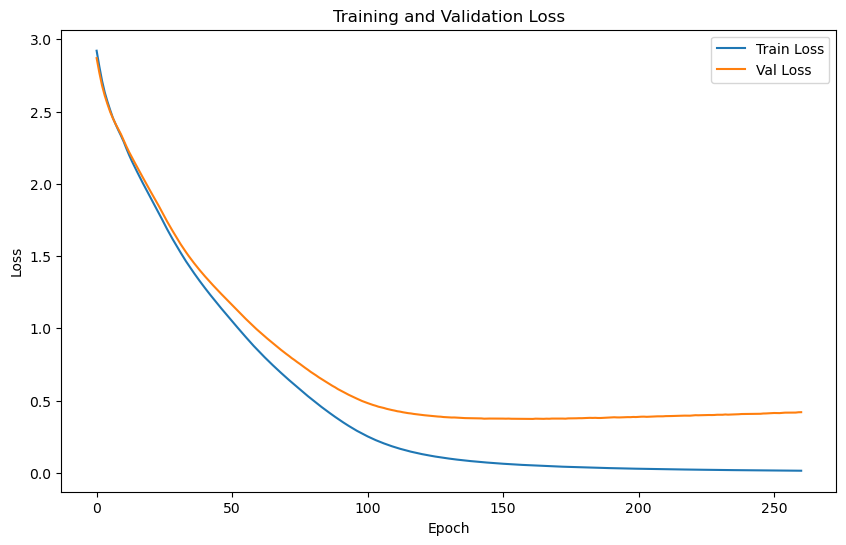

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.4308 | Test Accuracy: 88.88%


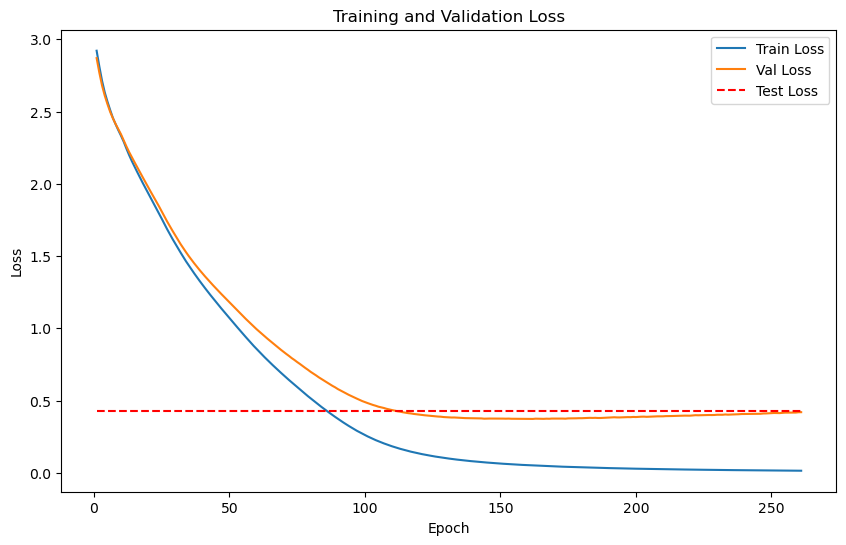

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)


Train embeddings shape: (560, 64), 
Train labels shape: (560,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2618, 64), 
Test labels shape: (2618,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4817
    Batch [2/2], Train Loss: 0.4769
LOG: Epoch [1/2000] - Validation


    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.1442
Epoch [1/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.2969

Validation loss improved from inf to 0.2969. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4768


    Batch [2/2], Train Loss: 0.4721
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.1477
Epoch [2/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.2983

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 0.4771


    Batch [2/2], Train Loss: 0.4730
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.1503
Epoch [3/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.2994

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.4731
    Batch [2/2], Train Loss: 0.4744
LOG: Epoch [4/2000] - Validation


    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.1562
Epoch [4/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.3021

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 0.4751


    Batch [2/2], Train Loss: 0.4713
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4477
    Batch [2/2], Val Loss: 0.1659
Epoch [5/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.3068

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/2], Train Loss: 0.4746
    Batch [2/2], Train Loss: 0.4706
LOG: Epoch [6/2000] - Validation


    Batch [1/2], Val Loss: 0.4468
    Batch [2/2], Val Loss: 0.1787
Epoch [6/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.3128

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.4691
    Batch [2/2], Train Loss: 0.4719
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.4457
    Batch [2/2], Val Loss: 0.1785
Epoch [7/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.3121

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4694


    Batch [2/2], Train Loss: 0.4696
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4446
    Batch [2/2], Val Loss: 0.1702
Epoch [8/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4696


    Batch [2/2], Train Loss: 0.4679
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4438
    Batch [2/2], Val Loss: 0.1647
Epoch [9/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.3043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4673
    Batch [2/2], Train Loss: 0.4650
LOG: Epoch [10/2000] - Validation


    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.1656
Epoch [10/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.3033

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4661


    Batch [2/2], Train Loss: 0.4646
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4386
    Batch [2/2], Val Loss: 0.1579
Epoch [11/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.2983

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.4644
    Batch [2/2], Train Loss: 0.4639
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.4375
    Batch [2/2], Val Loss: 0.1513
Epoch [12/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.2944

Validation loss improved from 0.2969 to 0.2944. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.4628


    Batch [2/2], Train Loss: 0.4631
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.1468
Epoch [13/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.2914

Validation loss improved from 0.2944 to 0.2914. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 0.4604


    Batch [2/2], Train Loss: 0.4602
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4339
    Batch [2/2], Val Loss: 0.1418
Epoch [14/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.2879

Validation loss improved from 0.2914 to 0.2879. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/2], Train Loss: 0.4602
    Batch [2/2], Train Loss: 0.4569
LOG: Epoch [15/2000] - Validation


    Batch [1/2], Val Loss: 0.4316
    Batch [2/2], Val Loss: 0.1375
Epoch [15/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.2846

Validation loss improved from 0.2879 to 0.2846. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.4574


    Batch [2/2], Train Loss: 0.4565
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4311
    Batch [2/2], Val Loss: 0.1361
Epoch [16/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.2836

Validation loss improved from 0.2846 to 0.2836. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4544
    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [17/2000] - Validation


    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.1359
Epoch [17/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.2832

Validation loss improved from 0.2836 to 0.2832. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.4550


    Batch [2/2], Train Loss: 0.4534
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4295
    Batch [2/2], Val Loss: 0.1364
Epoch [18/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.2830

Validation loss improved from 0.2832 to 0.2830. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/2], Train Loss: 0.4522
    Batch [2/2], Train Loss: 0.4547
LOG: Epoch [19/2000] - Validation


    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.1365
Epoch [19/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.2826

Validation loss improved from 0.2830 to 0.2826. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/2], Train Loss: 0.4521


    Batch [2/2], Train Loss: 0.4501
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.1365
Epoch [20/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.2823

Validation loss improved from 0.2826 to 0.2823. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4480
    Batch [2/2], Train Loss: 0.4434
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.1367
Epoch [21/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.2819

Validation loss improved from 0.2823 to 0.2819. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.4464


    Batch [2/2], Train Loss: 0.4468
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1368
Epoch [22/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.2812

Validation loss improved from 0.2819 to 0.2812. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.4486
    Batch [2/2], Train Loss: 0.4465
LOG: Epoch [23/2000] - Validation


    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.1366
Epoch [23/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.2802

Validation loss improved from 0.2812 to 0.2802. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.4448


    Batch [2/2], Train Loss: 0.4478
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4225
    Batch [2/2], Val Loss: 0.1358
Epoch [24/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.2791

Validation loss improved from 0.2802 to 0.2791. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.4412
    Batch [2/2], Train Loss: 0.4467
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.4212
    Batch [2/2], Val Loss: 0.1353
Epoch [25/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.2783

Validation loss improved from 0.2791 to 0.2783. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.4439


    Batch [2/2], Train Loss: 0.4420
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1350
Epoch [26/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.2774

Validation loss improved from 0.2783 to 0.2774. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.4438
    Batch [2/2], Train Loss: 0.4455
LOG: Epoch [27/2000] - Validation


    Batch [1/2], Val Loss: 0.4183
    Batch [2/2], Val Loss: 0.1347
Epoch [27/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.2765

Validation loss improved from 0.2774 to 0.2765. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.4436


    Batch [2/2], Train Loss: 0.4398
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.1340
Epoch [28/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.2752

Validation loss improved from 0.2765 to 0.2752. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.4355
    Batch [2/2], Train Loss: 0.4462
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1336
Epoch [29/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.2741

Validation loss improved from 0.2752 to 0.2741. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.4455


    Batch [2/2], Train Loss: 0.4373
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.1332
Epoch [30/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.2729

Validation loss improved from 0.2741 to 0.2729. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.4406
    Batch [2/2], Train Loss: 0.4377
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.1329
Epoch [31/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.2719

Validation loss improved from 0.2729 to 0.2719. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.4387


    Batch [2/2], Train Loss: 0.4385
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.1328
Epoch [32/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.2707

Validation loss improved from 0.2719 to 0.2707. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.4325
    Batch [2/2], Train Loss: 0.4311
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.4069
    Batch [2/2], Val Loss: 0.1332
Epoch [33/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.2701

Validation loss improved from 0.2707 to 0.2701. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 0.4327


    Batch [2/2], Train Loss: 0.4335
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1339
Epoch [34/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.2698

Validation loss improved from 0.2701 to 0.2698. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.4395
    Batch [2/2], Train Loss: 0.4323
LOG: Epoch [35/2000] - Validation


    Batch [1/2], Val Loss: 0.4047
    Batch [2/2], Val Loss: 0.1347
Epoch [35/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.2697

Validation loss improved from 0.2698 to 0.2697. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.4307


    Batch [2/2], Train Loss: 0.4322
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4038
    Batch [2/2], Val Loss: 0.1357
Epoch [36/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2697

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.4285
    Batch [2/2], Train Loss: 0.4314
LOG: Epoch [37/2000] - Validation


    Batch [1/2], Val Loss: 0.4028
    Batch [2/2], Val Loss: 0.1367
Epoch [37/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.2698

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.4239


    Batch [2/2], Train Loss: 0.4257
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.1367
Epoch [38/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2692

Validation loss improved from 0.2697 to 0.2692. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4277
    Batch [2/2], Train Loss: 0.4326
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.4001
    Batch [2/2], Val Loss: 0.1371
Epoch [39/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.2686

Validation loss improved from 0.2692 to 0.2686. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 0.4248


    Batch [2/2], Train Loss: 0.4303
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3985
    Batch [2/2], Val Loss: 0.1377
Epoch [40/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.2681

Validation loss improved from 0.2686 to 0.2681. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.4282
    Batch [2/2], Train Loss: 0.4241
LOG: Epoch [41/2000] - Validation


    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.1382
Epoch [41/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2676

Validation loss improved from 0.2681 to 0.2676. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.4252


    Batch [2/2], Train Loss: 0.4251
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.3957
    Batch [2/2], Val Loss: 0.1391
Epoch [42/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.2674

Validation loss improved from 0.2676 to 0.2674. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.4240
    Batch [2/2], Train Loss: 0.4250
LOG: Epoch [43/2000] - Validation


    Batch [1/2], Val Loss: 0.3946
    Batch [2/2], Val Loss: 0.1386
Epoch [43/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2666

Validation loss improved from 0.2674 to 0.2666. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 0.4272


    Batch [2/2], Train Loss: 0.4227
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.3938
    Batch [2/2], Val Loss: 0.1380
Epoch [44/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2659

Validation loss improved from 0.2666 to 0.2659. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/2], Train Loss: 0.4227
    Batch [2/2], Train Loss: 0.4214
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.1377
Epoch [45/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2654

Validation loss improved from 0.2659 to 0.2654. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.4110
    Batch [2/2], Train Loss: 0.4236
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.1373
Epoch [46/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2650

Validation loss improved from 0.2654 to 0.2650. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.4238


    Batch [2/2], Train Loss: 0.4155
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.3925
    Batch [2/2], Val Loss: 0.1371
Epoch [47/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2648

Validation loss improved from 0.2650 to 0.2648. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.4212
    Batch [2/2], Train Loss: 0.4159
LOG: Epoch [48/2000] - Validation


    Batch [1/2], Val Loss: 0.3925
    Batch [2/2], Val Loss: 0.1370
Epoch [48/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2648

Validation loss improved from 0.2648 to 0.2648. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.4176
    Batch [2/2], Train Loss: 0.4179
LOG: Epoch [49/2000] - Validation


    Batch [1/2], Val Loss: 0.3929
    Batch [2/2], Val Loss: 0.1369
Epoch [49/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.2649

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 0.4145


    Batch [2/2], Train Loss: 0.4127
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.1362
Epoch [50/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2646

Validation loss improved from 0.2648 to 0.2646. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.4156
    Batch [2/2], Train Loss: 0.4154
LOG: Epoch [51/2000] - Validation


    Batch [1/2], Val Loss: 0.3929
    Batch [2/2], Val Loss: 0.1355
Epoch [51/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.2642

Validation loss improved from 0.2646 to 0.2642. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.4139


    Batch [2/2], Train Loss: 0.4124
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.1348
Epoch [52/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2639

Validation loss improved from 0.2642 to 0.2639. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.4063
    Batch [2/2], Train Loss: 0.4073
LOG: Epoch [53/2000] - Validation


    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.1345
Epoch [53/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2637

Validation loss improved from 0.2639 to 0.2637. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 0.4100


    Batch [2/2], Train Loss: 0.4120
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.3928
    Batch [2/2], Val Loss: 0.1345
Epoch [54/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2636

Validation loss improved from 0.2637 to 0.2636. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.4089


    Batch [2/2], Train Loss: 0.4106
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3921
    Batch [2/2], Val Loss: 0.1339
Epoch [55/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2630

Validation loss improved from 0.2636 to 0.2630. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.4052


    Batch [2/2], Train Loss: 0.4088
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.3914
    Batch [2/2], Val Loss: 0.1337
Epoch [56/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2626

Validation loss improved from 0.2630 to 0.2626. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/2], Train Loss: 0.4074
    Batch [2/2], Train Loss: 0.4078
LOG: Epoch [57/2000] - Validation


    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.1335
Epoch [57/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2619

Validation loss improved from 0.2626 to 0.2619. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 0.4027


    Batch [2/2], Train Loss: 0.4020
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.3888
    Batch [2/2], Val Loss: 0.1332
Epoch [58/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2610

Validation loss improved from 0.2619 to 0.2610. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/2], Train Loss: 0.4064
    Batch [2/2], Train Loss: 0.4034
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3879
    Batch [2/2], Val Loss: 0.1326
Epoch [59/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2603

Validation loss improved from 0.2610 to 0.2603. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.4014
    Batch [2/2], Train Loss: 0.4030
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.1322
Epoch [60/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2596

Validation loss improved from 0.2603 to 0.2596. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.4052
    Batch [2/2], Train Loss: 0.4052
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.1314
Epoch [61/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2588

Validation loss improved from 0.2596 to 0.2588. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.3941


    Batch [2/2], Train Loss: 0.4032
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.3856
    Batch [2/2], Val Loss: 0.1306
Epoch [62/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2581

Validation loss improved from 0.2588 to 0.2581. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.4074
    Batch [2/2], Train Loss: 0.3945
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.3857
    Batch [2/2], Val Loss: 0.1285
Epoch [63/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2571

Validation loss improved from 0.2581 to 0.2571. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.4025


    Batch [2/2], Train Loss: 0.3943
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.3859
    Batch [2/2], Val Loss: 0.1261
Epoch [64/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2560

Validation loss improved from 0.2571 to 0.2560. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/2], Train Loss: 0.3926
    Batch [2/2], Train Loss: 0.3963
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.1247
Epoch [65/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2551

Validation loss improved from 0.2560 to 0.2551. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.4001


    Batch [2/2], Train Loss: 0.3958
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.3851
    Batch [2/2], Val Loss: 0.1220
Epoch [66/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.2535

Validation loss improved from 0.2551 to 0.2535. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3975
    Batch [2/2], Train Loss: 0.3907
LOG: Epoch [67/2000] - Validation


    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.1184
Epoch [67/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2519

Validation loss improved from 0.2535 to 0.2519. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 0.3996


    Batch [2/2], Train Loss: 0.3937
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.1150
Epoch [68/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2505

Validation loss improved from 0.2519 to 0.2505. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/2], Train Loss: 0.3907
    Batch [2/2], Train Loss: 0.3900
LOG: Epoch [69/2000] - Validation


    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.1127
Epoch [69/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2497

Validation loss improved from 0.2505 to 0.2497. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 0.3927


    Batch [2/2], Train Loss: 0.3886
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.1113
Epoch [70/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2488

Validation loss improved from 0.2497 to 0.2488. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.3939
    Batch [2/2], Train Loss: 0.3927
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.1099
Epoch [71/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2482

Validation loss improved from 0.2488 to 0.2482. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.3898
    Batch [2/2], Train Loss: 0.3921
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.1093
Epoch [72/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2480

Validation loss improved from 0.2482 to 0.2480. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.3909


    Batch [2/2], Train Loss: 0.3889
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3858
    Batch [2/2], Val Loss: 0.1094
Epoch [73/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2476

Validation loss improved from 0.2480 to 0.2476. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.3933
    Batch [2/2], Train Loss: 0.3879
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.1094
Epoch [74/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2466

Validation loss improved from 0.2476 to 0.2466. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/2], Train Loss: 0.3856
    Batch [2/2], Train Loss: 0.3886
LOG: Epoch [75/2000] - Validation


    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1099
Epoch [75/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2456

Validation loss improved from 0.2466 to 0.2456. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 0.3940


    Batch [2/2], Train Loss: 0.3823
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.3789
    Batch [2/2], Val Loss: 0.1092
Epoch [76/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2441

Validation loss improved from 0.2456 to 0.2441. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.3822
    Batch [2/2], Train Loss: 0.3860
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.3770
    Batch [2/2], Val Loss: 0.1091
Epoch [77/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2431

Validation loss improved from 0.2441 to 0.2431. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.3846
    Batch [2/2], Train Loss: 0.3772
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.1086
Epoch [78/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2417

Validation loss improved from 0.2431 to 0.2417. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3800


    Batch [2/2], Train Loss: 0.3768
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3724
    Batch [2/2], Val Loss: 0.1074
Epoch [79/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2399

Validation loss improved from 0.2417 to 0.2399. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3867
    Batch [2/2], Train Loss: 0.3860
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.3705
    Batch [2/2], Val Loss: 0.1061
Epoch [80/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2383

Validation loss improved from 0.2399 to 0.2383. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/2], Train Loss: 0.3831
    Batch [2/2], Train Loss: 0.3798
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.3694
    Batch [2/2], Val Loss: 0.1058
Epoch [81/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2376

Validation loss improved from 0.2383 to 0.2376. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 0.3786


    Batch [2/2], Train Loss: 0.3831
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.1048
Epoch [82/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2363

Validation loss improved from 0.2376 to 0.2363. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.3816
    Batch [2/2], Train Loss: 0.3836
LOG: Epoch [83/2000] - Validation


    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.1038
Epoch [83/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2354

Validation loss improved from 0.2363 to 0.2354. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3840
    Batch [2/2], Train Loss: 0.3758
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.1026
Epoch [84/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2345

Validation loss improved from 0.2354 to 0.2345. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3701


    Batch [2/2], Train Loss: 0.3757
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3659
    Batch [2/2], Val Loss: 0.1014
Epoch [85/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2336

Validation loss improved from 0.2345 to 0.2336. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3814
    Batch [2/2], Train Loss: 0.3749
LOG: Epoch [86/2000] - Validation


    Batch [1/2], Val Loss: 0.3654
    Batch [2/2], Val Loss: 0.1005
Epoch [86/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2329

Validation loss improved from 0.2336 to 0.2329. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 0.3723


    Batch [2/2], Train Loss: 0.3752
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3650
    Batch [2/2], Val Loss: 0.0996
Epoch [87/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.2323

Validation loss improved from 0.2329 to 0.2323. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.3785


    Batch [2/2], Train Loss: 0.3749
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0995
Epoch [88/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2320

Validation loss improved from 0.2323 to 0.2320. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.3812
    Batch [2/2], Train Loss: 0.3759
LOG: Epoch [89/2000] - Validation


    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0989
Epoch [89/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2316

Validation loss improved from 0.2320 to 0.2316. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.3744


    Batch [2/2], Train Loss: 0.3715
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0988
Epoch [90/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.2306

Validation loss improved from 0.2316 to 0.2306. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/2], Train Loss: 0.3731
    Batch [2/2], Train Loss: 0.3739
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0988
Epoch [91/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2297

Validation loss improved from 0.2306 to 0.2297. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.3712


    Batch [2/2], Train Loss: 0.3751
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.0982
Epoch [92/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2288

Validation loss improved from 0.2297 to 0.2288. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.3639
    Batch [2/2], Train Loss: 0.3699
LOG: Epoch [93/2000] - Validation


    Batch [1/2], Val Loss: 0.3590
    Batch [2/2], Val Loss: 0.0978
Epoch [93/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2284

Validation loss improved from 0.2288 to 0.2284. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.3686


    Batch [2/2], Train Loss: 0.3741
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.3583
    Batch [2/2], Val Loss: 0.0971
Epoch [94/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2277

Validation loss improved from 0.2284 to 0.2277. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3617
    Batch [2/2], Train Loss: 0.3726
LOG: Epoch [95/2000] - Validation


    Batch [1/2], Val Loss: 0.3579
    Batch [2/2], Val Loss: 0.0957
Epoch [95/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2268

Validation loss improved from 0.2277 to 0.2268. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.3642


    Batch [2/2], Train Loss: 0.3708
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.3582
    Batch [2/2], Val Loss: 0.0944
Epoch [96/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2263

Validation loss improved from 0.2268 to 0.2263. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.3573
    Batch [2/2], Train Loss: 0.3613
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.3580
    Batch [2/2], Val Loss: 0.0931
Epoch [97/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.2256

Validation loss improved from 0.2263 to 0.2256. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.3738


    Batch [2/2], Train Loss: 0.3576
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3581
    Batch [2/2], Val Loss: 0.0917
Epoch [98/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2249

Validation loss improved from 0.2256 to 0.2249. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3687
    Batch [2/2], Train Loss: 0.3646
LOG: Epoch [99/2000] - Validation


    Batch [1/2], Val Loss: 0.3578
    Batch [2/2], Val Loss: 0.0905
Epoch [99/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2242

Validation loss improved from 0.2249 to 0.2242. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.3551


    Batch [2/2], Train Loss: 0.3656
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.3574
    Batch [2/2], Val Loss: 0.0899
Epoch [100/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.2237

Validation loss improved from 0.2242 to 0.2237. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.3651
    Batch [2/2], Train Loss: 0.3675
LOG: Epoch [101/2000] - Validation


    Batch [1/2], Val Loss: 0.3567
    Batch [2/2], Val Loss: 0.0904
Epoch [101/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2236

Validation loss improved from 0.2237 to 0.2236. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 0.3562


    Batch [2/2], Train Loss: 0.3600
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.3563
    Batch [2/2], Val Loss: 0.0911
Epoch [102/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.3627
    Batch [2/2], Train Loss: 0.3577
LOG: Epoch [103/2000] - Validation


    Batch [1/2], Val Loss: 0.3560
    Batch [2/2], Val Loss: 0.0910
Epoch [103/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2235

Validation loss improved from 0.2236 to 0.2235. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.3615


    Batch [2/2], Train Loss: 0.3598
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.0906
Epoch [104/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2232

Validation loss improved from 0.2235 to 0.2232. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.3545
    Batch [2/2], Train Loss: 0.3601
LOG: Epoch [105/2000] - Validation


    Batch [1/2], Val Loss: 0.3546
    Batch [2/2], Val Loss: 0.0899
Epoch [105/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.2223

Validation loss improved from 0.2232 to 0.2223. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 0.3628


    Batch [2/2], Train Loss: 0.3573
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.3525
    Batch [2/2], Val Loss: 0.0897
Epoch [106/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.2211

Validation loss improved from 0.2223 to 0.2211. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.3598
    Batch [2/2], Train Loss: 0.3550
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.3514
    Batch [2/2], Val Loss: 0.0896
Epoch [107/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.2205

Validation loss improved from 0.2211 to 0.2205. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 0.3539


    Batch [2/2], Train Loss: 0.3555
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.3498
    Batch [2/2], Val Loss: 0.0887
Epoch [108/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.2192

Validation loss improved from 0.2205 to 0.2192. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.3570
    Batch [2/2], Train Loss: 0.3498
LOG: Epoch [109/2000] - Validation


    Batch [1/2], Val Loss: 0.3489
    Batch [2/2], Val Loss: 0.0870
Epoch [109/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2179

Validation loss improved from 0.2192 to 0.2179. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 0.3495


    Batch [2/2], Train Loss: 0.3583
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.0855
Epoch [110/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2168

Validation loss improved from 0.2179 to 0.2168. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.3585
    Batch [2/2], Train Loss: 0.3517
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.0846
Epoch [111/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2164

Validation loss improved from 0.2168 to 0.2164. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.3575


    Batch [2/2], Train Loss: 0.3527
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.3476
    Batch [2/2], Val Loss: 0.0841
Epoch [112/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2158

Validation loss improved from 0.2164 to 0.2158. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.3570
    Batch [2/2], Train Loss: 0.3561
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.0836
Epoch [113/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.2158

Validation loss improved from 0.2158 to 0.2158. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.3592


    Batch [2/2], Train Loss: 0.3485
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.0836
Epoch [114/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2158

Validation loss improved from 0.2158 to 0.2158. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.3424
    Batch [2/2], Train Loss: 0.3554
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.3475
    Batch [2/2], Val Loss: 0.0837
Epoch [115/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2156

Validation loss improved from 0.2158 to 0.2156. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 0.3472


    Batch [2/2], Train Loss: 0.3516
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.3474
    Batch [2/2], Val Loss: 0.0831
Epoch [116/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2152

Validation loss improved from 0.2156 to 0.2152. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.3410
    Batch [2/2], Train Loss: 0.3508
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.0817
Epoch [117/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2147

Validation loss improved from 0.2152 to 0.2147. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.3532


    Batch [2/2], Train Loss: 0.3476
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.3493
    Batch [2/2], Val Loss: 0.0806
Epoch [118/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.3458
    Batch [2/2], Train Loss: 0.3472
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.3492
    Batch [2/2], Val Loss: 0.0798
Epoch [119/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2145

Validation loss improved from 0.2147 to 0.2145. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.3520


    Batch [2/2], Train Loss: 0.3392
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.0791
Epoch [120/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2139

Validation loss improved from 0.2145 to 0.2139. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/2], Train Loss: 0.3441
    Batch [2/2], Train Loss: 0.3480
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.0787
Epoch [121/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2135

Validation loss improved from 0.2139 to 0.2135. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 0.3384


    Batch [2/2], Train Loss: 0.3467
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.0786
Epoch [122/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2134

Validation loss improved from 0.2135 to 0.2134. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.3468
    Batch [2/2], Train Loss: 0.3362
LOG: Epoch [123/2000] - Validation


    Batch [1/2], Val Loss: 0.3473
    Batch [2/2], Val Loss: 0.0788
Epoch [123/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2130

Validation loss improved from 0.2134 to 0.2130. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.3402


    Batch [2/2], Train Loss: 0.3479
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.3465
    Batch [2/2], Val Loss: 0.0789
Epoch [124/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2127

Validation loss improved from 0.2130 to 0.2127. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/2], Train Loss: 0.3470
    Batch [2/2], Train Loss: 0.3456
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.3456
    Batch [2/2], Val Loss: 0.0792
Epoch [125/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2124

Validation loss improved from 0.2127 to 0.2124. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 0.3473


    Batch [2/2], Train Loss: 0.3364
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.0794
Epoch [126/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2120

Validation loss improved from 0.2124 to 0.2120. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/2], Train Loss: 0.3384
    Batch [2/2], Train Loss: 0.3362
LOG: Epoch [127/2000] - Validation


    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.0798
Epoch [127/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.2119

Validation loss improved from 0.2120 to 0.2119. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.3431


    Batch [2/2], Train Loss: 0.3455
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.3430
    Batch [2/2], Val Loss: 0.0800
Epoch [128/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2115

Validation loss improved from 0.2119 to 0.2115. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.3415
    Batch [2/2], Train Loss: 0.3425
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.3413
    Batch [2/2], Val Loss: 0.0792
Epoch [129/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2103

Validation loss improved from 0.2115 to 0.2103. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 0.3352


    Batch [2/2], Train Loss: 0.3432
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.3401
    Batch [2/2], Val Loss: 0.0788
Epoch [130/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.2095

Validation loss improved from 0.2103 to 0.2095. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.3415
    Batch [2/2], Train Loss: 0.3340
LOG: Epoch [131/2000] - Validation


    Batch [1/2], Val Loss: 0.3403
    Batch [2/2], Val Loss: 0.0779
Epoch [131/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.2091

Validation loss improved from 0.2095 to 0.2091. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.3429


    Batch [2/2], Train Loss: 0.3371
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.3399
    Batch [2/2], Val Loss: 0.0773
Epoch [132/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2086

Validation loss improved from 0.2091 to 0.2086. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.3360
    Batch [2/2], Train Loss: 0.3393
LOG: Epoch [133/2000] - Validation


    Batch [1/2], Val Loss: 0.3395
    Batch [2/2], Val Loss: 0.0770
Epoch [133/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2082

Validation loss improved from 0.2086 to 0.2082. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 0.3423


    Batch [2/2], Train Loss: 0.3443
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.3383
    Batch [2/2], Val Loss: 0.0764
Epoch [134/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2074

Validation loss improved from 0.2082 to 0.2074. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.3398
    Batch [2/2], Train Loss: 0.3365
LOG: Epoch [135/2000] - Validation


    Batch [1/2], Val Loss: 0.3373
    Batch [2/2], Val Loss: 0.0766
Epoch [135/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.2070

Validation loss improved from 0.2074 to 0.2070. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 0.3355


    Batch [2/2], Train Loss: 0.3304
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.3366
    Batch [2/2], Val Loss: 0.0762
Epoch [136/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.2064

Validation loss improved from 0.2070 to 0.2064. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.3388
    Batch [2/2], Train Loss: 0.3257
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.3366
    Batch [2/2], Val Loss: 0.0752
Epoch [137/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.2059

Validation loss improved from 0.2064 to 0.2059. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.3299


    Batch [2/2], Train Loss: 0.3346
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.3365
    Batch [2/2], Val Loss: 0.0746
Epoch [138/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.2055

Validation loss improved from 0.2059 to 0.2055. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.3283
    Batch [2/2], Train Loss: 0.3322
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.3373
    Batch [2/2], Val Loss: 0.0742
Epoch [139/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.2058

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.3337


    Batch [2/2], Train Loss: 0.3370
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.3376
    Batch [2/2], Val Loss: 0.0736
Epoch [140/2000], Avg Train Loss: 0.3354, Avg Val Loss: 0.2056

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.3325
    Batch [2/2], Train Loss: 0.3377
LOG: Epoch [141/2000] - Validation


    Batch [1/2], Val Loss: 0.3373
    Batch [2/2], Val Loss: 0.0736
Epoch [141/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.2055

Validation loss improved from 0.2055 to 0.2055. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 0.3368


    Batch [2/2], Train Loss: 0.3333
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.0739
Epoch [142/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.2057

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [143/2000] - Training


    Batch [1/2], Train Loss: 0.3281
    Batch [2/2], Train Loss: 0.3189
LOG: Epoch [143/2000] - Validation


    Batch [1/2], Val Loss: 0.3376
    Batch [2/2], Val Loss: 0.0744
Epoch [143/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2060

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 0.3311


    Batch [2/2], Train Loss: 0.3300
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.3383
    Batch [2/2], Val Loss: 0.0754
Epoch [144/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.2068

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 0.3254


    Batch [2/2], Train Loss: 0.3392
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.3395
    Batch [2/2], Val Loss: 0.0770
Epoch [145/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.2083

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [146/2000] - Training


    Batch [1/2], Train Loss: 0.3301
    Batch [2/2], Train Loss: 0.3264
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.3404
    Batch [2/2], Val Loss: 0.0776
Epoch [146/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.2090

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.3239


    Batch [2/2], Train Loss: 0.3311
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.3398
    Batch [2/2], Val Loss: 0.0780
Epoch [147/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 0.3297


    Batch [2/2], Train Loss: 0.3229
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.3368
    Batch [2/2], Val Loss: 0.0782
Epoch [148/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2075

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.3191


    Batch [2/2], Train Loss: 0.3197
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.0779
Epoch [149/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2064

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 0.3160
    Batch [2/2], Train Loss: 0.3227
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.0764
Epoch [150/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2051

Validation loss improved from 0.2055 to 0.2051. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 0.3214


    Batch [2/2], Train Loss: 0.3266
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.3342
    Batch [2/2], Val Loss: 0.0748
Epoch [151/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2045

Validation loss improved from 0.2051 to 0.2045. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.3217


    Batch [2/2], Train Loss: 0.3239
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.3342
    Batch [2/2], Val Loss: 0.0739
Epoch [152/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2040

Validation loss improved from 0.2045 to 0.2040. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.3197
    Batch [2/2], Train Loss: 0.3216
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.0735
Epoch [153/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.2036

Validation loss improved from 0.2040 to 0.2036. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 0.3205


    Batch [2/2], Train Loss: 0.3193
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.3329
    Batch [2/2], Val Loss: 0.0728
Epoch [154/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2028

Validation loss improved from 0.2036 to 0.2028. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.3200


    Batch [2/2], Train Loss: 0.3212
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.3329
    Batch [2/2], Val Loss: 0.0722
Epoch [155/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.2026

Validation loss improved from 0.2028 to 0.2026. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.3202
    Batch [2/2], Train Loss: 0.3240
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.3324
    Batch [2/2], Val Loss: 0.0712
Epoch [156/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2018

Validation loss improved from 0.2026 to 0.2018. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 0.3232


    Batch [2/2], Train Loss: 0.3257
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.3314
    Batch [2/2], Val Loss: 0.0711
Epoch [157/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.2012

Validation loss improved from 0.2018 to 0.2012. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.3177
    Batch [2/2], Train Loss: 0.3264
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.3307


    Batch [2/2], Val Loss: 0.0717
Epoch [158/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.2012

Validation loss improved from 0.2012 to 0.2012. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.3237


    Batch [2/2], Train Loss: 0.3207
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.3306
    Batch [2/2], Val Loss: 0.0724
Epoch [159/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2015

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.3151
    Batch [2/2], Train Loss: 0.3302
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.3315
    Batch [2/2], Val Loss: 0.0737
Epoch [160/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.2026

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.3140
    Batch [2/2], Train Loss: 0.3152
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.0742
Epoch [161/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.3128
    Batch [2/2], Train Loss: 0.3089
LOG: Epoch [162/2000] - Validation


    Batch [1/2], Val Loss: 0.3319
    Batch [2/2], Val Loss: 0.0735
Epoch [162/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.2027

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.3162


    Batch [2/2], Train Loss: 0.3190
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.3318
    Batch [2/2], Val Loss: 0.0721
Epoch [163/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2020

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.3186
    Batch [2/2], Train Loss: 0.3221
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.3316
    Batch [2/2], Val Loss: 0.0705
Epoch [164/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.2011

Validation loss improved from 0.2012 to 0.2011. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.3200


    Batch [2/2], Train Loss: 0.3102
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.3299
    Batch [2/2], Val Loss: 0.0696
Epoch [165/2000], Avg Train Loss: 0.3151, Avg Val Loss: 0.1997

Validation loss improved from 0.2011 to 0.1997. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.3108


    Batch [2/2], Train Loss: 0.3172
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.3285
    Batch [2/2], Val Loss: 0.0684
Epoch [166/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.1984

Validation loss improved from 0.1997 to 0.1984. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.3096
    Batch [2/2], Train Loss: 0.3212
LOG: Epoch [167/2000] - Validation


    Batch [1/2], Val Loss: 0.3274
    Batch [2/2], Val Loss: 0.0673
Epoch [167/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.1973

Validation loss improved from 0.1984 to 0.1973. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 0.3164


    Batch [2/2], Train Loss: 0.3190
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.3264
    Batch [2/2], Val Loss: 0.0659
Epoch [168/2000], Avg Train Loss: 0.3177, Avg Val Loss: 0.1962

Validation loss improved from 0.1973 to 0.1962. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.3127


    Batch [2/2], Train Loss: 0.3154
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.3271
    Batch [2/2], Val Loss: 0.0653
Epoch [169/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.1962

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.3194
    Batch [2/2], Train Loss: 0.3026
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.3297
    Batch [2/2], Val Loss: 0.0657
Epoch [170/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 0.3180


    Batch [2/2], Train Loss: 0.3072
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.3321
    Batch [2/2], Val Loss: 0.0665
Epoch [171/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.1993

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.3135
    Batch [2/2], Train Loss: 0.3082
LOG: Epoch [172/2000] - Validation


    Batch [1/2], Val Loss: 0.3322
    Batch [2/2], Val Loss: 0.0672
Epoch [172/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.1997

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 0.3131


    Batch [2/2], Train Loss: 0.3043
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.3301
    Batch [2/2], Val Loss: 0.0674
Epoch [173/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.1988

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [174/2000] - Training


    Batch [1/2], Train Loss: 0.3118
    Batch [2/2], Train Loss: 0.3086
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.3270
    Batch [2/2], Val Loss: 0.0677
Epoch [174/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.1974

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.3035


    Batch [2/2], Train Loss: 0.3135
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.3241
    Batch [2/2], Val Loss: 0.0684
Epoch [175/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.1963

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [176/2000] - Training


    Batch [1/2], Train Loss: 0.3069
    Batch [2/2], Train Loss: 0.3065
LOG: Epoch [176/2000] - Validation


    Batch [1/2], Val Loss: 0.3222
    Batch [2/2], Val Loss: 0.0690
Epoch [176/2000], Avg Train Loss: 0.3067, Avg Val Loss: 0.1956

Validation loss improved from 0.1962 to 0.1956. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 0.3181


    Batch [2/2], Train Loss: 0.3039
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.3217
    Batch [2/2], Val Loss: 0.0686
Epoch [177/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.1951

Validation loss improved from 0.1956 to 0.1951. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.3044
    Batch [2/2], Train Loss: 0.3024
LOG: Epoch [178/2000] - Validation


    Batch [1/2], Val Loss: 0.3222
    Batch [2/2], Val Loss: 0.0678
Epoch [178/2000], Avg Train Loss: 0.3034, Avg Val Loss: 0.1950

Validation loss improved from 0.1951 to 0.1950. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.3038
    Batch [2/2], Train Loss: 0.2942
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.3226
    Batch [2/2], Val Loss: 0.0665
Epoch [179/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.1945

Validation loss improved from 0.1950 to 0.1945. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.3020


    Batch [2/2], Train Loss: 0.3021
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.3229
    Batch [2/2], Val Loss: 0.0653
Epoch [180/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.1941

Validation loss improved from 0.1945 to 0.1941. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.3117
    Batch [2/2], Train Loss: 0.3067
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.3230
    Batch [2/2], Val Loss: 0.0639
Epoch [181/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.1935

Validation loss improved from 0.1941 to 0.1935. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.3089
    Batch [2/2], Train Loss: 0.3052
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.3224
    Batch [2/2], Val Loss: 0.0625
Epoch [182/2000], Avg Train Loss: 0.3071, Avg Val Loss: 0.1925

Validation loss improved from 0.1935 to 0.1925. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 0.3065


    Batch [2/2], Train Loss: 0.3022
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.3230
    Batch [2/2], Val Loss: 0.0615
Epoch [183/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.1923

Validation loss improved from 0.1925 to 0.1923. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 0.3033


    Batch [2/2], Train Loss: 0.3006
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.3241
    Batch [2/2], Val Loss: 0.0617
Epoch [184/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.1929

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [185/2000] - Training


    Batch [1/2], Train Loss: 0.2992
    Batch [2/2], Train Loss: 0.3100
LOG: Epoch [185/2000] - Validation


    Batch [1/2], Val Loss: 0.3241
    Batch [2/2], Val Loss: 0.0624
Epoch [185/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.1933

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.3094


    Batch [2/2], Train Loss: 0.3057
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3247
    Batch [2/2], Val Loss: 0.0621
Epoch [186/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.1934

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.2965
    Batch [2/2], Train Loss: 0.3035
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.3249
    Batch [2/2], Val Loss: 0.0625
Epoch [187/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.1937

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.3010


    Batch [2/2], Train Loss: 0.2954
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.3240
    Batch [2/2], Val Loss: 0.0627
Epoch [188/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.1934

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.2960
    Batch [2/2], Train Loss: 0.3025
LOG: Epoch [189/2000] - Validation


    Batch [1/2], Val Loss: 0.3235
    Batch [2/2], Val Loss: 0.0628
Epoch [189/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.1932

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 0.3092


    Batch [2/2], Train Loss: 0.2934
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3227
    Batch [2/2], Val Loss: 0.0625
Epoch [190/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.1926

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.3001
    Batch [2/2], Train Loss: 0.3025
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.3228
    Batch [2/2], Val Loss: 0.0614
Epoch [191/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.1921

Validation loss improved from 0.1923 to 0.1921. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.3091


    Batch [2/2], Train Loss: 0.3027
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3228
    Batch [2/2], Val Loss: 0.0606
Epoch [192/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.1917

Validation loss improved from 0.1921 to 0.1917. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.2991
    Batch [2/2], Train Loss: 0.2922
LOG: Epoch [193/2000] - Validation


    Batch [1/2], Val Loss: 0.3228
    Batch [2/2], Val Loss: 0.0599
Epoch [193/2000], Avg Train Loss: 0.2956, Avg Val Loss: 0.1913

Validation loss improved from 0.1917 to 0.1913. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.2937


    Batch [2/2], Train Loss: 0.2979
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3220
    Batch [2/2], Val Loss: 0.0592
Epoch [194/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.1906

Validation loss improved from 0.1913 to 0.1906. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.3019
    Batch [2/2], Train Loss: 0.2969
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.3206
    Batch [2/2], Val Loss: 0.0587
Epoch [195/2000], Avg Train Loss: 0.2994, Avg Val Loss: 0.1897

Validation loss improved from 0.1906 to 0.1897. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 0.2984


    Batch [2/2], Train Loss: 0.2936
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.3192
    Batch [2/2], Val Loss: 0.0588
Epoch [196/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.1890

Validation loss improved from 0.1897 to 0.1890. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.2972
    Batch [2/2], Train Loss: 0.2920
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.3186
    Batch [2/2], Val Loss: 0.0589
Epoch [197/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.1887

Validation loss improved from 0.1890 to 0.1887. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.2939
    Batch [2/2], Train Loss: 0.2945
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.3184
    Batch [2/2], Val Loss: 0.0599
Epoch [198/2000], Avg Train Loss: 0.2942, Avg Val Loss: 0.1892

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.2931
    Batch [2/2], Train Loss: 0.2919
LOG: Epoch [199/2000] - Validation


    Batch [1/2], Val Loss: 0.3188
    Batch [2/2], Val Loss: 0.0608
Epoch [199/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.1898

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.2981


    Batch [2/2], Train Loss: 0.2862
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.3208
    Batch [2/2], Val Loss: 0.0615
Epoch [200/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 0.3007


    Batch [2/2], Train Loss: 0.2926
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.3223
    Batch [2/2], Val Loss: 0.0619
Epoch [201/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.1921

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.2896
    Batch [2/2], Train Loss: 0.2919
LOG: Epoch [202/2000] - Validation


    Batch [1/2], Val Loss: 0.3239
    Batch [2/2], Val Loss: 0.0618
Epoch [202/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.1929

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.2981


    Batch [2/2], Train Loss: 0.2986
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.3236
    Batch [2/2], Val Loss: 0.0621
Epoch [203/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.1929

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.2873
    Batch [2/2], Train Loss: 0.3010
LOG: Epoch [204/2000] - Validation


    Batch [1/2], Val Loss: 0.3234
    Batch [2/2], Val Loss: 0.0620
Epoch [204/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.1927

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.2897


    Batch [2/2], Train Loss: 0.2928
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.3231
    Batch [2/2], Val Loss: 0.0612
Epoch [205/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.1922

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.2952
    Batch [2/2], Train Loss: 0.2912
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.3225
    Batch [2/2], Val Loss: 0.0608
Epoch [206/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.1917

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 0.2877


    Batch [2/2], Train Loss: 0.2872
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.3217
    Batch [2/2], Val Loss: 0.0613
Epoch [207/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.1915

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.3091
    Batch [2/2], Train Loss: 0.2807
LOG: Epoch [208/2000] - Validation


    Batch [1/2], Val Loss: 0.3197
    Batch [2/2], Val Loss: 0.0620
Epoch [208/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.2902


    Batch [2/2], Train Loss: 0.2849
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.3191
    Batch [2/2], Val Loss: 0.0620
Epoch [209/2000], Avg Train Loss: 0.2875, Avg Val Loss: 0.1906

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.2897
    Batch [2/2], Train Loss: 0.2837
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.3186
    Batch [2/2], Val Loss: 0.0628
Epoch [210/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.2808


    Batch [2/2], Train Loss: 0.2885
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.0631
Epoch [211/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.1901

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.2919
    Batch [2/2], Train Loss: 0.2893
LOG: Epoch [212/2000] - Validation


    Batch [1/2], Val Loss: 0.3156
    Batch [2/2], Val Loss: 0.0633
Epoch [212/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.1895

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.2858


    Batch [2/2], Train Loss: 0.2817
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.3144
    Batch [2/2], Val Loss: 0.0631
Epoch [213/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.1888

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.2944
    Batch [2/2], Train Loss: 0.2860
LOG: Epoch [214/2000] - Validation


    Batch [1/2], Val Loss: 0.3135
    Batch [2/2], Val Loss: 0.0628
Epoch [214/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.1882

Validation loss improved from 0.1887 to 0.1882. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.2894


    Batch [2/2], Train Loss: 0.2963
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.3126
    Batch [2/2], Val Loss: 0.0628
Epoch [215/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.1877

Validation loss improved from 0.1882 to 0.1877. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 0.2733
    Batch [2/2], Train Loss: 0.2826
LOG: Epoch [216/2000] - Validation


    Batch [1/2], Val Loss: 0.3122
    Batch [2/2], Val Loss: 0.0625
Epoch [216/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.1873

Validation loss improved from 0.1877 to 0.1873. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 0.2789


    Batch [2/2], Train Loss: 0.2841
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.3122
    Batch [2/2], Val Loss: 0.0619
Epoch [217/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.1871

Validation loss improved from 0.1873 to 0.1871. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.2865
    Batch [2/2], Train Loss: 0.2852
LOG: Epoch [218/2000] - Validation


    Batch [1/2], Val Loss: 0.3125
    Batch [2/2], Val Loss: 0.0611
Epoch [218/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.1868

Validation loss improved from 0.1871 to 0.1868. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.2741


    Batch [2/2], Train Loss: 0.2871
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.3127
    Batch [2/2], Val Loss: 0.0604
Epoch [219/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.1866

Validation loss improved from 0.1868 to 0.1866. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.2876
    Batch [2/2], Train Loss: 0.2801
LOG: Epoch [220/2000] - Validation


    Batch [1/2], Val Loss: 0.3127
    Batch [2/2], Val Loss: 0.0596
Epoch [220/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.1861

Validation loss improved from 0.1866 to 0.1861. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 0.2847


    Batch [2/2], Train Loss: 0.2848
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.3122
    Batch [2/2], Val Loss: 0.0589
Epoch [221/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.1855

Validation loss improved from 0.1861 to 0.1855. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.2853


    Batch [2/2], Train Loss: 0.2717
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.3130
    Batch [2/2], Val Loss: 0.0575
Epoch [222/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.1852

Validation loss improved from 0.1855 to 0.1852. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/2], Train Loss: 0.2827
    Batch [2/2], Train Loss: 0.2849
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.3123
    Batch [2/2], Val Loss: 0.0570
Epoch [223/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.1846

Validation loss improved from 0.1852 to 0.1846. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.2870


    Batch [2/2], Train Loss: 0.2804
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.3116
    Batch [2/2], Val Loss: 0.0569
Epoch [224/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.1843

Validation loss improved from 0.1846 to 0.1843. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.2824
    Batch [2/2], Train Loss: 0.2871
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.3105
    Batch [2/2], Val Loss: 0.0562
Epoch [225/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.1833

Validation loss improved from 0.1843 to 0.1833. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.2823


    Batch [2/2], Train Loss: 0.2825
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.3091
    Batch [2/2], Val Loss: 0.0560
Epoch [226/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.1826

Validation loss improved from 0.1833 to 0.1826. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.2772
    Batch [2/2], Train Loss: 0.2777
LOG: Epoch [227/2000] - Validation


    Batch [1/2], Val Loss: 0.3089
    Batch [2/2], Val Loss: 0.0559
Epoch [227/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.1824

Validation loss improved from 0.1826 to 0.1824. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.2719
    Batch [2/2], Train Loss: 0.2848
LOG: Epoch [228/2000] - Validation


    Batch [1/2], Val Loss: 0.3093
    Batch [2/2], Val Loss: 0.0561
Epoch [228/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.1827

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 0.2802


    Batch [2/2], Train Loss: 0.2826
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.3093
    Batch [2/2], Val Loss: 0.0571
Epoch [229/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.1832

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.2763
    Batch [2/2], Train Loss: 0.2865
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.3094
    Batch [2/2], Val Loss: 0.0576
Epoch [230/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.2753


    Batch [2/2], Train Loss: 0.2831
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.0577
Epoch [231/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.1842

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.2859
    Batch [2/2], Train Loss: 0.2735
LOG: Epoch [232/2000] - Validation


    Batch [1/2], Val Loss: 0.3129
    Batch [2/2], Val Loss: 0.0576
Epoch [232/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.1853

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.2809


    Batch [2/2], Train Loss: 0.2743
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.0575
Epoch [233/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.1862

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.2819
    Batch [2/2], Train Loss: 0.2736
LOG: Epoch [234/2000] - Validation


    Batch [1/2], Val Loss: 0.3147
    Batch [2/2], Val Loss: 0.0573
Epoch [234/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.1860

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 0.2811


    Batch [2/2], Train Loss: 0.2666
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.3144
    Batch [2/2], Val Loss: 0.0571
Epoch [235/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.1858

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.2784
    Batch [2/2], Train Loss: 0.2814
LOG: Epoch [236/2000] - Validation


    Batch [1/2], Val Loss: 0.3133
    Batch [2/2], Val Loss: 0.0573
Epoch [236/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.1853

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.2734


    Batch [2/2], Train Loss: 0.2808
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.3129
    Batch [2/2], Val Loss: 0.0581
Epoch [237/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.1855

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.2726
    Batch [2/2], Train Loss: 0.2787
LOG: Epoch [238/2000] - Validation


    Batch [1/2], Val Loss: 0.3122
    Batch [2/2], Val Loss: 0.0584
Epoch [238/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.1853

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.2769


    Batch [2/2], Train Loss: 0.2721
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.0574
Epoch [239/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.2748
    Batch [2/2], Train Loss: 0.2805
LOG: Epoch [240/2000] - Validation


    Batch [1/2], Val Loss: 0.3087
    Batch [2/2], Val Loss: 0.0562
Epoch [240/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.1824

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.2884


    Batch [2/2], Train Loss: 0.2707
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.3082
    Batch [2/2], Val Loss: 0.0548
Epoch [241/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.1815

Validation loss improved from 0.1824 to 0.1815. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.2690
    Batch [2/2], Train Loss: 0.2831
LOG: Epoch [242/2000] - Validation


    Batch [1/2], Val Loss: 0.3086
    Batch [2/2], Val Loss: 0.0534
Epoch [242/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.1810

Validation loss improved from 0.1815 to 0.1810. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.2727


    Batch [2/2], Train Loss: 0.2793
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.3091
    Batch [2/2], Val Loss: 0.0526
Epoch [243/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.1808

Validation loss improved from 0.1810 to 0.1808. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.2752
    Batch [2/2], Train Loss: 0.2724
LOG: Epoch [244/2000] - Validation


    Batch [1/2], Val Loss: 0.3099
    Batch [2/2], Val Loss: 0.0520
Epoch [244/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.1810

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 0.2703


    Batch [2/2], Train Loss: 0.2761
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.3104
    Batch [2/2], Val Loss: 0.0516
Epoch [245/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.1810

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.2644
    Batch [2/2], Train Loss: 0.2700
LOG: Epoch [246/2000] - Validation


    Batch [1/2], Val Loss: 0.3101
    Batch [2/2], Val Loss: 0.0517
Epoch [246/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.1809

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.2681
    Batch [2/2], Train Loss: 0.2684
LOG: Epoch [247/2000] - Validation


    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0523
Epoch [247/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.1816

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 0.2626


    Batch [2/2], Train Loss: 0.2695
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.3119
    Batch [2/2], Val Loss: 0.0533
Epoch [248/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.1826

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.2612
    Batch [2/2], Train Loss: 0.2729
LOG: Epoch [249/2000] - Validation


    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.0544
Epoch [249/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.1830

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 0.2704


    Batch [2/2], Train Loss: 0.2659
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.3114
    Batch [2/2], Val Loss: 0.0545
Epoch [250/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.1830

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.2659
    Batch [2/2], Train Loss: 0.2783
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.3110
    Batch [2/2], Val Loss: 0.0538
Epoch [251/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.1824

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.2782


    Batch [2/2], Train Loss: 0.2667
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.3103
    Batch [2/2], Val Loss: 0.0538
Epoch [252/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.1820

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.2621
    Batch [2/2], Train Loss: 0.2703
LOG: Epoch [253/2000] - Validation


    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.0541
Epoch [253/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.1825

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.2646


    Batch [2/2], Train Loss: 0.2634
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.3114
    Batch [2/2], Val Loss: 0.0549
Epoch [254/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.1832

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [255/2000] - Training


    Batch [1/2], Train Loss: 0.2703
    Batch [2/2], Train Loss: 0.2723
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.3121
    Batch [2/2], Val Loss: 0.0548
Epoch [255/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 0.2553


    Batch [2/2], Train Loss: 0.2545
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.3122
    Batch [2/2], Val Loss: 0.0548
Epoch [256/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.2722
    Batch [2/2], Train Loss: 0.2614
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.3130
    Batch [2/2], Val Loss: 0.0544
Epoch [257/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.1837

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.2676
    Batch [2/2], Train Loss: 0.2644
LOG: Epoch [258/2000] - Validation


    Batch [1/2], Val Loss: 0.3129
    Batch [2/2], Val Loss: 0.0543
Epoch [258/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.1836

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.2625


    Batch [2/2], Train Loss: 0.2582
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.3137
    Batch [2/2], Val Loss: 0.0539
Epoch [259/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.1838

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.2670
    Batch [2/2], Train Loss: 0.2755
LOG: Epoch [260/2000] - Validation


    Batch [1/2], Val Loss: 0.3125
    Batch [2/2], Val Loss: 0.0532
Epoch [260/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.1828

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.2666


    Batch [2/2], Train Loss: 0.2694
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.3097
    Batch [2/2], Val Loss: 0.0530
Epoch [261/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.1813

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.2620
    Batch [2/2], Train Loss: 0.2698
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.3067
    Batch [2/2], Val Loss: 0.0533
Epoch [262/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.1800

Validation loss improved from 0.1808 to 0.1800. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.2639


    Batch [2/2], Train Loss: 0.2654
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.3040
    Batch [2/2], Val Loss: 0.0536
Epoch [263/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.1788

Validation loss improved from 0.1800 to 0.1788. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.2643
    Batch [2/2], Train Loss: 0.2583
LOG: Epoch [264/2000] - Validation


    Batch [1/2], Val Loss: 0.3019
    Batch [2/2], Val Loss: 0.0536
Epoch [264/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.1777

Validation loss improved from 0.1788 to 0.1777. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.2630


    Batch [2/2], Train Loss: 0.2623
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.3006
    Batch [2/2], Val Loss: 0.0537
Epoch [265/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.1772

Validation loss improved from 0.1777 to 0.1772. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.2592
    Batch [2/2], Train Loss: 0.2624
LOG: Epoch [266/2000] - Validation


    Batch [1/2], Val Loss: 0.3003
    Batch [2/2], Val Loss: 0.0531
Epoch [266/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.1767

Validation loss improved from 0.1772 to 0.1767. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 0.2637


    Batch [2/2], Train Loss: 0.2701
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.3005
    Batch [2/2], Val Loss: 0.0527
Epoch [267/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.1766

Validation loss improved from 0.1767 to 0.1766. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.2610
    Batch [2/2], Train Loss: 0.2674
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.3012
    Batch [2/2], Val Loss: 0.0523
Epoch [268/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.1767

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.2558


    Batch [2/2], Train Loss: 0.2636
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.3008
    Batch [2/2], Val Loss: 0.0520
Epoch [269/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.1764

Validation loss improved from 0.1766 to 0.1764. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.2632
    Batch [2/2], Train Loss: 0.2649
LOG: Epoch [270/2000] - Validation


    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.0515
Epoch [270/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.1763

Validation loss improved from 0.1764 to 0.1763. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 0.2602


    Batch [2/2], Train Loss: 0.2560
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.3015
    Batch [2/2], Val Loss: 0.0510
Epoch [271/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.1763

Validation loss improved from 0.1763 to 0.1763. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.2583
    Batch [2/2], Train Loss: 0.2679
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.3022
    Batch [2/2], Val Loss: 0.0506
Epoch [272/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [273/2000] - Training


    Batch [1/2], Train Loss: 0.2641
    Batch [2/2], Train Loss: 0.2626
LOG: Epoch [273/2000] - Validation


    Batch [1/2], Val Loss: 0.3022
    Batch [2/2], Val Loss: 0.0500
Epoch [273/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.1761

Validation loss improved from 0.1763 to 0.1761. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 0.2583


    Batch [2/2], Train Loss: 0.2720
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.3022
    Batch [2/2], Val Loss: 0.0500
Epoch [274/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.1761

Validation loss improved from 0.1761 to 0.1761. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.2534
    Batch [2/2], Train Loss: 0.2592
LOG: Epoch [275/2000] - Validation


    Batch [1/2], Val Loss: 0.3018
    Batch [2/2], Val Loss: 0.0500
Epoch [275/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.1759

Validation loss improved from 0.1761 to 0.1759. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.2659


    Batch [2/2], Train Loss: 0.2635
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.3014
    Batch [2/2], Val Loss: 0.0503
Epoch [276/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.1759

Validation loss improved from 0.1759 to 0.1759. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/2], Train Loss: 0.2585
    Batch [2/2], Train Loss: 0.2594
LOG: Epoch [277/2000] - Validation


    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.0503
Epoch [277/2000], Avg Train Loss: 0.2590, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.2635


    Batch [2/2], Train Loss: 0.2572
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.3026
    Batch [2/2], Val Loss: 0.0506
Epoch [278/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.2529
    Batch [2/2], Train Loss: 0.2529
LOG: Epoch [279/2000] - Validation


    Batch [1/2], Val Loss: 0.3023
    Batch [2/2], Val Loss: 0.0513
Epoch [279/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 0.2516


    Batch [2/2], Train Loss: 0.2491
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.3022
    Batch [2/2], Val Loss: 0.0512
Epoch [280/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.1767

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.2649
    Batch [2/2], Train Loss: 0.2567
LOG: Epoch [281/2000] - Validation


    Batch [1/2], Val Loss: 0.3026
    Batch [2/2], Val Loss: 0.0506
Epoch [281/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 0.2522


    Batch [2/2], Train Loss: 0.2587
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.3020
    Batch [2/2], Val Loss: 0.0495
Epoch [282/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.1757

Validation loss improved from 0.1759 to 0.1757. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.2520
    Batch [2/2], Train Loss: 0.2425
LOG: Epoch [283/2000] - Validation


    Batch [1/2], Val Loss: 0.3012
    Batch [2/2], Val Loss: 0.0487
Epoch [283/2000], Avg Train Loss: 0.2473, Avg Val Loss: 0.1749

Validation loss improved from 0.1757 to 0.1749. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.2560


    Batch [2/2], Train Loss: 0.2584
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.0480
Epoch [284/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.1746

Validation loss improved from 0.1749 to 0.1746. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2419


    Batch [2/2], Train Loss: 0.2500
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.0487
Epoch [285/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.1749

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.2508
    Batch [2/2], Train Loss: 0.2441
LOG: Epoch [286/2000] - Validation


    Batch [1/2], Val Loss: 0.3005
    Batch [2/2], Val Loss: 0.0492
Epoch [286/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.1749

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.2621


    Batch [2/2], Train Loss: 0.2505
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2999
    Batch [2/2], Val Loss: 0.0489
Epoch [287/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.1744

Validation loss improved from 0.1746 to 0.1744. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/2], Train Loss: 0.2567
    Batch [2/2], Train Loss: 0.2461
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.2993
    Batch [2/2], Val Loss: 0.0489
Epoch [288/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.1741

Validation loss improved from 0.1744 to 0.1741. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 0.2562


    Batch [2/2], Train Loss: 0.2479
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2998
    Batch [2/2], Val Loss: 0.0495
Epoch [289/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.1746

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.2505
    Batch [2/2], Train Loss: 0.2607
LOG: Epoch [290/2000] - Validation


    Batch [1/2], Val Loss: 0.2994
    Batch [2/2], Val Loss: 0.0506
Epoch [290/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.1750

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.2461


    Batch [2/2], Train Loss: 0.2462
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.2993
    Batch [2/2], Val Loss: 0.0523
Epoch [291/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [292/2000] - Training


    Batch [1/2], Train Loss: 0.2504
    Batch [2/2], Train Loss: 0.2544
LOG: Epoch [292/2000] - Validation


    Batch [1/2], Val Loss: 0.2998
    Batch [2/2], Val Loss: 0.0538
Epoch [292/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.2548


    Batch [2/2], Train Loss: 0.2455
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.3003
    Batch [2/2], Val Loss: 0.0540
Epoch [293/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.2565
    Batch [2/2], Train Loss: 0.2399
LOG: Epoch [294/2000] - Validation


    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.0543
Epoch [294/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 0.2446


    Batch [2/2], Train Loss: 0.2512
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.3016
    Batch [2/2], Val Loss: 0.0541
Epoch [295/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.1779

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.2537


    Batch [2/2], Train Loss: 0.2573
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.0540
Epoch [296/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.1778

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2411
    Batch [2/2], Train Loss: 0.2515
LOG: Epoch [297/2000] - Validation


    Batch [1/2], Val Loss: 0.3024
    Batch [2/2], Val Loss: 0.0535
Epoch [297/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.1779

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 0.2479


    Batch [2/2], Train Loss: 0.2464
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.3038
    Batch [2/2], Val Loss: 0.0527
Epoch [298/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.1783

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [299/2000] - Training


    Batch [1/2], Train Loss: 0.2414
    Batch [2/2], Train Loss: 0.2514
LOG: Epoch [299/2000] - Validation


    Batch [1/2], Val Loss: 0.3048
    Batch [2/2], Val Loss: 0.0522
Epoch [299/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.1785

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 0.2523


    Batch [2/2], Train Loss: 0.2529
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.3057
    Batch [2/2], Val Loss: 0.0515
Epoch [300/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.1786

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.2439
    Batch [2/2], Train Loss: 0.2459
LOG: Epoch [301/2000] - Validation


    Batch [1/2], Val Loss: 0.3058
    Batch [2/2], Val Loss: 0.0512
Epoch [301/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.1785

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 0.2416


    Batch [2/2], Train Loss: 0.2372
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.3076
    Batch [2/2], Val Loss: 0.0515
Epoch [302/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.2501
    Batch [2/2], Train Loss: 0.2618
LOG: Epoch [303/2000] - Validation


    Batch [1/2], Val Loss: 0.3083
    Batch [2/2], Val Loss: 0.0510
Epoch [303/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.2447


    Batch [2/2], Train Loss: 0.2517
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.3086
    Batch [2/2], Val Loss: 0.0507
Epoch [304/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [305/2000] - Training


    Batch [1/2], Train Loss: 0.2426
    Batch [2/2], Train Loss: 0.2464
LOG: Epoch [305/2000] - Validation


    Batch [1/2], Val Loss: 0.3075
    Batch [2/2], Val Loss: 0.0506
Epoch [305/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.2558


    Batch [2/2], Train Loss: 0.2448
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.3071
    Batch [2/2], Val Loss: 0.0501
Epoch [306/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.1786

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.2437
    Batch [2/2], Train Loss: 0.2399
LOG: Epoch [307/2000] - Validation


    Batch [1/2], Val Loss: 0.3061
    Batch [2/2], Val Loss: 0.0494
Epoch [307/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [308/2000] - Training
    Batch [1/2], Train Loss: 0.2432


    Batch [2/2], Train Loss: 0.2405
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.3045
    Batch [2/2], Val Loss: 0.0488
Epoch [308/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [309/2000] - Training


    Batch [1/2], Train Loss: 0.2494


    Batch [2/2], Train Loss: 0.2429
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.0484
Epoch [309/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.1751

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.2406
    Batch [2/2], Train Loss: 0.2455
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.3008
    Batch [2/2], Val Loss: 0.0481
Epoch [310/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.1745

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.2415


    Batch [2/2], Train Loss: 0.2537
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.3002
    Batch [2/2], Val Loss: 0.0476
Epoch [311/2000], Avg Train Loss: 0.2476, Avg Val Loss: 0.1739

Validation loss improved from 0.1741 to 0.1739. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 0.2427


    Batch [2/2], Train Loss: 0.2401
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.2984
    Batch [2/2], Val Loss: 0.0480
Epoch [312/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.1732

Validation loss improved from 0.1739 to 0.1732. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 0.2378
    Batch [2/2], Train Loss: 0.2422
LOG: Epoch [313/2000] - Validation


    Batch [1/2], Val Loss: 0.2979
    Batch [2/2], Val Loss: 0.0486
Epoch [313/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.1732

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.2357


    Batch [2/2], Train Loss: 0.2436
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.3001
    Batch [2/2], Val Loss: 0.0484
Epoch [314/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.1742

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.2416
    Batch [2/2], Train Loss: 0.2463
LOG: Epoch [315/2000] - Validation


    Batch [1/2], Val Loss: 0.3014
    Batch [2/2], Val Loss: 0.0478
Epoch [315/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.1746

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 0.2510


    Batch [2/2], Train Loss: 0.2419
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.3019
    Batch [2/2], Val Loss: 0.0477
Epoch [316/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.1748

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [317/2000] - Training


    Batch [1/2], Train Loss: 0.2431
    Batch [2/2], Train Loss: 0.2446
LOG: Epoch [317/2000] - Validation


    Batch [1/2], Val Loss: 0.3025
    Batch [2/2], Val Loss: 0.0474
Epoch [317/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.1749

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.2408


    Batch [2/2], Train Loss: 0.2389
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.3021
    Batch [2/2], Val Loss: 0.0465
Epoch [318/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.1743

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.2371
    Batch [2/2], Train Loss: 0.2414
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.0464
Epoch [319/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.1741

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.2450


    Batch [2/2], Train Loss: 0.2388
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.3012
    Batch [2/2], Val Loss: 0.0472
Epoch [320/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.1742

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.2409
    Batch [2/2], Train Loss: 0.2352
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.3005
    Batch [2/2], Val Loss: 0.0476
Epoch [321/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.1740

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.2407
    Batch [2/2], Train Loss: 0.2460
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.2989
    Batch [2/2], Val Loss: 0.0474
Epoch [322/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.1731

Validation loss improved from 0.1732 to 0.1731. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 0.2369


    Batch [2/2], Train Loss: 0.2395
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.2982
    Batch [2/2], Val Loss: 0.0471
Epoch [323/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.1727

Validation loss improved from 0.1731 to 0.1727. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.2315
    Batch [2/2], Train Loss: 0.2344
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2976


    Batch [2/2], Val Loss: 0.0474
Epoch [324/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.1725

Validation loss improved from 0.1727 to 0.1725. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.2393


    Batch [2/2], Train Loss: 0.2417
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2979
    Batch [2/2], Val Loss: 0.0479
Epoch [325/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.1729

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.2428
    Batch [2/2], Train Loss: 0.2443
LOG: Epoch [326/2000] - Validation


    Batch [1/2], Val Loss: 0.2981
    Batch [2/2], Val Loss: 0.0481
Epoch [326/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.1731

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.2289


    Batch [2/2], Train Loss: 0.2419
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2974
    Batch [2/2], Val Loss: 0.0477
Epoch [327/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.1726

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.2307
    Batch [2/2], Train Loss: 0.2338
LOG: Epoch [328/2000] - Validation


    Batch [1/2], Val Loss: 0.2964
    Batch [2/2], Val Loss: 0.0469
Epoch [328/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.1716

Validation loss improved from 0.1725 to 0.1716. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 0.2405


    Batch [2/2], Train Loss: 0.2394
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.2959
    Batch [2/2], Val Loss: 0.0462
Epoch [329/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.1711

Validation loss improved from 0.1716 to 0.1711. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/2], Train Loss: 0.2410
    Batch [2/2], Train Loss: 0.2409
LOG: Epoch [330/2000] - Validation


    Batch [1/2], Val Loss: 0.2971
    Batch [2/2], Val Loss: 0.0457
Epoch [330/2000], Avg Train Loss: 0.2409, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 0.2339


    Batch [2/2], Train Loss: 0.2378
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.2991
    Batch [2/2], Val Loss: 0.0448
Epoch [331/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.1720

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.2369
    Batch [2/2], Train Loss: 0.2303
LOG: Epoch [332/2000] - Validation


    Batch [1/2], Val Loss: 0.3009
    Batch [2/2], Val Loss: 0.0442
Epoch [332/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.1726

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.2360
    Batch [2/2], Train Loss: 0.2304
LOG: Epoch [333/2000] - Validation


    Batch [1/2], Val Loss: 0.3019
    Batch [2/2], Val Loss: 0.0436
Epoch [333/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.1727

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.2344


    Batch [2/2], Train Loss: 0.2392
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.0434
Epoch [334/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.1722

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.2295
    Batch [2/2], Train Loss: 0.2367
LOG: Epoch [335/2000] - Validation


    Batch [1/2], Val Loss: 0.2994
    Batch [2/2], Val Loss: 0.0432
Epoch [335/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.2434


    Batch [2/2], Train Loss: 0.2320
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.2985
    Batch [2/2], Val Loss: 0.0435
Epoch [336/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.1710

Validation loss improved from 0.1711 to 0.1710. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.2357
    Batch [2/2], Train Loss: 0.2395
LOG: Epoch [337/2000] - Validation


    Batch [1/2], Val Loss: 0.2980
    Batch [2/2], Val Loss: 0.0441
Epoch [337/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.2266


    Batch [2/2], Train Loss: 0.2310
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.2970
    Batch [2/2], Val Loss: 0.0444
Epoch [338/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.1707

Validation loss improved from 0.1710 to 0.1707. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.2362
    Batch [2/2], Train Loss: 0.2271
LOG: Epoch [339/2000] - Validation


    Batch [1/2], Val Loss: 0.2944
    Batch [2/2], Val Loss: 0.0445
Epoch [339/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.1695

Validation loss improved from 0.1707 to 0.1695. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 0.2297


    Batch [2/2], Train Loss: 0.2342
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.0446
Epoch [340/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.1692

Validation loss improved from 0.1695 to 0.1692. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.2299
    Batch [2/2], Train Loss: 0.2277
LOG: Epoch [341/2000] - Validation


    Batch [1/2], Val Loss: 0.2937
    Batch [2/2], Val Loss: 0.0442
Epoch [341/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.1690

Validation loss improved from 0.1692 to 0.1690. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/2], Train Loss: 0.2226
    Batch [2/2], Train Loss: 0.2389
LOG: Epoch [342/2000] - Validation


    Batch [1/2], Val Loss: 0.2942
    Batch [2/2], Val Loss: 0.0445
Epoch [342/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.1694

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2389


    Batch [2/2], Train Loss: 0.2430
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.2952
    Batch [2/2], Val Loss: 0.0449
Epoch [343/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.1700

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 0.2302
    Batch [2/2], Train Loss: 0.2366
LOG: Epoch [344/2000] - Validation


    Batch [1/2], Val Loss: 0.2952
    Batch [2/2], Val Loss: 0.0455
Epoch [344/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.1703

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [345/2000] - Training


    Batch [1/2], Train Loss: 0.2312
    Batch [2/2], Train Loss: 0.2306
LOG: Epoch [345/2000] - Validation


    Batch [1/2], Val Loss: 0.2960
    Batch [2/2], Val Loss: 0.0467
Epoch [345/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 0.2342


    Batch [2/2], Train Loss: 0.2235
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.2964
    Batch [2/2], Val Loss: 0.0478
Epoch [346/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.2331
    Batch [2/2], Train Loss: 0.2308
LOG: Epoch [347/2000] - Validation


    Batch [1/2], Val Loss: 0.2983
    Batch [2/2], Val Loss: 0.0483
Epoch [347/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.1733

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.2232


    Batch [2/2], Train Loss: 0.2269
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.2989
    Batch [2/2], Val Loss: 0.0485
Epoch [348/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.1737

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.2264
    Batch [2/2], Train Loss: 0.2399
LOG: Epoch [349/2000] - Validation


    Batch [1/2], Val Loss: 0.2983
    Batch [2/2], Val Loss: 0.0486
Epoch [349/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.1735

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 0.2273


    Batch [2/2], Train Loss: 0.2380
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.2962
    Batch [2/2], Val Loss: 0.0481
Epoch [350/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.1722

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.2254
    Batch [2/2], Train Loss: 0.2271
LOG: Epoch [351/2000] - Validation


    Batch [1/2], Val Loss: 0.2946
    Batch [2/2], Val Loss: 0.0483
Epoch [351/2000], Avg Train Loss: 0.2263, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.2260
    Batch [2/2], Train Loss: 0.2318
LOG: Epoch [352/2000] - Validation


    Batch [1/2], Val Loss: 0.2926
    Batch [2/2], Val Loss: 0.0485
Epoch [352/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.1706

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.2258


    Batch [2/2], Train Loss: 0.2197
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.2921
    Batch [2/2], Val Loss: 0.0485
Epoch [353/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.1703

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.2219
    Batch [2/2], Train Loss: 0.2291
LOG: Epoch [354/2000] - Validation


    Batch [1/2], Val Loss: 0.2923
    Batch [2/2], Val Loss: 0.0482
Epoch [354/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.1702

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 0.2334


    Batch [2/2], Train Loss: 0.2190
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.0475
Epoch [355/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.1702

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [356/2000] - Training


    Batch [1/2], Train Loss: 0.2251


    Batch [2/2], Train Loss: 0.2306
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0470
Epoch [356/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.1702

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.2228
    Batch [2/2], Train Loss: 0.2259
LOG: Epoch [357/2000] - Validation


    Batch [1/2], Val Loss: 0.2947
    Batch [2/2], Val Loss: 0.0462
Epoch [357/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.1704

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.2237


    Batch [2/2], Train Loss: 0.2285
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2957
    Batch [2/2], Val Loss: 0.0450
Epoch [358/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.1704

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.2361
    Batch [2/2], Train Loss: 0.2248
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.2981
    Batch [2/2], Val Loss: 0.0436
Epoch [359/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.1708

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.2216


    Batch [2/2], Train Loss: 0.2268
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2998
    Batch [2/2], Val Loss: 0.0425
Epoch [360/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.2235
    Batch [2/2], Train Loss: 0.2230
LOG: Epoch [361/2000] - Validation


    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.0421
Epoch [361/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.1716

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 0.2237


    Batch [2/2], Train Loss: 0.2232
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.0425
Epoch [362/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.2307
    Batch [2/2], Train Loss: 0.2257
LOG: Epoch [363/2000] - Validation


    Batch [1/2], Val Loss: 0.3016
    Batch [2/2], Val Loss: 0.0431
Epoch [363/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 0.2204


    Batch [2/2], Train Loss: 0.2129
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.3012
    Batch [2/2], Val Loss: 0.0439
Epoch [364/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1725

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [365/2000] - Training


    Batch [1/2], Train Loss: 0.2159
    Batch [2/2], Train Loss: 0.2271
LOG: Epoch [365/2000] - Validation


    Batch [1/2], Val Loss: 0.2994
    Batch [2/2], Val Loss: 0.0441
Epoch [365/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.1718

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.2240


    Batch [2/2], Train Loss: 0.2213
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2959
    Batch [2/2], Val Loss: 0.0443
Epoch [366/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.1701

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.2231
    Batch [2/2], Train Loss: 0.2202
LOG: Epoch [367/2000] - Validation


    Batch [1/2], Val Loss: 0.2948
    Batch [2/2], Val Loss: 0.0446
Epoch [367/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1697

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 0.2208


    Batch [2/2], Train Loss: 0.2262
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.2925
    Batch [2/2], Val Loss: 0.0445
Epoch [368/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.1685

Validation loss improved from 0.1690 to 0.1685. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/2], Train Loss: 0.2143
    Batch [2/2], Train Loss: 0.2150
LOG: Epoch [369/2000] - Validation


    Batch [1/2], Val Loss: 0.2909
    Batch [2/2], Val Loss: 0.0443
Epoch [369/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1676

Validation loss improved from 0.1685 to 0.1676. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.2313


    Batch [2/2], Train Loss: 0.2218
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.2897
    Batch [2/2], Val Loss: 0.0441
Epoch [370/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.1669

Validation loss improved from 0.1676 to 0.1669. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.2188
    Batch [2/2], Train Loss: 0.2169
LOG: Epoch [371/2000] - Validation


    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.0441
Epoch [371/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1666

Validation loss improved from 0.1669 to 0.1666. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.2067


    Batch [2/2], Train Loss: 0.2238
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0442
Epoch [372/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.1665

Validation loss improved from 0.1666 to 0.1665. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.2207
    Batch [2/2], Train Loss: 0.2124
LOG: Epoch [373/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0444
Epoch [373/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1665

Validation loss improved from 0.1665 to 0.1665. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.2231


    Batch [2/2], Train Loss: 0.2333
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0442
Epoch [374/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.1665

Validation loss improved from 0.1665 to 0.1665. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.2174


    Batch [2/2], Train Loss: 0.2232
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0444
Epoch [375/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.2224


    Batch [2/2], Train Loss: 0.2270
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0443
Epoch [376/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [377/2000] - Training


    Batch [1/2], Train Loss: 0.2225
    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [377/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0443
Epoch [377/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 0.2084


    Batch [2/2], Train Loss: 0.2193
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0446
Epoch [378/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.1667

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [379/2000] - Training


    Batch [1/2], Train Loss: 0.2262


    Batch [2/2], Train Loss: 0.2195
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.0445
Epoch [379/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.1668

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.2118
    Batch [2/2], Train Loss: 0.2252
LOG: Epoch [380/2000] - Validation


    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.0445
Epoch [380/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1669

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.2203
    Batch [2/2], Train Loss: 0.2163
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.2894


    Batch [2/2], Val Loss: 0.0446
Epoch [381/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.1670

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 0.2220


    Batch [2/2], Train Loss: 0.2276
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.2897
    Batch [2/2], Val Loss: 0.0445
Epoch [382/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.1671

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.2242
    Batch [2/2], Train Loss: 0.2214
LOG: Epoch [383/2000] - Validation


    Batch [1/2], Val Loss: 0.2897
    Batch [2/2], Val Loss: 0.0444
Epoch [383/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.1671

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 0.2179


    Batch [2/2], Train Loss: 0.2206
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.2896
    Batch [2/2], Val Loss: 0.0443
Epoch [384/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.1670

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.2205
    Batch [2/2], Train Loss: 0.2279
LOG: Epoch [385/2000] - Validation


    Batch [1/2], Val Loss: 0.2896
    Batch [2/2], Val Loss: 0.0444
Epoch [385/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.1670

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 0.2305


    Batch [2/2], Train Loss: 0.2227
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.2896
    Batch [2/2], Val Loss: 0.0444
Epoch [386/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.1670

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.2267
    Batch [2/2], Train Loss: 0.2196
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.2894
    Batch [2/2], Val Loss: 0.0445
Epoch [387/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.1669

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.2204


    Batch [2/2], Train Loss: 0.2243
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.2893
    Batch [2/2], Val Loss: 0.0445
Epoch [388/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.1669

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.2208
    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [389/2000] - Validation


    Batch [1/2], Val Loss: 0.2894
    Batch [2/2], Val Loss: 0.0444
Epoch [389/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1669

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 0.2217


    Batch [2/2], Train Loss: 0.2279
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.0444
Epoch [390/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.1668

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [391/2000] - Training


    Batch [1/2], Train Loss: 0.2177
    Batch [2/2], Train Loss: 0.2236
LOG: Epoch [391/2000] - Validation


    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.0444
Epoch [391/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.1668

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 0.2300


    Batch [2/2], Train Loss: 0.2181
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.2891
    Batch [2/2], Val Loss: 0.0442
Epoch [392/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.1666

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.2209
    Batch [2/2], Train Loss: 0.2336
LOG: Epoch [393/2000] - Validation


    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.0440
Epoch [393/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 0.2211


    Batch [2/2], Train Loss: 0.2219
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0442
Epoch [394/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.1664

Validation loss improved from 0.1665 to 0.1664. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/2], Train Loss: 0.2139
    Batch [2/2], Train Loss: 0.2142
LOG: Epoch [395/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0441
Epoch [395/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.1663

Validation loss improved from 0.1664 to 0.1663. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 0.2176


    Batch [2/2], Train Loss: 0.2178
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0442
Epoch [396/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1663

Validation loss improved from 0.1663 to 0.1663. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.2149
    Batch [2/2], Train Loss: 0.2257
LOG: Epoch [397/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0440
Epoch [397/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.1662

Validation loss improved from 0.1663 to 0.1662. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 0.2167


    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0440
Epoch [398/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.1662

Validation loss improved from 0.1662 to 0.1662. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/2], Train Loss: 0.2301
    Batch [2/2], Train Loss: 0.2156
LOG: Epoch [399/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0437
Epoch [399/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.1661

Validation loss improved from 0.1662 to 0.1661. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.2203
    Batch [2/2], Train Loss: 0.2183
LOG: Epoch [400/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0436
Epoch [400/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 0.2168


    Batch [2/2], Train Loss: 0.2140
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0436
Epoch [401/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.2241
    Batch [2/2], Train Loss: 0.2172
LOG: Epoch [402/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0435
Epoch [402/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.1661

Validation loss improved from 0.1661 to 0.1661. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 0.2162


    Batch [2/2], Train Loss: 0.2234
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0436
Epoch [403/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [404/2000] - Training


    Batch [1/2], Train Loss: 0.2208
    Batch [2/2], Train Loss: 0.2128
LOG: Epoch [404/2000] - Validation


    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0436
Epoch [404/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.2152
    Batch [2/2], Train Loss: 0.2331
LOG: Epoch [405/2000] - Validation


    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0434
Epoch [405/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 0.2213


    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0434
Epoch [406/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.2188
    Batch [2/2], Train Loss: 0.2189
LOG: Epoch [407/2000] - Validation


    Batch [1/2], Val Loss: 0.2889
    Batch [2/2], Val Loss: 0.0435
Epoch [407/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.2123
    Batch [2/2], Train Loss: 0.2236
LOG: Epoch [408/2000] - Validation


    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.0435
Epoch [408/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 0.2213


    Batch [2/2], Train Loss: 0.2204
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.0434
Epoch [409/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.2170
    Batch [2/2], Train Loss: 0.2159
LOG: Epoch [410/2000] - Validation


    Batch [1/2], Val Loss: 0.2891
    Batch [2/2], Val Loss: 0.0434
Epoch [410/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.2183


    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0434
Epoch [411/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.2153
    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [412/2000] - Validation


    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0435
Epoch [412/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 0.2171


    Batch [2/2], Train Loss: 0.2170
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.2889
    Batch [2/2], Val Loss: 0.0436
Epoch [413/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.1663

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [414/2000] - Training


    Batch [1/2], Train Loss: 0.2246
    Batch [2/2], Train Loss: 0.2243
LOG: Epoch [414/2000] - Validation


    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.0437
Epoch [414/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.1664

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 0.2220


    Batch [2/2], Train Loss: 0.2216
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.2891
    Batch [2/2], Val Loss: 0.0438
Epoch [415/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1664

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.2136
    Batch [2/2], Train Loss: 0.2186
LOG: Epoch [416/2000] - Validation


    Batch [1/2], Val Loss: 0.2893
    Batch [2/2], Val Loss: 0.0437
Epoch [416/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 0.2102


    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.2893
    Batch [2/2], Val Loss: 0.0437
Epoch [417/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.2209
    Batch [2/2], Train Loss: 0.2126
LOG: Epoch [418/2000] - Validation


    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.0436
Epoch [418/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1664

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 0.2159


    Batch [2/2], Train Loss: 0.2217
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2891
    Batch [2/2], Val Loss: 0.0437
Epoch [419/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1664

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [420/2000] - Training


    Batch [1/2], Train Loss: 0.2216


    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.2889
    Batch [2/2], Val Loss: 0.0438
Epoch [420/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.1664

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 0.2171
    Batch [2/2], Train Loss: 0.2269
LOG: Epoch [421/2000] - Validation


    Batch [1/2], Val Loss: 0.2889
    Batch [2/2], Val Loss: 0.0438
Epoch [421/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.1664

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 0.2255


    Batch [2/2], Train Loss: 0.2200
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0437
Epoch [422/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.2223
    Batch [2/2], Train Loss: 0.2273
LOG: Epoch [423/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0438
Epoch [423/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 0.2165


    Batch [2/2], Train Loss: 0.2238
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0438
Epoch [424/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1663

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [425/2000] - Training


    Batch [1/2], Train Loss: 0.2128
    Batch [2/2], Train Loss: 0.2132
LOG: Epoch [425/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0437
Epoch [425/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 0.2145


    Batch [2/2], Train Loss: 0.2212
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0437
Epoch [426/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.2212
    Batch [2/2], Train Loss: 0.2183
LOG: Epoch [427/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0436
Epoch [427/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 0.2175


    Batch [2/2], Train Loss: 0.2154
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0435
Epoch [428/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1660

Validation loss improved from 0.1661 to 0.1660. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/2], Train Loss: 0.2086


    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0434
Epoch [429/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1660

Validation loss improved from 0.1660 to 0.1660. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.2068
    Batch [2/2], Train Loss: 0.2154
LOG: Epoch [430/2000] - Validation


    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0434
Epoch [430/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.1658

Validation loss improved from 0.1660 to 0.1658. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 0.2120


    Batch [2/2], Train Loss: 0.2226
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0433
Epoch [431/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.1658

Validation loss improved from 0.1658 to 0.1658. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.2138
    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [432/2000] - Validation


    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.0434
Epoch [432/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1658

Validation loss improved from 0.1658 to 0.1658. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 0.2209


    Batch [2/2], Train Loss: 0.2240
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.2881
    Batch [2/2], Val Loss: 0.0435
Epoch [433/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.2163


    Batch [2/2], Train Loss: 0.2214
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.2879
    Batch [2/2], Val Loss: 0.0437
Epoch [434/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.2183
    Batch [2/2], Train Loss: 0.2151
LOG: Epoch [435/2000] - Validation


    Batch [1/2], Val Loss: 0.2880
    Batch [2/2], Val Loss: 0.0437
Epoch [435/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 0.2209


    Batch [2/2], Train Loss: 0.2179
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.2881
    Batch [2/2], Val Loss: 0.0435
Epoch [436/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [437/2000] - Training


    Batch [1/2], Train Loss: 0.2170


    Batch [2/2], Train Loss: 0.2124
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.0434
Epoch [437/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.2192
    Batch [2/2], Train Loss: 0.2244
LOG: Epoch [438/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0433
Epoch [438/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 0.2174


    Batch [2/2], Train Loss: 0.2148
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0431
Epoch [439/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.2156
    Batch [2/2], Train Loss: 0.2263
LOG: Epoch [440/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0432
Epoch [440/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 0.2219


    Batch [2/2], Train Loss: 0.2116
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0432
Epoch [441/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.2251
    Batch [2/2], Train Loss: 0.2286
LOG: Epoch [442/2000] - Validation


    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0432
Epoch [442/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 0.2315


    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0432
Epoch [443/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [444/2000] - Training


    Batch [1/2], Train Loss: 0.2163
    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [444/2000] - Validation


    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0432
Epoch [444/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.1657

Validation loss improved from 0.1658 to 0.1657. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 0.2187


    Batch [2/2], Train Loss: 0.2153
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0431
Epoch [445/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [446/2000] - Training


    Batch [1/2], Train Loss: 0.2246
    Batch [2/2], Train Loss: 0.2216
LOG: Epoch [446/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0432
Epoch [446/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 0.2081


    Batch [2/2], Train Loss: 0.2302
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0433
Epoch [447/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [448/2000] - Training


    Batch [1/2], Train Loss: 0.2139
    Batch [2/2], Train Loss: 0.2181
LOG: Epoch [448/2000] - Validation


    Batch [1/2], Val Loss: 0.2881
    Batch [2/2], Val Loss: 0.0433
Epoch [448/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.1657

Validation loss improved from 0.1657 to 0.1657. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.2097


    Batch [2/2], Train Loss: 0.2233
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.2880
    Batch [2/2], Val Loss: 0.0433
Epoch [449/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1657

Validation loss improved from 0.1657 to 0.1657. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.2195
    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [450/2000] - Validation


    Batch [1/2], Val Loss: 0.2878
    Batch [2/2], Val Loss: 0.0434
Epoch [450/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.1656

Validation loss improved from 0.1657 to 0.1656. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 0.2241


    Batch [2/2], Train Loss: 0.2199
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.2878
    Batch [2/2], Val Loss: 0.0432
Epoch [451/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.1655

Validation loss improved from 0.1656 to 0.1655. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 0.2207
    Batch [2/2], Train Loss: 0.2208
LOG: Epoch [452/2000] - Validation


    Batch [1/2], Val Loss: 0.2879
    Batch [2/2], Val Loss: 0.0434
Epoch [452/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.2165


    Batch [2/2], Train Loss: 0.2144
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.2880
    Batch [2/2], Val Loss: 0.0433
Epoch [453/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [454/2000] - Training


    Batch [1/2], Train Loss: 0.2114
    Batch [2/2], Train Loss: 0.2197
LOG: Epoch [454/2000] - Validation


    Batch [1/2], Val Loss: 0.2880
    Batch [2/2], Val Loss: 0.0433
Epoch [454/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 0.2087


    Batch [2/2], Train Loss: 0.2158
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0432
Epoch [455/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.2168
    Batch [2/2], Train Loss: 0.2242
LOG: Epoch [456/2000] - Validation


    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0432
Epoch [456/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 0.2222


    Batch [2/2], Train Loss: 0.2251
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0432
Epoch [457/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [458/2000] - Training


    Batch [1/2], Train Loss: 0.2176
    Batch [2/2], Train Loss: 0.2219
LOG: Epoch [458/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0431
Epoch [458/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 0.2298


    Batch [2/2], Train Loss: 0.2219
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0433
Epoch [459/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 0.2255
    Batch [2/2], Train Loss: 0.2201
LOG: Epoch [460/2000] - Validation


    Batch [1/2], Val Loss: 0.2889
    Batch [2/2], Val Loss: 0.0431
Epoch [460/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.1660

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 0.2162


    Batch [2/2], Train Loss: 0.2223
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.0430
Epoch [461/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [462/2000] - Training


    Batch [1/2], Train Loss: 0.2096
    Batch [2/2], Train Loss: 0.2286
LOG: Epoch [462/2000] - Validation


    Batch [1/2], Val Loss: 0.2893
    Batch [2/2], Val Loss: 0.0430
Epoch [462/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [463/2000] - Training
    Batch [1/2], Train Loss: 0.2114


    Batch [2/2], Train Loss: 0.2220
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.2893
    Batch [2/2], Val Loss: 0.0430
Epoch [463/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [464/2000] - Training


    Batch [1/2], Train Loss: 0.2183
    Batch [2/2], Train Loss: 0.2144
LOG: Epoch [464/2000] - Validation


    Batch [1/2], Val Loss: 0.2893
    Batch [2/2], Val Loss: 0.0431
Epoch [464/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 0.2168


    Batch [2/2], Train Loss: 0.2172
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.2893
    Batch [2/2], Val Loss: 0.0430
Epoch [465/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [466/2000] - Training


    Batch [1/2], Train Loss: 0.2135
    Batch [2/2], Train Loss: 0.2238
LOG: Epoch [466/2000] - Validation


    Batch [1/2], Val Loss: 0.2894
    Batch [2/2], Val Loss: 0.0429
Epoch [466/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 0.2185


    Batch [2/2], Train Loss: 0.2143
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.0430
Epoch [467/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 0.2116
    Batch [2/2], Train Loss: 0.2107
LOG: Epoch [468/2000] - Validation


    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.0430
Epoch [468/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 0.2198


    Batch [2/2], Train Loss: 0.2239
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.0431
Epoch [469/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1660

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [470/2000] - Training


    Batch [1/2], Train Loss: 0.2237
    Batch [2/2], Train Loss: 0.2195
LOG: Epoch [470/2000] - Validation


    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0429
Epoch [470/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 0.2161


    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0430
Epoch [471/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [472/2000] - Training


    Batch [1/2], Train Loss: 0.2244
    Batch [2/2], Train Loss: 0.2200
LOG: Epoch [472/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0430
Epoch [472/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 0.2216


    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0431
Epoch [473/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.2207
    Batch [2/2], Train Loss: 0.2183
LOG: Epoch [474/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0432
Epoch [474/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 0.2237


    Batch [2/2], Train Loss: 0.2203
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0432
Epoch [475/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.2194
    Batch [2/2], Train Loss: 0.2178
LOG: Epoch [476/2000] - Validation


    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0433
Epoch [476/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 0.2115


    Batch [2/2], Train Loss: 0.2189
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0435
Epoch [477/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.2136
    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [478/2000] - Validation


    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.0433
Epoch [478/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 0.2162


    Batch [2/2], Train Loss: 0.2204
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.0432
Epoch [479/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [480/2000] - Training


    Batch [1/2], Train Loss: 0.2215
    Batch [2/2], Train Loss: 0.2241
LOG: Epoch [480/2000] - Validation


    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.0432
Epoch [480/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 0.2129


    Batch [2/2], Train Loss: 0.2144
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0431
Epoch [481/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [482/2000] - Training


    Batch [1/2], Train Loss: 0.2092
    Batch [2/2], Train Loss: 0.2223
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0432
Epoch [482/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.2129
    Batch [2/2], Train Loss: 0.2206
LOG: Epoch [483/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0430
Epoch [483/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 0.2346


    Batch [2/2], Train Loss: 0.2169
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0429
Epoch [484/2000], Avg Train Loss: 0.2258, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [485/2000] - Training


    Batch [1/2], Train Loss: 0.2194
    Batch [2/2], Train Loss: 0.2228
LOG: Epoch [485/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0430
Epoch [485/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 0.2118


    Batch [2/2], Train Loss: 0.2061
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0429
Epoch [486/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.2146
    Batch [2/2], Train Loss: 0.2251
LOG: Epoch [487/2000] - Validation


    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0430
Epoch [487/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 0.2183


    Batch [2/2], Train Loss: 0.2129
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0429
Epoch [488/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.2248
    Batch [2/2], Train Loss: 0.2258
LOG: Epoch [489/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0430
Epoch [489/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 0.2186


    Batch [2/2], Train Loss: 0.2322
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0429
Epoch [490/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [491/2000] - Training


    Batch [1/2], Train Loss: 0.2155
    Batch [2/2], Train Loss: 0.2266
LOG: Epoch [491/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0430
Epoch [491/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 0.2257


    Batch [2/2], Train Loss: 0.2244
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0428
Epoch [492/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [493/2000] - Training


    Batch [1/2], Train Loss: 0.2169
    Batch [2/2], Train Loss: 0.2117
LOG: Epoch [493/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0427
Epoch [493/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 0.2219


    Batch [2/2], Train Loss: 0.2215
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0426
Epoch [494/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.2223
    Batch [2/2], Train Loss: 0.2238
LOG: Epoch [495/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0426
Epoch [495/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 0.2109


    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0427
Epoch [496/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [497/2000] - Training


    Batch [1/2], Train Loss: 0.2211
    Batch [2/2], Train Loss: 0.2143
LOG: Epoch [497/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0427
Epoch [497/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 0.2246


    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0426
Epoch [498/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.1655

Validation loss improved from 0.1655 to 0.1655. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.2236
    Batch [2/2], Train Loss: 0.2206
LOG: Epoch [499/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0427
Epoch [499/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 0.2078


    Batch [2/2], Train Loss: 0.2214
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0427
Epoch [500/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.2215
    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [501/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0427
Epoch [501/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 0.2152


    Batch [2/2], Train Loss: 0.2159
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0426
Epoch [502/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [503/2000] - Training


    Batch [1/2], Train Loss: 0.2156
    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [503/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0427
Epoch [503/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [504/2000] - Training


    Batch [1/2], Train Loss: 0.2188
    Batch [2/2], Train Loss: 0.2203
LOG: Epoch [504/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0427
Epoch [504/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.2281
    Batch [2/2], Train Loss: 0.2174
LOG: Epoch [505/2000] - Validation


    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0428
Epoch [505/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 0.2221


    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0428
Epoch [506/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [507/2000] - Training


    Batch [1/2], Train Loss: 0.2283
    Batch [2/2], Train Loss: 0.2188
LOG: Epoch [507/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0428
Epoch [507/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 0.2236


    Batch [2/2], Train Loss: 0.2216
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0428
Epoch [508/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.1655

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.2183
    Batch [2/2], Train Loss: 0.2148
LOG: Epoch [509/2000] - Validation


    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0428
Epoch [509/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 0.2164


    Batch [2/2], Train Loss: 0.2170
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0428
Epoch [510/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [511/2000] - Training


    Batch [1/2], Train Loss: 0.2136
    Batch [2/2], Train Loss: 0.2075
LOG: Epoch [511/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0428
Epoch [511/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [512/2000] - Training
    Batch [1/2], Train Loss: 0.2210


    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0427
Epoch [512/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1655

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.2260
    Batch [2/2], Train Loss: 0.2172
LOG: Epoch [513/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0427
Epoch [513/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [514/2000] - Training
    Batch [1/2], Train Loss: 0.2189


    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0427
Epoch [514/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [515/2000] - Training


    Batch [1/2], Train Loss: 0.2072
    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [515/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0427
Epoch [515/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 0.2061


    Batch [2/2], Train Loss: 0.2226
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0426
Epoch [516/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [517/2000] - Training


    Batch [1/2], Train Loss: 0.2155
    Batch [2/2], Train Loss: 0.2129
LOG: Epoch [517/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0427
Epoch [517/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.2188
    Batch [2/2], Train Loss: 0.2257
LOG: Epoch [518/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0427
Epoch [518/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [519/2000] - Training


    Batch [1/2], Train Loss: 0.2185
    Batch [2/2], Train Loss: 0.2266
LOG: Epoch [519/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0427
Epoch [519/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 0.2283


    Batch [2/2], Train Loss: 0.2227
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0427
Epoch [520/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [521/2000] - Training


    Batch [1/2], Train Loss: 0.2297
    Batch [2/2], Train Loss: 0.2194
LOG: Epoch [521/2000] - Validation


    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0426
Epoch [521/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 0.2078


    Batch [2/2], Train Loss: 0.2215
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0427
Epoch [522/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.2165
    Batch [2/2], Train Loss: 0.2245
LOG: Epoch [523/2000] - Validation


    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0427
Epoch [523/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 0.2205


    Batch [2/2], Train Loss: 0.2113
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0429
Epoch [524/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [525/2000] - Training


    Batch [1/2], Train Loss: 0.2208
    Batch [2/2], Train Loss: 0.2124
LOG: Epoch [525/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0428
Epoch [525/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 0.2178


    Batch [2/2], Train Loss: 0.2193
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0427
Epoch [526/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.2079
    Batch [2/2], Train Loss: 0.2118
LOG: Epoch [527/2000] - Validation


    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0427
Epoch [527/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 0.2211


    Batch [2/2], Train Loss: 0.2251
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0428
Epoch [528/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.2083
    Batch [2/2], Train Loss: 0.2036
LOG: Epoch [529/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0429
Epoch [529/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 0.2157


    Batch [2/2], Train Loss: 0.2242
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0430
Epoch [530/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.2144
    Batch [2/2], Train Loss: 0.2121
LOG: Epoch [531/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0429
Epoch [531/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [532/2000] - Training


    Batch [1/2], Train Loss: 0.2138
    Batch [2/2], Train Loss: 0.2150
LOG: Epoch [532/2000] - Validation


    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0428
Epoch [532/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [533/2000] - Training
    Batch [1/2], Train Loss: 0.2163


    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0428
Epoch [533/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [534/2000] - Training


    Batch [1/2], Train Loss: 0.2139


    Batch [2/2], Train Loss: 0.2128
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0427
Epoch [534/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.2159
    Batch [2/2], Train Loss: 0.2355
LOG: Epoch [535/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0427
Epoch [535/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [536/2000] - Training


    Batch [1/2], Train Loss: 0.2143
    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [536/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0427
Epoch [536/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 0.2230


    Batch [2/2], Train Loss: 0.2185
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0428
Epoch [537/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.2180
    Batch [2/2], Train Loss: 0.2215
LOG: Epoch [538/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0428
Epoch [538/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [539/2000] - Training
    Batch [1/2], Train Loss: 0.2164


    Batch [2/2], Train Loss: 0.2162
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0428
Epoch [539/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [540/2000] - Training


    Batch [1/2], Train Loss: 0.2274
    Batch [2/2], Train Loss: 0.2147
LOG: Epoch [540/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0429
Epoch [540/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [541/2000] - Training


    Batch [1/2], Train Loss: 0.2111
    Batch [2/2], Train Loss: 0.2258
LOG: Epoch [541/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0428
Epoch [541/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 0.2194


    Batch [2/2], Train Loss: 0.2190
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0428
Epoch [542/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 0.2111
    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [543/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0428
Epoch [543/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 0.2232


    Batch [2/2], Train Loss: 0.2111
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0428
Epoch [544/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 0.2190


    Batch [2/2], Train Loss: 0.2190
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0428
Epoch [545/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [546/2000] - Training


    Batch [1/2], Train Loss: 0.2199
    Batch [2/2], Train Loss: 0.2148
LOG: Epoch [546/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0427
Epoch [546/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [547/2000] - Training
    Batch [1/2], Train Loss: 0.2121


    Batch [2/2], Train Loss: 0.2125
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0427
Epoch [547/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [548/2000] - Training


    Batch [1/2], Train Loss: 0.2132
    Batch [2/2], Train Loss: 0.2147
LOG: Epoch [548/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0427
Epoch [548/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 0.2147


    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0427
Epoch [549/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [550/2000] - Training


    Batch [1/2], Train Loss: 0.2127
    Batch [2/2], Train Loss: 0.2222
LOG: Epoch [550/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0427
Epoch [550/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [551/2000] - Training
    Batch [1/2], Train Loss: 0.2120


    Batch [2/2], Train Loss: 0.2217
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0427
Epoch [551/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [552/2000] - Training


    Batch [1/2], Train Loss: 0.2223
    Batch [2/2], Train Loss: 0.2218
LOG: Epoch [552/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0428
Epoch [552/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 0.2164


    Batch [2/2], Train Loss: 0.2197
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0428
Epoch [553/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [554/2000] - Training


    Batch [1/2], Train Loss: 0.2248
    Batch [2/2], Train Loss: 0.2104
LOG: Epoch [554/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0428
Epoch [554/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [555/2000] - Training
    Batch [1/2], Train Loss: 0.2184


    Batch [2/2], Train Loss: 0.2183
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0427
Epoch [555/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [556/2000] - Training


    Batch [1/2], Train Loss: 0.2244
    Batch [2/2], Train Loss: 0.2154
LOG: Epoch [556/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0428
Epoch [556/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 0.2116


    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0428
Epoch [557/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [558/2000] - Training


    Batch [1/2], Train Loss: 0.2201
    Batch [2/2], Train Loss: 0.2121
LOG: Epoch [558/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0429
Epoch [558/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 0.2256


    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0428
Epoch [559/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.2168
    Batch [2/2], Train Loss: 0.2271
LOG: Epoch [560/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0428
Epoch [560/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [561/2000] - Training
    Batch [1/2], Train Loss: 0.2181


    Batch [2/2], Train Loss: 0.2077
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0429
Epoch [561/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [562/2000] - Training


    Batch [1/2], Train Loss: 0.2118
    Batch [2/2], Train Loss: 0.2202
LOG: Epoch [562/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0429
Epoch [562/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [563/2000] - Training


    Batch [1/2], Train Loss: 0.2141
    Batch [2/2], Train Loss: 0.2119
LOG: Epoch [563/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0429
Epoch [563/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 0.2219


    Batch [2/2], Train Loss: 0.2240
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0431
Epoch [564/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [565/2000] - Training


    Batch [1/2], Train Loss: 0.2173
    Batch [2/2], Train Loss: 0.2203
LOG: Epoch [565/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0431
Epoch [565/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 0.2246


    Batch [2/2], Train Loss: 0.2116
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0431
Epoch [566/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 0.2169
    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [567/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0430
Epoch [567/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2217
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0429
Epoch [568/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [569/2000] - Training


    Batch [1/2], Train Loss: 0.2108
    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [569/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0428
Epoch [569/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [570/2000] - Training
    Batch [1/2], Train Loss: 0.2220


    Batch [2/2], Train Loss: 0.2177
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0427
Epoch [570/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [571/2000] - Training


    Batch [1/2], Train Loss: 0.2164
    Batch [2/2], Train Loss: 0.2237
LOG: Epoch [571/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0427
Epoch [571/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.1655

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [572/2000] - Training
    Batch [1/2], Train Loss: 0.2215


    Batch [2/2], Train Loss: 0.2172
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0427
Epoch [572/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [573/2000] - Training


    Batch [1/2], Train Loss: 0.2114
    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [573/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0428
Epoch [573/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 0.2165


    Batch [2/2], Train Loss: 0.2198
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0427
Epoch [574/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [575/2000] - Training


    Batch [1/2], Train Loss: 0.2152
    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [575/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0428
Epoch [575/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 0.2250


    Batch [2/2], Train Loss: 0.2210
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0428
Epoch [576/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [577/2000] - Training


    Batch [1/2], Train Loss: 0.2230


    Batch [2/2], Train Loss: 0.2134
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0428
Epoch [577/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [578/2000] - Training


    Batch [1/2], Train Loss: 0.2257
    Batch [2/2], Train Loss: 0.2186
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.2883


    Batch [2/2], Val Loss: 0.0429
Epoch [578/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 0.2195


    Batch [2/2], Train Loss: 0.2143
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0430
Epoch [579/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [580/2000] - Training


    Batch [1/2], Train Loss: 0.2221
    Batch [2/2], Train Loss: 0.2140
LOG: Epoch [580/2000] - Validation


    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0429
Epoch [580/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [581/2000] - Training
    Batch [1/2], Train Loss: 0.2180


    Batch [2/2], Train Loss: 0.2218
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0430
Epoch [581/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [582/2000] - Training


    Batch [1/2], Train Loss: 0.2163
    Batch [2/2], Train Loss: 0.2084
LOG: Epoch [582/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0429
Epoch [582/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [583/2000] - Training
    Batch [1/2], Train Loss: 0.2210


    Batch [2/2], Train Loss: 0.2082
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0429
Epoch [583/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 0.2159


    Batch [2/2], Train Loss: 0.2265
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0430
Epoch [584/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [585/2000] - Training


    Batch [1/2], Train Loss: 0.2226
    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [585/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0428
Epoch [585/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 0.2050


    Batch [2/2], Train Loss: 0.2211
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0428
Epoch [586/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [587/2000] - Training


    Batch [1/2], Train Loss: 0.2140
    Batch [2/2], Train Loss: 0.2132
LOG: Epoch [587/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0428
Epoch [587/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 0.2220


    Batch [2/2], Train Loss: 0.2174
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0428
Epoch [588/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [589/2000] - Training


    Batch [1/2], Train Loss: 0.2157


    Batch [2/2], Train Loss: 0.2220
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0429
Epoch [589/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [590/2000] - Training


    Batch [1/2], Train Loss: 0.2123
    Batch [2/2], Train Loss: 0.2107
LOG: Epoch [590/2000] - Validation


    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0430
Epoch [590/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 0.2127


    Batch [2/2], Train Loss: 0.2230
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0431
Epoch [591/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [592/2000] - Training


    Batch [1/2], Train Loss: 0.2228
    Batch [2/2], Train Loss: 0.2097
LOG: Epoch [592/2000] - Validation


    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.0430
Epoch [592/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [593/2000] - Training
    Batch [1/2], Train Loss: 0.2207


    Batch [2/2], Train Loss: 0.2211
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0430
Epoch [593/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [594/2000] - Training


    Batch [1/2], Train Loss: 0.2120


    Batch [2/2], Train Loss: 0.2095
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.0430
Epoch [594/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [595/2000] - Training


    Batch [1/2], Train Loss: 0.2121
    Batch [2/2], Train Loss: 0.2185
LOG: Epoch [595/2000] - Validation


    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0429
Epoch [595/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [596/2000] - Training
    Batch [1/2], Train Loss: 0.2375


    Batch [2/2], Train Loss: 0.2195
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.2887
    Batch [2/2], Val Loss: 0.0429
Epoch [596/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [597/2000] - Training


    Batch [1/2], Train Loss: 0.2255
    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [597/2000] - Validation


    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0429
Epoch [597/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [598/2000] - Training
    Batch [1/2], Train Loss: 0.2183


    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.0428
Epoch [598/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 598!!
No improvement for 100 epochs


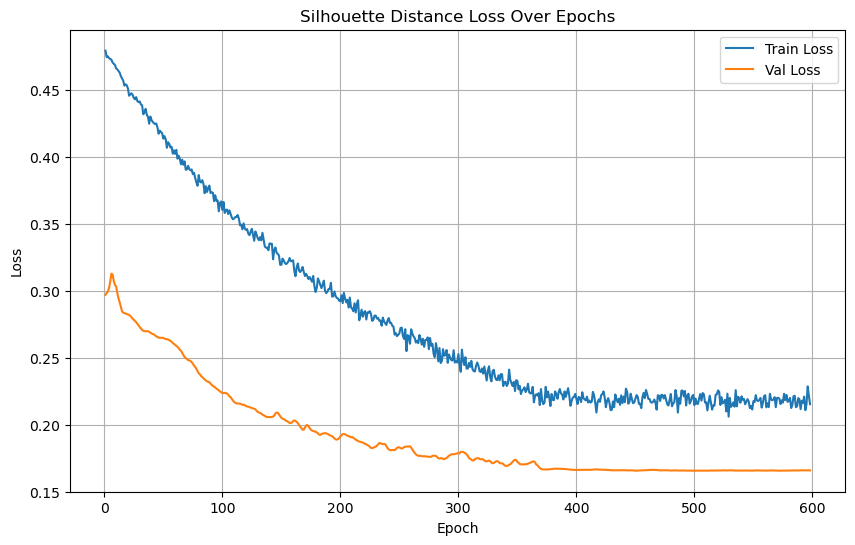

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/41], Loss: 0.1411
Test Batch [20/41], Loss: 0.1403


Test Batch [30/41], Loss: 0.5000
Test Batch [40/41], Loss: 0.0625

Test Loss: 0.1962


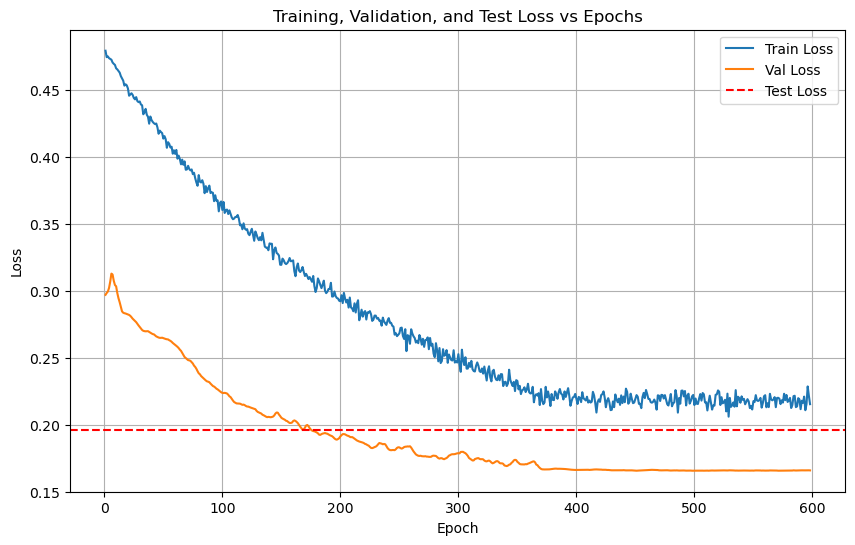

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/41 for test dataset.
  Processed batch 20/41 for test dataset.
  Processed batch 30/41 for test dataset.


  Processed batch 40/41 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 90.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       0.71      1.00      0.83         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      0.60      0.75         5
           9       0.80      0.80      0.80         5
          10       1.00      0.80      0.89         5
          11       1.00      0.60      0.75         5
          12       0.57      0.80      0.67         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6237  |  Val Loss: 2.5544
Validation loss improved from inf to 2.5544.
[Epoch 2/1000] Train Loss: 2.5203  |  Val Loss: 2.4695
Validation loss improved from 2.5544 to 2.4695.
[Epoch 3/1000] Train Loss: 2.4355  |  Val Loss: 2.3985
Validation loss improved from 2.4695 to 2.3985.
[Epoch 4/1000] Train Loss: 2.3634  |  Val Loss: 2.3350
Validation loss improved from 2.3985 to 2.3350.
[Epoch 5/1000] Train Loss: 2.2987  |  Val Loss: 2.2762
Validation loss improved from 2.3350 to 2.2762.


[Epoch 6/1000] Train Loss: 2.2402  |  Val Loss: 2.2230
Validation loss improved from 2.2762 to 2.2230.
[Epoch 7/1000] Train Loss: 2.1861  |  Val Loss: 2.1737
Validation loss improved from 2.2230 to 2.1737.
[Epoch 8/1000] Train Loss: 2.1339  |  Val Loss: 2.1285
Validation loss improved from 2.1737 to 2.1285.
[Epoch 9/1000] Train Loss: 2.0831  |  Val Loss: 2.0855
Validation loss improved from 2.1285 to 2.0855.


[Epoch 10/1000] Train Loss: 2.0349  |  Val Loss: 2.0433
Validation loss improved from 2.0855 to 2.0433.
[Epoch 11/1000] Train Loss: 1.9876  |  Val Loss: 2.0023
Validation loss improved from 2.0433 to 2.0023.
[Epoch 12/1000] Train Loss: 1.9395  |  Val Loss: 1.9629
Validation loss improved from 2.0023 to 1.9629.
[Epoch 13/1000] Train Loss: 1.8924  |  Val Loss: 1.9229
Validation loss improved from 1.9629 to 1.9229.


[Epoch 14/1000] Train Loss: 1.8465  |  Val Loss: 1.8823
Validation loss improved from 1.9229 to 1.8823.
[Epoch 15/1000] Train Loss: 1.7987  |  Val Loss: 1.8400
Validation loss improved from 1.8823 to 1.8400.
[Epoch 16/1000] Train Loss: 1.7511  |  Val Loss: 1.7973
Validation loss improved from 1.8400 to 1.7973.
[Epoch 17/1000] Train Loss: 1.7026  |  Val Loss: 1.7559
Validation loss improved from 1.7973 to 1.7559.
[Epoch 18/1000] Train Loss: 1.6543  |  Val Loss: 1.7147
Validation loss improved from 1.7559 to 1.7147.


[Epoch 19/1000] Train Loss: 1.6070  |  Val Loss: 1.6730
Validation loss improved from 1.7147 to 1.6730.
[Epoch 20/1000] Train Loss: 1.5599  |  Val Loss: 1.6320
Validation loss improved from 1.6730 to 1.6320.
[Epoch 21/1000] Train Loss: 1.5127  |  Val Loss: 1.5911
Validation loss improved from 1.6320 to 1.5911.


[Epoch 22/1000] Train Loss: 1.4662  |  Val Loss: 1.5504
Validation loss improved from 1.5911 to 1.5504.
[Epoch 23/1000] Train Loss: 1.4200  |  Val Loss: 1.5091
Validation loss improved from 1.5504 to 1.5091.
[Epoch 24/1000] Train Loss: 1.3730  |  Val Loss: 1.4687
Validation loss improved from 1.5091 to 1.4687.
[Epoch 25/1000] Train Loss: 1.3269  |  Val Loss: 1.4282
Validation loss improved from 1.4687 to 1.4282.


[Epoch 26/1000] Train Loss: 1.2804  |  Val Loss: 1.3869
Validation loss improved from 1.4282 to 1.3869.
[Epoch 27/1000] Train Loss: 1.2337  |  Val Loss: 1.3462
Validation loss improved from 1.3869 to 1.3462.
[Epoch 28/1000] Train Loss: 1.1877  |  Val Loss: 1.3057
Validation loss improved from 1.3462 to 1.3057.
[Epoch 29/1000] Train Loss: 1.1413  |  Val Loss: 1.2656
Validation loss improved from 1.3057 to 1.2656.
[Epoch 30/1000] Train Loss: 1.0953  |  Val Loss: 1.2260
Validation loss improved from 1.2656 to 1.2260.


[Epoch 31/1000] Train Loss: 1.0509  |  Val Loss: 1.1872
Validation loss improved from 1.2260 to 1.1872.


[Epoch 32/1000] Train Loss: 1.0061  |  Val Loss: 1.1497
Validation loss improved from 1.1872 to 1.1497.
[Epoch 33/1000] Train Loss: 0.9622  |  Val Loss: 1.1125
Validation loss improved from 1.1497 to 1.1125.
[Epoch 34/1000] Train Loss: 0.9199  |  Val Loss: 1.0769
Validation loss improved from 1.1125 to 1.0769.
[Epoch 35/1000] Train Loss: 0.8789  |  Val Loss: 1.0416
Validation loss improved from 1.0769 to 1.0416.


[Epoch 36/1000] Train Loss: 0.8390  |  Val Loss: 1.0079
Validation loss improved from 1.0416 to 1.0079.
[Epoch 37/1000] Train Loss: 0.8006  |  Val Loss: 0.9756
Validation loss improved from 1.0079 to 0.9756.
[Epoch 38/1000] Train Loss: 0.7632  |  Val Loss: 0.9446
Validation loss improved from 0.9756 to 0.9446.
[Epoch 39/1000] Train Loss: 0.7277  |  Val Loss: 0.9143
Validation loss improved from 0.9446 to 0.9143.
[Epoch 40/1000] Train Loss: 0.6938  |  Val Loss: 0.8856
Validation loss improved from 0.9143 to 0.8856.


[Epoch 41/1000] Train Loss: 0.6611  |  Val Loss: 0.8574
Validation loss improved from 0.8856 to 0.8574.
[Epoch 42/1000] Train Loss: 0.6298  |  Val Loss: 0.8302
Validation loss improved from 0.8574 to 0.8302.
[Epoch 43/1000] Train Loss: 0.5999  |  Val Loss: 0.8049
Validation loss improved from 0.8302 to 0.8049.
[Epoch 44/1000] Train Loss: 0.5717  |  Val Loss: 0.7808
Validation loss improved from 0.8049 to 0.7808.
[Epoch 45/1000] Train Loss: 0.5452  |  Val Loss: 0.7583
Validation loss improved from 0.7808 to 0.7583.


[Epoch 46/1000] Train Loss: 0.5197  |  Val Loss: 0.7368
Validation loss improved from 0.7583 to 0.7368.
[Epoch 47/1000] Train Loss: 0.4959  |  Val Loss: 0.7171
Validation loss improved from 0.7368 to 0.7171.
[Epoch 48/1000] Train Loss: 0.4727  |  Val Loss: 0.6986
Validation loss improved from 0.7171 to 0.6986.
[Epoch 49/1000] Train Loss: 0.4515  |  Val Loss: 0.6805
Validation loss improved from 0.6986 to 0.6805.
[Epoch 50/1000] Train Loss: 0.4307  |  Val Loss: 0.6636
Validation loss improved from 0.6805 to 0.6636.
[Epoch 51/1000] Train Loss: 0.4110  |  Val Loss: 0.6490
Validation loss improved from 0.6636 to 0.6490.


[Epoch 52/1000] Train Loss: 0.3929  |  Val Loss: 0.6337
Validation loss improved from 0.6490 to 0.6337.
[Epoch 53/1000] Train Loss: 0.3753  |  Val Loss: 0.6194
Validation loss improved from 0.6337 to 0.6194.
[Epoch 54/1000] Train Loss: 0.3586  |  Val Loss: 0.6060
Validation loss improved from 0.6194 to 0.6060.
[Epoch 55/1000] Train Loss: 0.3427  |  Val Loss: 0.5941
Validation loss improved from 0.6060 to 0.5941.
[Epoch 56/1000] Train Loss: 0.3277  |  Val Loss: 0.5823
Validation loss improved from 0.5941 to 0.5823.


[Epoch 57/1000] Train Loss: 0.3130  |  Val Loss: 0.5719
Validation loss improved from 0.5823 to 0.5719.
[Epoch 58/1000] Train Loss: 0.2993  |  Val Loss: 0.5622
Validation loss improved from 0.5719 to 0.5622.
[Epoch 59/1000] Train Loss: 0.2865  |  Val Loss: 0.5524
Validation loss improved from 0.5622 to 0.5524.
[Epoch 60/1000] Train Loss: 0.2736  |  Val Loss: 0.5442
Validation loss improved from 0.5524 to 0.5442.
[Epoch 61/1000] Train Loss: 0.2620  |  Val Loss: 0.5363
Validation loss improved from 0.5442 to 0.5363.
[Epoch 62/1000] Train Loss: 0.2506  |  Val Loss: 0.5278
Validation loss improved from 0.5363 to 0.5278.
[Epoch 63/1000] Train Loss: 0.2395  |  Val Loss: 0.5210
Validation loss improved from 0.5278 to 0.5210.


[Epoch 64/1000] Train Loss: 0.2290  |  Val Loss: 0.5141
Validation loss improved from 0.5210 to 0.5141.
[Epoch 65/1000] Train Loss: 0.2194  |  Val Loss: 0.5070
Validation loss improved from 0.5141 to 0.5070.
[Epoch 66/1000] Train Loss: 0.2098  |  Val Loss: 0.5007
Validation loss improved from 0.5070 to 0.5007.
[Epoch 67/1000] Train Loss: 0.2009  |  Val Loss: 0.4942
Validation loss improved from 0.5007 to 0.4942.
[Epoch 68/1000] Train Loss: 0.1927  |  Val Loss: 0.4878
Validation loss improved from 0.4942 to 0.4878.


[Epoch 69/1000] Train Loss: 0.1842  |  Val Loss: 0.4820
Validation loss improved from 0.4878 to 0.4820.
[Epoch 70/1000] Train Loss: 0.1773  |  Val Loss: 0.4764
Validation loss improved from 0.4820 to 0.4764.
[Epoch 71/1000] Train Loss: 0.1695  |  Val Loss: 0.4720
Validation loss improved from 0.4764 to 0.4720.
[Epoch 72/1000] Train Loss: 0.1628  |  Val Loss: 0.4680
Validation loss improved from 0.4720 to 0.4680.
[Epoch 73/1000] Train Loss: 0.1564  |  Val Loss: 0.4638
Validation loss improved from 0.4680 to 0.4638.
[Epoch 74/1000] Train Loss: 0.1509  |  Val Loss: 0.4598
Validation loss improved from 0.4638 to 0.4598.


[Epoch 75/1000] Train Loss: 0.1447  |  Val Loss: 0.4551
Validation loss improved from 0.4598 to 0.4551.
[Epoch 76/1000] Train Loss: 0.1393  |  Val Loss: 0.4519
Validation loss improved from 0.4551 to 0.4519.
[Epoch 77/1000] Train Loss: 0.1345  |  Val Loss: 0.4491
Validation loss improved from 0.4519 to 0.4491.
[Epoch 78/1000] Train Loss: 0.1295  |  Val Loss: 0.4453
Validation loss improved from 0.4491 to 0.4453.


[Epoch 79/1000] Train Loss: 0.1250  |  Val Loss: 0.4419
Validation loss improved from 0.4453 to 0.4419.
[Epoch 80/1000] Train Loss: 0.1207  |  Val Loss: 0.4394
Validation loss improved from 0.4419 to 0.4394.
[Epoch 81/1000] Train Loss: 0.1169  |  Val Loss: 0.4366
Validation loss improved from 0.4394 to 0.4366.
[Epoch 82/1000] Train Loss: 0.1133  |  Val Loss: 0.4346
Validation loss improved from 0.4366 to 0.4346.
[Epoch 83/1000] Train Loss: 0.1100  |  Val Loss: 0.4311
Validation loss improved from 0.4346 to 0.4311.
[Epoch 84/1000] Train Loss: 0.1064  |  Val Loss: 0.4298
Validation loss improved from 0.4311 to 0.4298.
[Epoch 85/1000] Train Loss: 0.1034  |  Val Loss: 0.4282
Validation loss improved from 0.4298 to 0.4282.


[Epoch 86/1000] Train Loss: 0.1005  |  Val Loss: 0.4261
Validation loss improved from 0.4282 to 0.4261.
[Epoch 87/1000] Train Loss: 0.0978  |  Val Loss: 0.4243
Validation loss improved from 0.4261 to 0.4243.
[Epoch 88/1000] Train Loss: 0.0951  |  Val Loss: 0.4222
Validation loss improved from 0.4243 to 0.4222.
[Epoch 89/1000] Train Loss: 0.0929  |  Val Loss: 0.4205
Validation loss improved from 0.4222 to 0.4205.


[Epoch 90/1000] Train Loss: 0.0907  |  Val Loss: 0.4191
Validation loss improved from 0.4205 to 0.4191.
[Epoch 91/1000] Train Loss: 0.0882  |  Val Loss: 0.4184
Validation loss improved from 0.4191 to 0.4184.
[Epoch 92/1000] Train Loss: 0.0865  |  Val Loss: 0.4188
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 93/1000] Train Loss: 0.0842  |  Val Loss: 0.4170
Validation loss improved from 0.4184 to 0.4170.
[Epoch 94/1000] Train Loss: 0.0822  |  Val Loss: 0.4150
Validation loss improved from 0.4170 to 0.4150.
[Epoch 95/1000] Train Loss: 0.0805  |  Val Loss: 0.4138
Validation loss improved from 0.4150 to 0.4138.
[Epoch 96/1000] Train Loss: 0.0791  |  Val Loss: 0.4129
Validation loss improved from 0.4138 to 0.4129.
[Epoch 97/1000] Train Loss: 0.0772  |  Val Loss: 0.4121
Validation loss improved from 0.4129 to 0.4121.


[Epoch 98/1000] Train Loss: 0.0759  |  Val Loss: 0.4113
Validation loss improved from 0.4121 to 0.4113.
[Epoch 99/1000] Train Loss: 0.0743  |  Val Loss: 0.4104
Validation loss improved from 0.4113 to 0.4104.
[Epoch 100/1000] Train Loss: 0.0727  |  Val Loss: 0.4104
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 101/1000] Train Loss: 0.0713  |  Val Loss: 0.4106
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 102/1000] Train Loss: 0.0702  |  Val Loss: 0.4092
Validation loss improved from 0.4104 to 0.4092.
[Epoch 103/1000] Train Loss: 0.0689  |  Val Loss: 0.4095
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 104/1000] Train Loss: 0.0679  |  Val Loss: 0.4093
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 105/1000] Train Loss: 0.0666  |  Val Loss: 0.4079
Validation loss improved from 0.4092 to 0.4079.
[Epoch 106/1000] Train Loss: 0.0655  |  Val Loss: 0.4085
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 107/1000] Train Loss: 0.0646  |  Val Loss: 0.4073
Validation loss improved from 0.4079 to 0.4073.
[Epoch 108/1000] Train Loss: 0.0634  |  Val Loss: 0.4068
Validation loss improved from 0.4073 to 0.4068.


[Epoch 109/1000] Train Loss: 0.0624  |  Val Loss: 0.4070
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 110/1000] Train Loss: 0.0616  |  Val Loss: 0.4065
Validation loss improved from 0.4068 to 0.4065.
[Epoch 111/1000] Train Loss: 0.0607  |  Val Loss: 0.4073
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 112/1000] Train Loss: 0.0598  |  Val Loss: 0.4071
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 113/1000] Train Loss: 0.0590  |  Val Loss: 0.4069
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 114/1000] Train Loss: 0.0581  |  Val Loss: 0.4051
Validation loss improved from 0.4065 to 0.4051.
[Epoch 115/1000] Train Loss: 0.0575  |  Val Loss: 0.4040
Validation loss improved from 0.4051 to 0.4040.
[Epoch 116/1000] Train Loss: 0.0566  |  Val Loss: 0.4052
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 117/1000] Train Loss: 0.0558  |  Val Loss: 0.4060
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 118/1000] Train Loss: 0.0554  |  Val Loss: 0.4042
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 119/1000] Train Loss: 0.0544  |  Val Loss: 0.4049
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 120/1000] Train Loss: 0.0537  |  Val Loss: 0.4048
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 121/1000] Train Loss: 0.0534  |  Val Loss: 0.4061
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 122/1000] Train Loss: 0.0525  |  Val Loss: 0.4054
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 123/1000] Train Loss: 0.0520  |  Val Loss: 0.4039
Validation loss improved from 0.4040 to 0.4039.
[Epoch 124/1000] Train Loss: 0.0514  |  Val Loss: 0.4033
Validation loss improved from 0.4039 to 0.4033.


[Epoch 125/1000] Train Loss: 0.0509  |  Val Loss: 0.4044
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 126/1000] Train Loss: 0.0503  |  Val Loss: 0.4052
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 127/1000] Train Loss: 0.0496  |  Val Loss: 0.4047
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 128/1000] Train Loss: 0.0494  |  Val Loss: 0.4028
Validation loss improved from 0.4033 to 0.4028.
[Epoch 129/1000] Train Loss: 0.0488  |  Val Loss: 0.4034
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 130/1000] Train Loss: 0.0482  |  Val Loss: 0.4041
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 131/1000] Train Loss: 0.0477  |  Val Loss: 0.4042
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 132/1000] Train Loss: 0.0473  |  Val Loss: 0.4048
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 133/1000] Train Loss: 0.0470  |  Val Loss: 0.4057
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 134/1000] Train Loss: 0.0467  |  Val Loss: 0.4041
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 135/1000] Train Loss: 0.0459  |  Val Loss: 0.4047
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 136/1000] Train Loss: 0.0456  |  Val Loss: 0.4052
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 137/1000] Train Loss: 0.0452  |  Val Loss: 0.4054
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 138/1000] Train Loss: 0.0448  |  Val Loss: 0.4047
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 139/1000] Train Loss: 0.0443  |  Val Loss: 0.4048
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 140/1000] Train Loss: 0.0439  |  Val Loss: 0.4060
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 141/1000] Train Loss: 0.0436  |  Val Loss: 0.4062
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 142/1000] Train Loss: 0.0431  |  Val Loss: 0.4059
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 143/1000] Train Loss: 0.0427  |  Val Loss: 0.4051
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 144/1000] Train Loss: 0.0426  |  Val Loss: 0.4053
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 145/1000] Train Loss: 0.0422  |  Val Loss: 0.4057
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 146/1000] Train Loss: 0.0417  |  Val Loss: 0.4052
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 147/1000] Train Loss: 0.0415  |  Val Loss: 0.4054
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 148/1000] Train Loss: 0.0412  |  Val Loss: 0.4055
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 149/1000] Train Loss: 0.0409  |  Val Loss: 0.4050
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 150/1000] Train Loss: 0.0406  |  Val Loss: 0.4057
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 151/1000] Train Loss: 0.0402  |  Val Loss: 0.4068
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 152/1000] Train Loss: 0.0399  |  Val Loss: 0.4063
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 153/1000] Train Loss: 0.0395  |  Val Loss: 0.4070
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 154/1000] Train Loss: 0.0394  |  Val Loss: 0.4064
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 155/1000] Train Loss: 0.0391  |  Val Loss: 0.4061
!! Validation loss did NOT improve !! Patience:

[Epoch 156/1000] Train Loss: 0.0388  |  Val Loss: 0.4074
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 157/1000] Train Loss: 0.0385  |  Val Loss: 0.4077
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 158/1000] Train Loss: 0.0381  |  Val Loss: 0.4072
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 159/1000] Train Loss: 0.0380  |  Val Loss: 0.4065
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 160/1000] Train Loss: 0.0376  |  Val Loss: 0.4085
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 161/1000] Train Loss: 0.0373  |  Val Loss: 0.4088
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 162/1000] Train Loss: 0.0372  |  Val Loss: 0.4085
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 163/1000] Train Loss: 0.0367  |  Val Loss: 0.4078
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 164/1000] Train Loss: 0.0365  |  Val Loss: 0.4074
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 165/1000] Train Loss: 0.0363  |  Val Loss: 0.4071
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 166/1000] Train Loss: 0.0360  |  Val Loss: 0.4083
!! Validation loss did NOT improve !! Patience:

[Epoch 168/1000] Train Loss: 0.0354  |  Val Loss: 0.4079
!! Validation loss did NOT improve !! Patience: 40/100


[Epoch 169/1000] Train Loss: 0.0353  |  Val Loss: 0.4083
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 170/1000] Train Loss: 0.0351  |  Val Loss: 0.4081
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 171/1000] Train Loss: 0.0349  |  Val Loss: 0.4086
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 172/1000] Train Loss: 0.0348  |  Val Loss: 0.4105
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 173/1000] Train Loss: 0.0345  |  Val Loss: 0.4100
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 174/1000] Train Loss: 0.0343  |  Val Loss: 0.4091
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 175/1000] Train Loss: 0.0341  |  Val Loss: 0.4086
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 176/1000] Train Loss: 0.0337  |  Val Loss: 0.4098
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 177/1000] Train Loss: 0.0338  |  Val Loss: 0.4095
!! Validation loss did NOT improve !! Patience:

[Epoch 180/1000] Train Loss: 0.0329  |  Val Loss: 0.4102
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 181/1000] Train Loss: 0.0329  |  Val Loss: 0.4106
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 182/1000] Train Loss: 0.0325  |  Val Loss: 0.4097
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 183/1000] Train Loss: 0.0325  |  Val Loss: 0.4103
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 184/1000] Train Loss: 0.0322  |  Val Loss: 0.4100
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 185/1000] Train Loss: 0.0320  |  Val Loss: 0.4099
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 186/1000] Train Loss: 0.0318  |  Val Loss: 0.4107
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 187/1000] Train Loss: 0.0315  |  Val Loss: 0.4112
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 188/1000] Train Loss: 0.0314  |  Val Loss: 0.4119
!! Validation loss did NOT improve !! Patience:

[Epoch 192/1000] Train Loss: 0.0307  |  Val Loss: 0.4114
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 193/1000] Train Loss: 0.0305  |  Val Loss: 0.4124
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 194/1000] Train Loss: 0.0304  |  Val Loss: 0.4128
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 195/1000] Train Loss: 0.0306  |  Val Loss: 0.4127
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 196/1000] Train Loss: 0.0299  |  Val Loss: 0.4127
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 197/1000] Train Loss: 0.0298  |  Val Loss: 0.4137
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 198/1000] Train Loss: 0.0298  |  Val Loss: 0.4130
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 199/1000] Train Loss: 0.0296  |  Val Loss: 0.4143
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 200/1000] Train Loss: 0.0293  |  Val Loss: 0.4140
!! Validation loss did NOT improve !! Patience:

[Epoch 203/1000] Train Loss: 0.0289  |  Val Loss: 0.4144
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 204/1000] Train Loss: 0.0289  |  Val Loss: 0.4147
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 205/1000] Train Loss: 0.0286  |  Val Loss: 0.4138
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 206/1000] Train Loss: 0.0284  |  Val Loss: 0.4144
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 207/1000] Train Loss: 0.0283  |  Val Loss: 0.4150
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 208/1000] Train Loss: 0.0281  |  Val Loss: 0.4156
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 209/1000] Train Loss: 0.0281  |  Val Loss: 0.4159
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 210/1000] Train Loss: 0.0280  |  Val Loss: 0.4166
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 211/1000] Train Loss: 0.0279  |  Val Loss: 0.4152
!! Validation loss did NOT improve !! Patience:

[Epoch 214/1000] Train Loss: 0.0273  |  Val Loss: 0.4169
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 215/1000] Train Loss: 0.0273  |  Val Loss: 0.4159
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 216/1000] Train Loss: 0.0269  |  Val Loss: 0.4171
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 217/1000] Train Loss: 0.0270  |  Val Loss: 0.4175
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 218/1000] Train Loss: 0.0267  |  Val Loss: 0.4157
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 219/1000] Train Loss: 0.0265  |  Val Loss: 0.4164
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 220/1000] Train Loss: 0.0264  |  Val Loss: 0.4168
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 221/1000] Train Loss: 0.0261  |  Val Loss: 0.4164
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 222/1000] Train Loss: 0.0260  |  Val Loss: 0.4163
!! Validation loss did NOT improve !! Patience:

[Epoch 226/1000] Train Loss: 0.0257  |  Val Loss: 0.4193
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 227/1000] Train Loss: 0.0256  |  Val Loss: 0.4195
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 228/1000] Train Loss: 0.0253  |  Val Loss: 0.4179
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 228 !!
No improvement for 100 epochs.


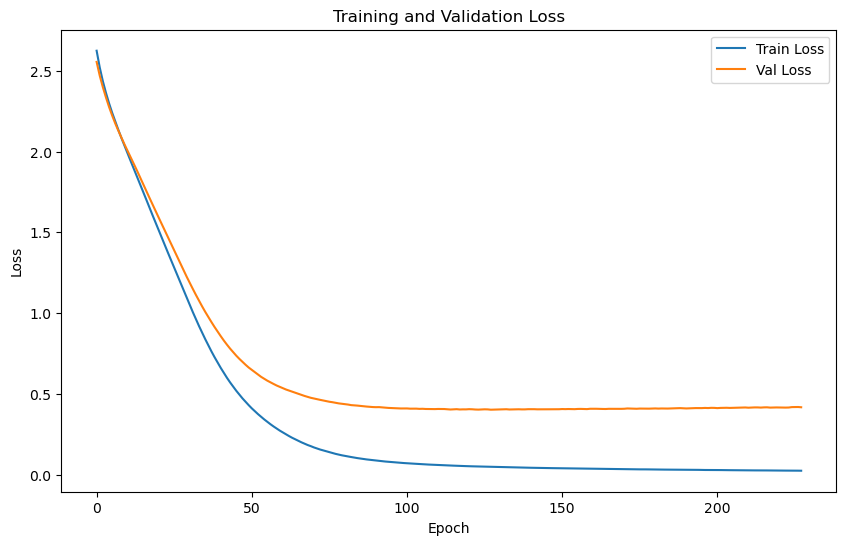

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.2953 | Test Accuracy: 90.37%


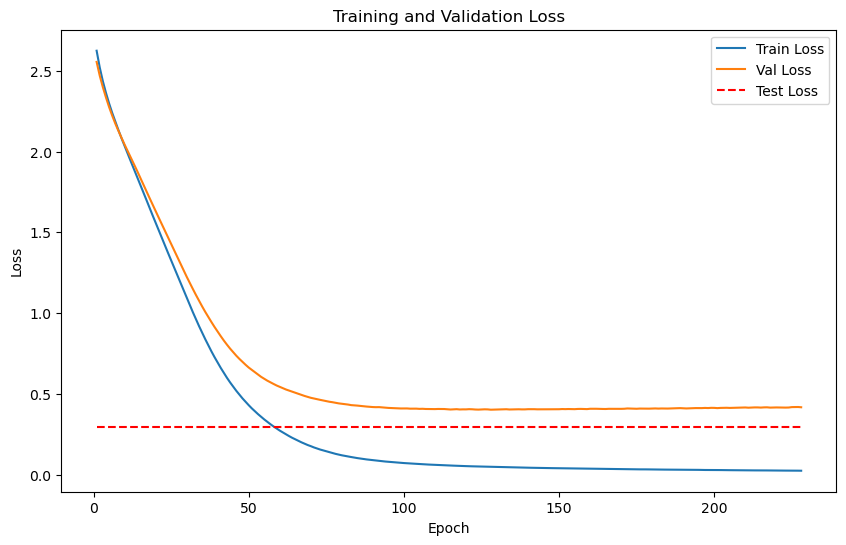

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


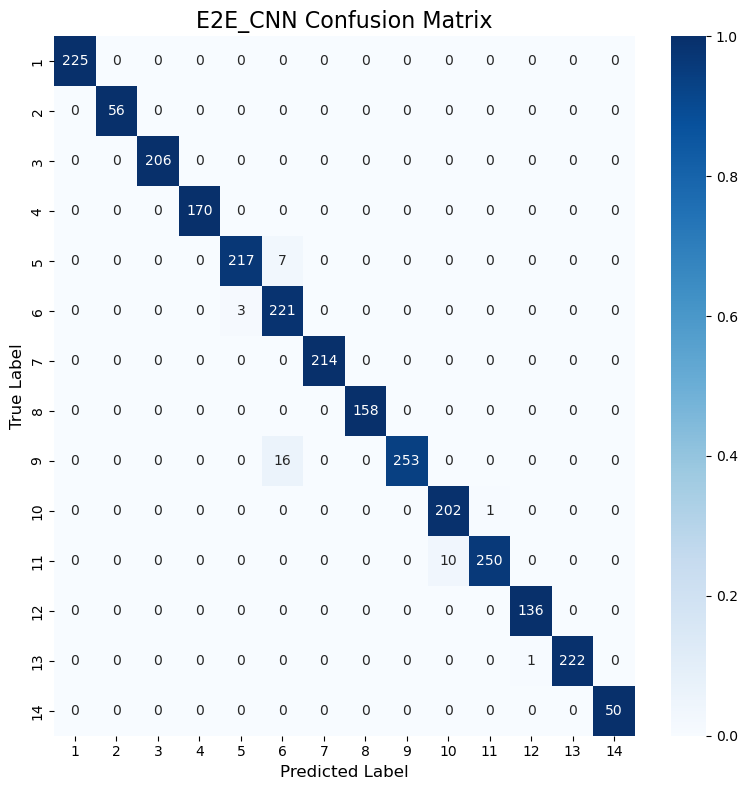

Classification Accuracy: 98.55%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


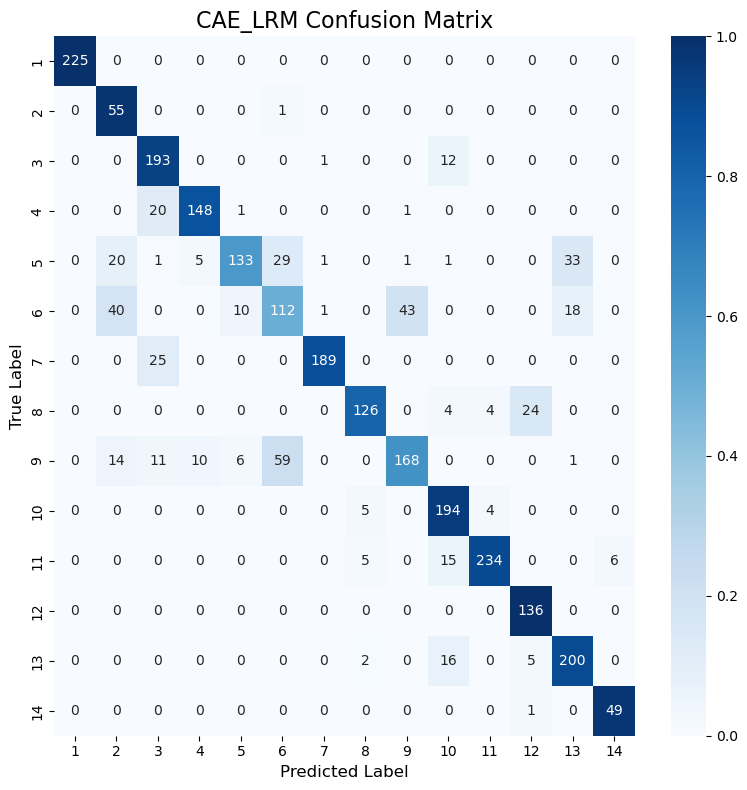

Classification Accuracy: 82.58%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


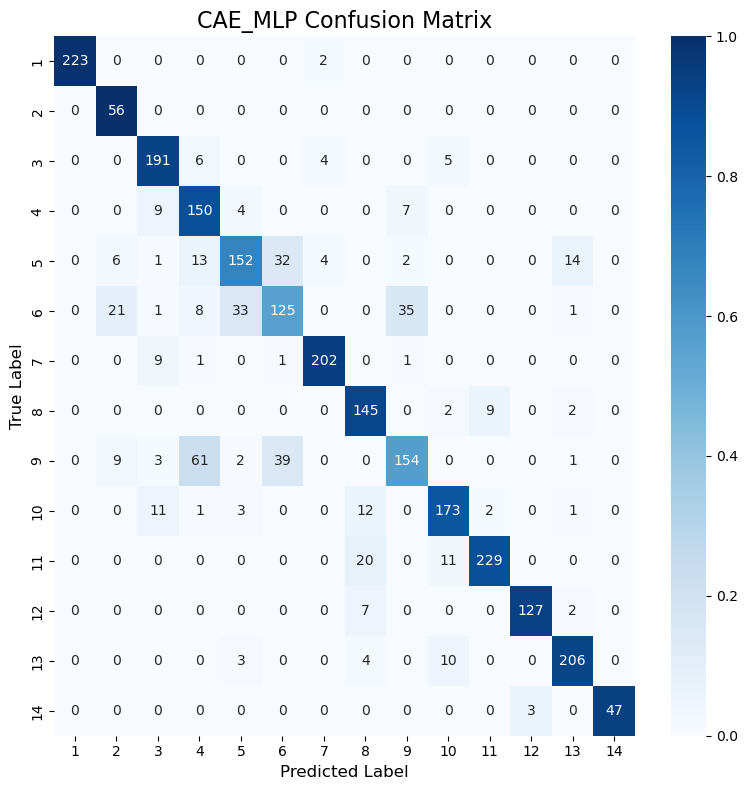

Classification Accuracy: 83.27%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


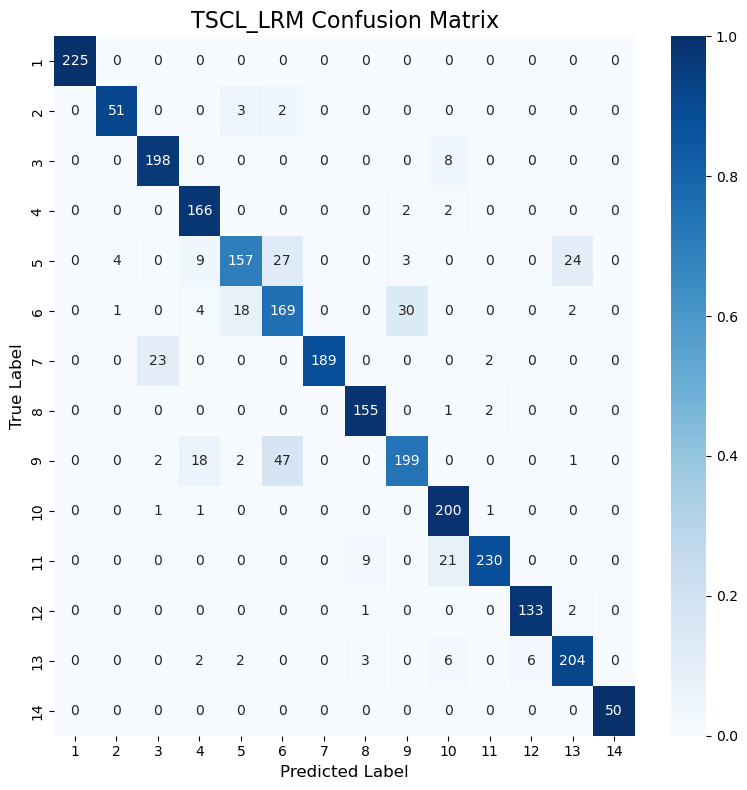

Classification Accuracy: 88.85%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


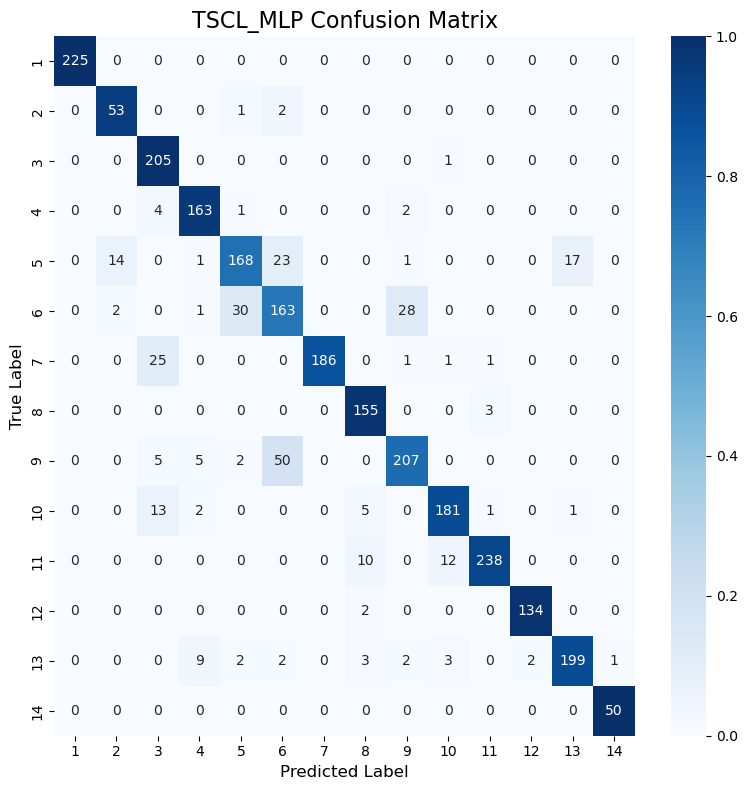

Classification Accuracy: 88.88%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


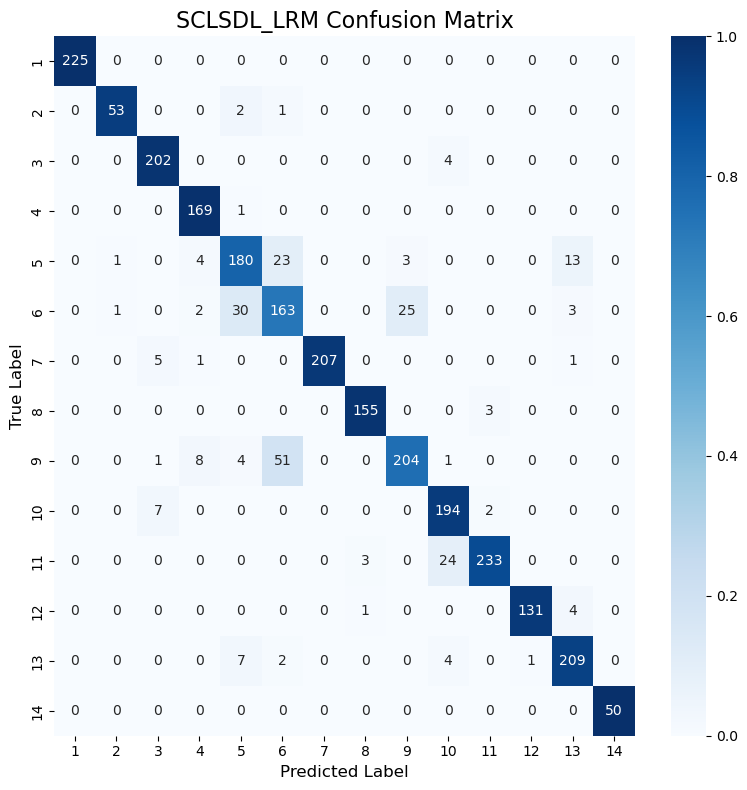

Classification Accuracy: 90.72%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


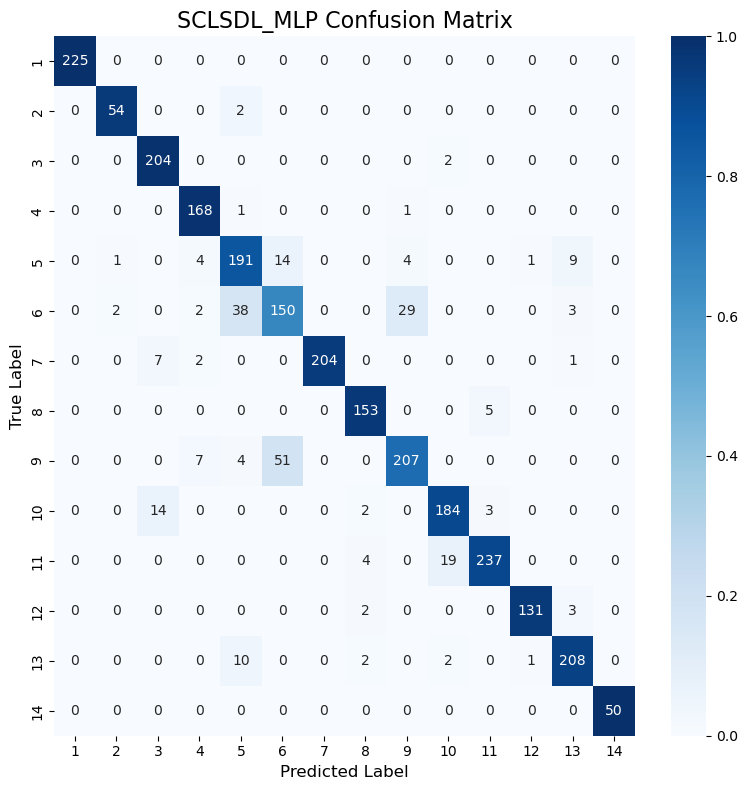

Classification Accuracy: 90.37%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          98.55
1    LRM (CAE)          82.58
2    MLP (CAE)          83.27
3     TSCL LRM          88.85
4     TSCL MLP          88.88
5  SCL_SDL LRM          90.72
6  SCL_SDL MLP          90.37

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          98.55
5  SCL_SDL LRM          90.72
6  SCL_SDL MLP          90.37
4     TSCL MLP          88.88
3     TSCL LRM          88.85
2    MLP (CAE)          83.27
1    LRM (CAE)          82.58
